In [30]:
import numpy as np
import gym
from matplotlib import pyplot as plt
from frozen_lake import *
import seaborn as sns
from time import time
from tqdm import tqdm

In [2]:
np.random.seed(0)
large_map = generate_random_map(size=50, p=0.8)
small_map = generate_random_map(size=4, p=0.8)

In [3]:
env_small = FrozenLakeEnv(desc=small_map, neg_rew=-0.1)
env_large = FrozenLakeEnv(desc=large_map, neg_rew=-2)

In [46]:
def plot_lake(env,lake_map, problem = "Frozen lake"):
    V = np.zeros((env.nrow, env.ncol))
    for i in range(env.nrow):
        for j in range(env.ncol):
            if lake_map[i][j] == 'H':
                V[i,j] = 1 
    fig, ax = plt.subplots(1, 1, figsize=(18,9))
    ax.set_title("lake map "+problem)
    sns.heatmap(V.reshape(env.nrow, env.ncol), annot=False, fmt='.2f', linewidths=.4)
    plt.show()


def plot_deltas_time(deltas, times, problem="Frozen Lake"):

    fig, ax = plt.subplots(1, 2, figsize=(18,5))
    ax[0].set_title("Delta V "+problem)
    ax[0].set_ylabel('delta V')
    ax[0].set_xlabel('iteration')
    ax[0].plot(np.arange(len(deltas)), deltas)
    ax[1].set_title("Computational Time "+problem)
    ax[1].set_ylabel('time')
    ax[1].set_xlabel('iteration')
    ax[1].plot(np.arange(len(times)), times)
    plt.show()
        
def plot_scores_time(scores, times, problem="Frozen Lake"):

    fig, ax = plt.subplots(1, 2, figsize=(18,5))
    ax[0].set_title("Episode scores "+problem)
    ax[0].set_ylabel('score')
    ax[0].set_xlabel('episode')
    ax[0].plot(np.arange(len(scores)), scores)
    ax[1].set_title("Computational Time "+problem)
    ax[1].set_ylabel('time')
    ax[1].set_xlabel('episode')
    ax[1].plot(np.arange(len(times)), times)
    plt.show()
    
def plot_val_grid(env, V, problem='Frozen Lake'):
    
    fig, ax = plt.subplots(1, 1, figsize=(18,9))
    ax.set_title("Value grid "+problem)
    sns.heatmap(V.reshape(env.nrow, env.ncol), annot=False, fmt='.2f', linewidths=.4, cmap="YlGnBu")
    plt.show()

        
def plot_policy_map(policy, V, rows, columns, problem='Frozen Lake'):

    policy_labels = np.empty([rows, columns], dtype='<U32')
    for row in range(rows):
        for col in range(columns):
            state = row * columns + col
            policy_labels[row, col] += 'L' * (policy[state] == 0)
            policy_labels[row, col] += 'D' * (policy[state] == 1)
            policy_labels[row, col] += 'R' * (policy[state] == 2)
            policy_labels[row, col] += 'U' * (policy[state] == 3)

    fig, ax = plt.subplots(1, 1, figsize=(18,9))
    ax.set_title("Best action grid "+problem)
    sns.heatmap(V.reshape(rows, columns), annot=policy_labels, fmt='', linewidths=.4, cmap="YlGnBu")
    plt.show()

    
def get_actions(env, gamma, state, v):
    A = np.zeros(env.nA)
    for action in range(env.nA):
        for p, next_state, reward, done in env.P[state][action]:
            A[action] += p * (reward + gamma * v[next_state])
    return A


def value_iteration(env, discount=0.99, max_iterations=1000, threshold_delta=1e-03, problem='Frozen Lake Value Iteration'):
    
    V = np.zeros(env.nS)
    deltas = []
    times = []

    start_it_time = time()
    for _ in range(max_iterations):
        delta = 0
        reward = 0
    
        for state in range(env.nS):
            
            previous_V = V[state]
            A = get_actions(env, discount, state, V)

            # Value Iteration: update state value using the Bellman optimality equation
            best_action_value = np.max(A)
            V[state] = best_action_value

            # threshold is the highest delta so far
            delta = max(delta, np.abs(best_action_value - previous_V))

            # Best action
            best_action = np.argmax(V)

            reward += best_action_value

        deltas.append(delta)
        times.append(time()-start_it_time)
        
        if delta < threshold_delta:
            break;
    print('took %s iteration to converge'%(str(_)))
    optimal_policy  = np.zeros((env.nS, env.nA))
    optimal_actions  = np.zeros(env.nS).astype(int)
    
    for state in range(env.nS):
        A = get_actions(env, discount, state, V)
        best_action = np.argmax(A)

        optimal_policy[state, best_action] = 1.0
        optimal_actions[state] = best_action

    plot_deltas_time(deltas, times, problem)
    plot_val_grid(env, V, problem)
    plot_policy_map(optimal_actions, V, env.nrow, env.ncol, problem)

    return V, optimal_policy


def policy_iteration(env, discount_factor=0.995, max_iterations_hl=10, max_iterations_ll=100,threshold_delta = 1e-3, problem = 'Frozen Lake'):
    iteration = 0
    continue_improve = True
    
    V = np.zeros(env.nS)
    policy = np.ones([env.nS, env.nA]) / env.nA # Uniform action sampling initialization
    policy_actions = np.zeros(env.nS).astype(int)

    final_deltas = []
    final_times = []
    start_time = time()

    while iteration <= max_iterations_hl and continue_improve:
        deltas = []
        times = []
        for _ in tqdm(range(max_iterations_ll)):
            delta = 0
            reward = 0
            for state in range(env.nS):
                previous_V = V[state]

                # Update V
                Q_current_state = get_actions(env, discount_factor, state, V)
                V[state] = 0.
                for action in range(env.nA):
                    V[state] += policy[state, action] * Q_current_state[action]

                delta = max(delta, np.abs(V[state] - previous_V))

                reward += np.max(Q_current_state)

            deltas.append(delta)
            times.append(time() - start_time)


            if delta < threshold_delta:
                break;

        continue_improve = False

        for state in range(env.nS):
            # New best action
            previous_best_action = np.argmax(policy[state])
            Q_current_state = get_actions(env, discount_factor, state, V)
            new_best_action = np.argmax(Q_current_state.round(decimals=4))

            # If policy has improved
            if previous_best_action != new_best_action:
                continue_improve = True

            # New policies
            policy[state] = np.eye(env.nA)[new_best_action]
            policy_actions[state] = new_best_action

        final_deltas += deltas
        final_times += times
        iteration += 1

    print('took %s iteration to converge'%(len(final_times)))
    plot_deltas_time(final_deltas, final_times, problem)
    plot_val_grid(env, V, problem)
    plot_policy_map(policy_actions, V, env.nrow, env.ncol, problem)



    return V, policy_actions


In [124]:
def q_learning(env, num_episodes=10000, discount_factor=0.995, learning_rate_decay=0.9, epsilon_decay=0.9, problem="Frozen Lake", print_every = 100):

    np.random.seed(0)
    start = time()
    env.reset()

    scores, average_scores = [], []
    times = []
    running_time = 0
    episode = 0
    eps = 1
    lr = 1
    
    Q = np.zeros((env.nS, env.nA))

    max_score = -np.inf

    start_time = time()
    # Training
    for episode in tqdm(range(1,num_episodes)):
        
        score = 0
        state = env.reset()
        epsilon = eps* np.exp(-(episode-1)*epsilon_decay)
        learning_rate = lr * np.exp(-(episode-1)*learning_rate_decay)
        # Episode
        while True:
            if np.random.random() < epsilon:
                action = np.random.randint(env.nA)
            else:
                action = np.argmax(Q[state])
            next_state, reward, done, _ = env.step(action)

            Q[state, action] =  Q[state, action] * (1 - learning_rate) + \
                                     learning_rate * (reward + discount_factor * np.max(Q[next_state, :]))
            state = next_state
            score += reward

            if done:
                break

        scores.append(score)
        times.append(time()-start_time)
        

        if episode % print_every == 0:
            print('\nEpisode {}'.format(episode))
            print('score = {:.4f}'.format(score))

        

    plot_scores_time(scores, times)
                     
    best_Q = Q
    # Get final policy with the best Q
    V = np.zeros(env.nS)
    policy = np.zeros((env.nS, env.nA))
    policy_actions = np.zeros(env.nS).astype(int)

    for state in range(env.nS):
        best_action = np.argmax(best_Q[state])
        best_value = np.max(best_Q[state])

        policy[state, best_action] = 1.0
        V[state] = best_value
        policy_actions[state] = best_action

    plot_val_grid(env, V, problem)
    plot_policy_map(policy_actions, V, env.nrow, env.ncol, problem)
    env.close()

    return V, best_Q

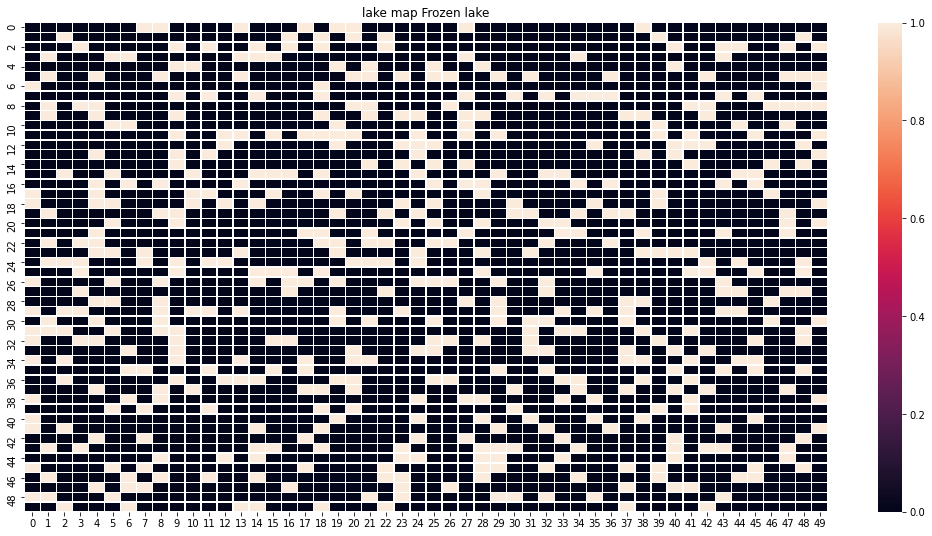

In [37]:
plot_lake(env_large,large_map)

  0%|          | 0/100 [00:00<?, ?it/s]


took 453 iteration to converge


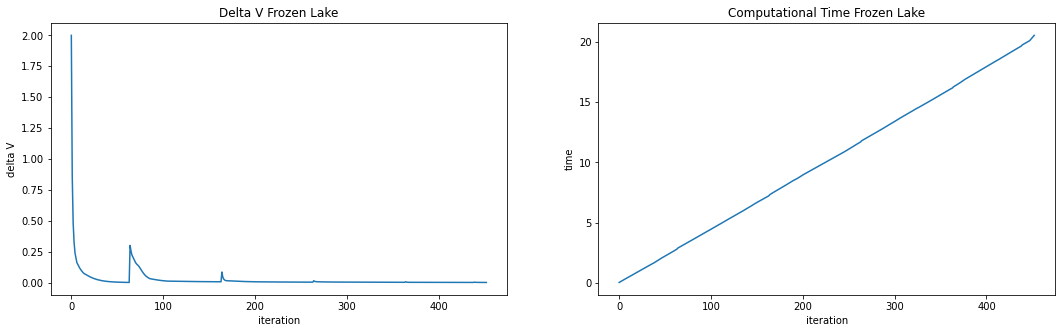

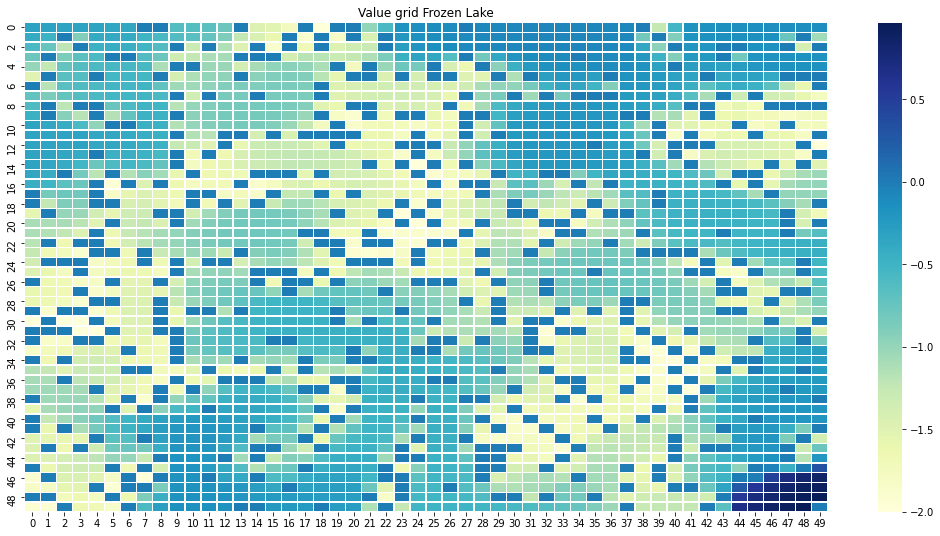

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


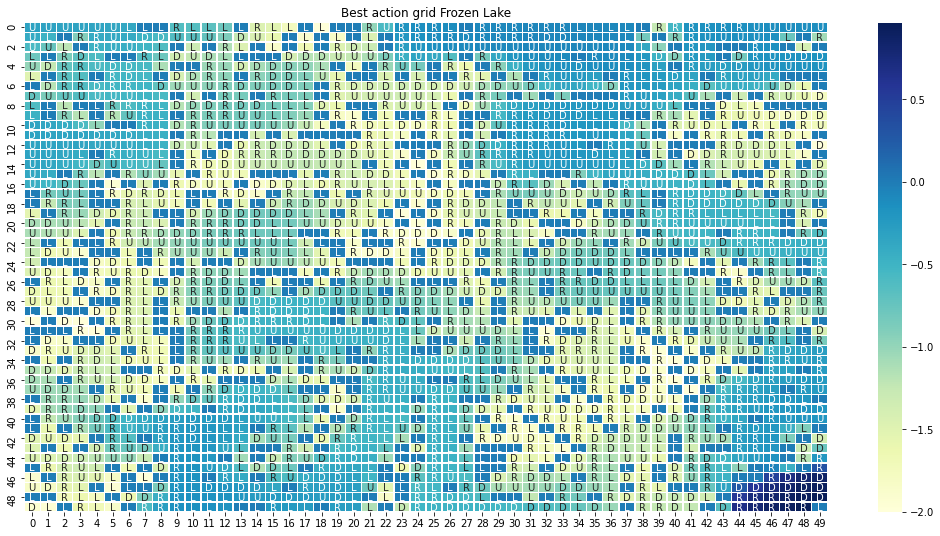

28.26909589767456


In [36]:
start = time()
policy_iteration(env_large)
print(time() - start)

took 799 iteration to converge


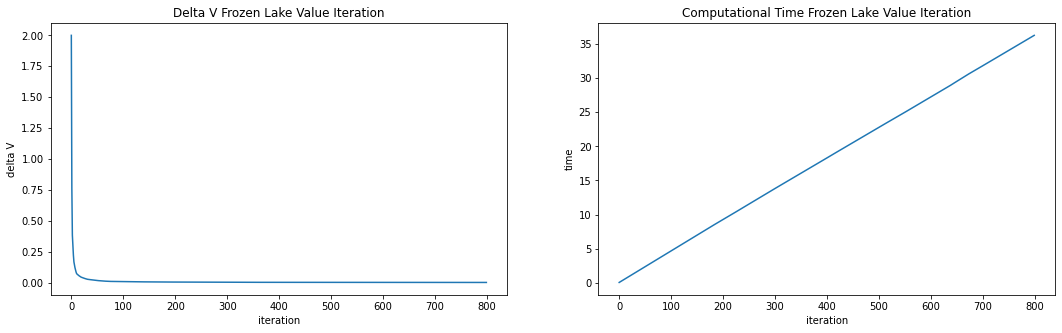

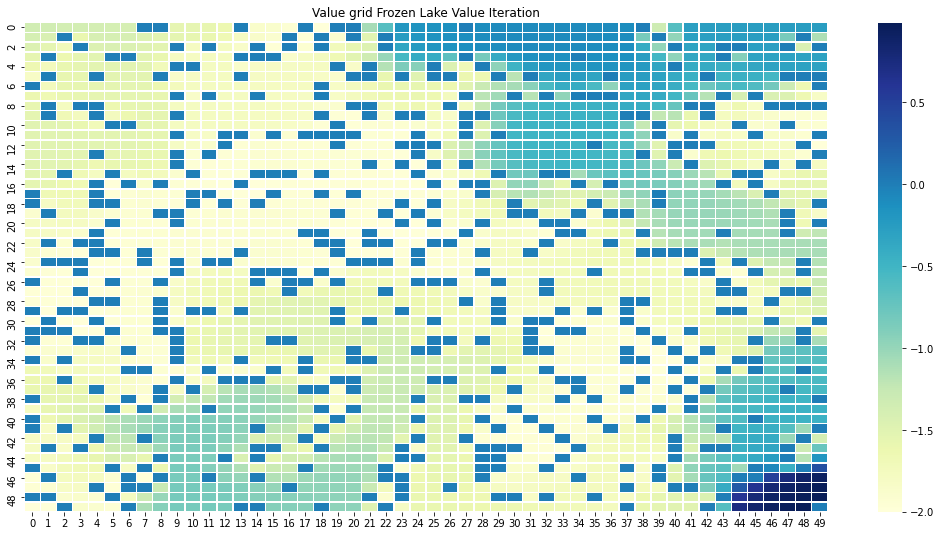

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


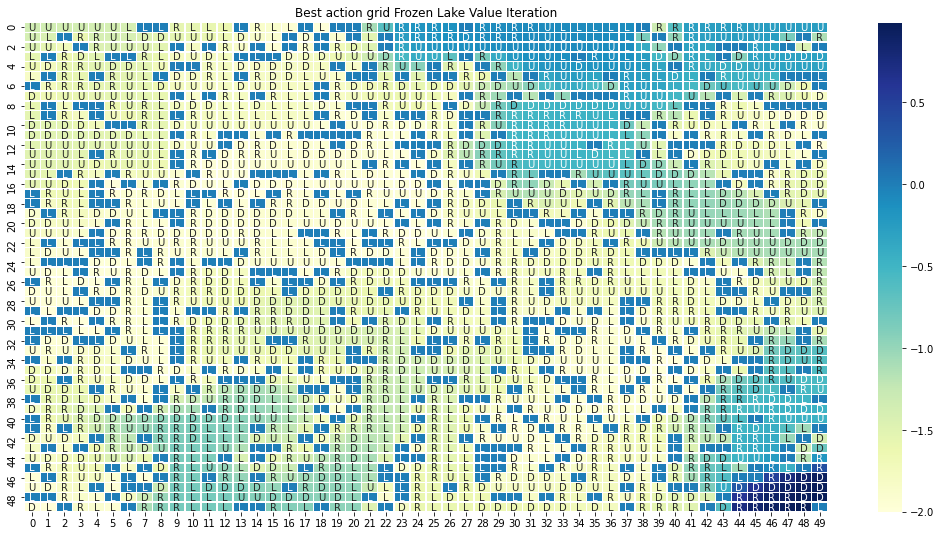

44.0553994178772


In [8]:
start = time()
value_iteration(env_large)
print(time() - start)


Episode 1000
score = -2.0000

Episode 2000
score = -2.0000

Episode 3000
score = -2.0000

Episode 4000
score = -2.0000

Episode 5000
score = -2.0000

Episode 6000
score = -2.0000

Episode 7000
score = -2.0000

Episode 8000
score = -2.0000

Episode 9000
score = -2.0000

Episode 10000
score = -2.0000

Episode 11000
score = -2.0000

Episode 12000
score = -2.0000

Episode 13000
score = -2.0000

Episode 14000
score = -2.0000

Episode 15000
score = -2.0000

Episode 16000
score = -2.0000

Episode 17000
score = -2.0000

Episode 18000
score = -2.0000

Episode 19000
score = -2.0000

Episode 20000
score = -2.0000

Episode 21000
score = -2.0000

Episode 22000
score = -2.0000

Episode 23000
score = -2.0000

Episode 24000
score = -2.0000

Episode 25000
score = -2.0000

Episode 26000
score = -2.0000

Episode 27000
score = -2.0000

Episode 28000
score = -2.0000

Episode 29000
score = -2.0000

Episode 30000
score = -2.0000

Episode 31000
score = -2.0000

Episode 32000
score = -2.0000

Episode 33000
sc


Episode 261000
score = -2.0000

Episode 262000
score = -2.0000

Episode 263000
score = -2.0000

Episode 264000
score = -2.0000

Episode 265000
score = -2.0000

Episode 266000
score = -2.0000

Episode 267000
score = -2.0000

Episode 268000
score = -2.0000

Episode 269000
score = -2.0000

Episode 270000
score = -2.0000

Episode 271000
score = -2.0000

Episode 272000
score = -2.0000

Episode 273000
score = -2.0000

Episode 274000
score = -2.0000

Episode 275000
score = -2.0000

Episode 276000
score = -2.0000

Episode 277000
score = -2.0000

Episode 278000
score = -2.0000

Episode 279000
score = -2.0000

Episode 280000
score = -2.0000

Episode 281000
score = -2.0000

Episode 282000
score = -2.0000

Episode 283000
score = -2.0000

Episode 284000
score = -2.0000

Episode 285000
score = -2.0000

Episode 286000
score = -2.0000

Episode 287000
score = -2.0000

Episode 288000
score = -2.0000

Episode 289000
score = -2.0000

Episode 290000
score = -2.0000

Episode 291000
score = -2.0000

Episode


Episode 518000
score = -2.0000

Episode 519000
score = -2.0000

Episode 520000
score = -2.0000

Episode 521000
score = -2.0000

Episode 522000
score = -2.0000

Episode 523000
score = -2.0000

Episode 524000
score = -2.0000

Episode 525000
score = -2.0000

Episode 526000
score = -2.0000

Episode 527000
score = -2.0000

Episode 528000
score = -2.0000

Episode 529000
score = -2.0000

Episode 530000
score = -2.0000

Episode 531000
score = -2.0000

Episode 532000
score = -2.0000

Episode 533000
score = -2.0000

Episode 534000
score = -2.0000

Episode 535000
score = -2.0000

Episode 536000
score = -2.0000

Episode 537000
score = -2.0000

Episode 538000
score = -2.0000

Episode 539000
score = -2.0000

Episode 540000
score = -2.0000

Episode 541000
score = -2.0000

Episode 542000
score = -2.0000

Episode 543000
score = -2.0000

Episode 544000
score = -2.0000

Episode 545000
score = -2.0000

Episode 546000
score = -2.0000

Episode 547000
score = -2.0000

Episode 548000
score = -2.0000

Episode


Episode 775000
score = -2.0000

Episode 776000
score = -2.0000

Episode 777000
score = -2.0000

Episode 778000
score = -2.0000

Episode 779000
score = -2.0000

Episode 780000
score = -2.0000

Episode 781000
score = -2.0000

Episode 782000
score = -2.0000

Episode 783000
score = -2.0000

Episode 784000
score = -2.0000

Episode 785000
score = -2.0000

Episode 786000
score = -2.0000

Episode 787000
score = -2.0000

Episode 788000
score = -2.0000

Episode 789000
score = -2.0000

Episode 790000
score = -2.0000

Episode 791000
score = -2.0000

Episode 792000
score = -2.0000

Episode 793000
score = -2.0000

Episode 794000
score = -2.0000

Episode 795000
score = -2.0000

Episode 796000
score = -2.0000

Episode 797000
score = -2.0000

Episode 798000
score = -2.0000

Episode 799000
score = -2.0000

Episode 800000
score = -2.0000

Episode 801000
score = -2.0000

Episode 802000
score = -2.0000

Episode 803000
score = -2.0000

Episode 804000
score = -2.0000

Episode 805000
score = -2.0000

Episode

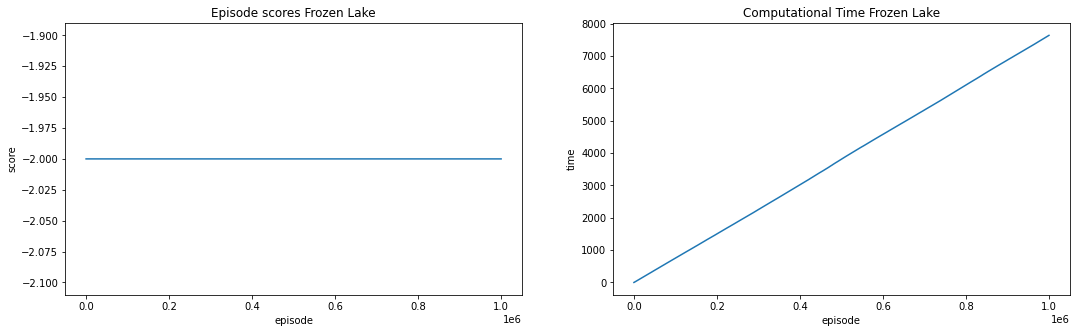

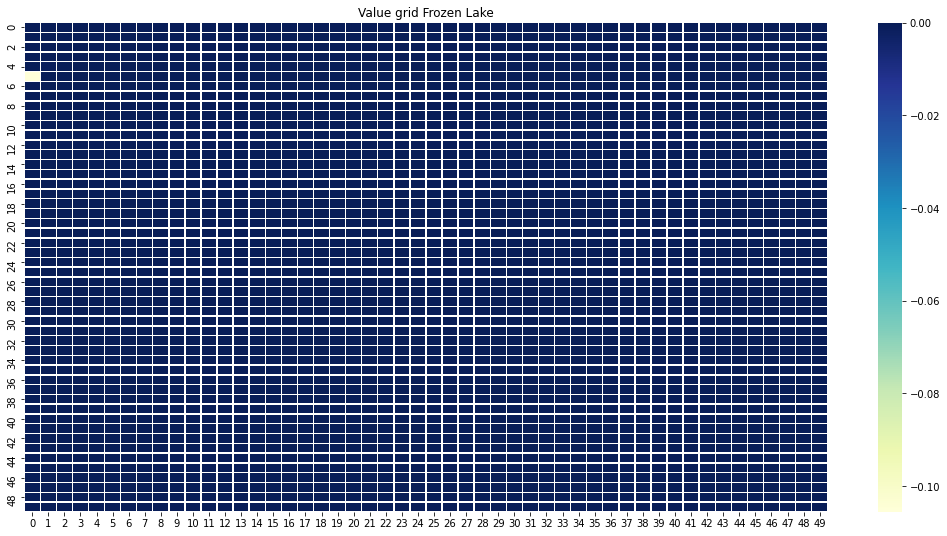

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


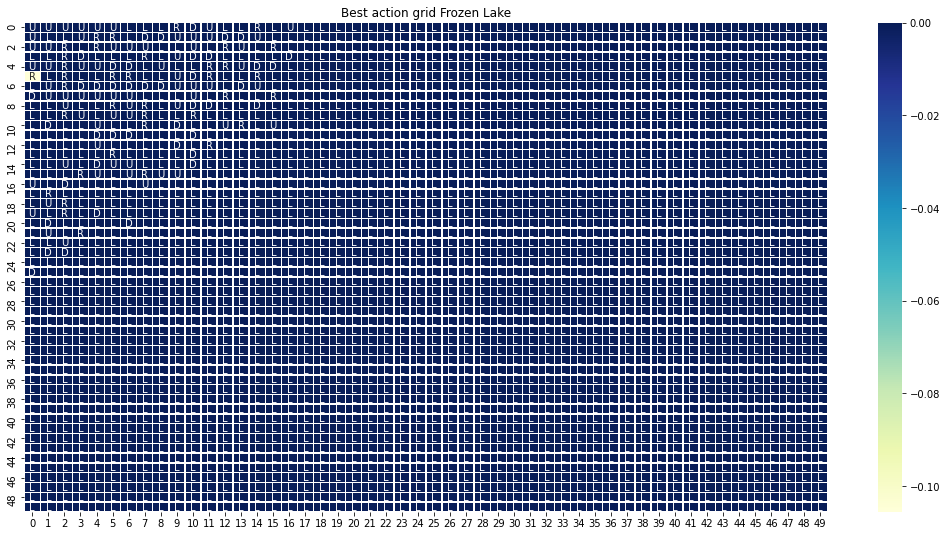

7648.4829206466675


In [81]:
start = time()
Q_large = q_learning(env_large, num_episodes=1000000, print_every=1000, learning_rate_decay= 0.5, epsilon_decay= 0.5)
print(time() - start)

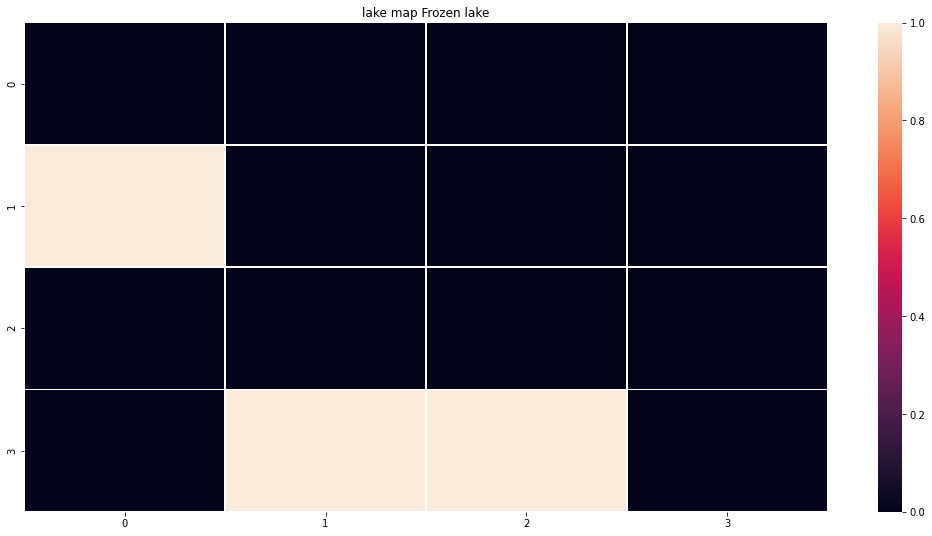

In [9]:
plot_lake(env_small,small_map)

 65%|██████▌   | 65/100 [00:00<00:00, 3524.49it/s]


took 92 iteration to converge


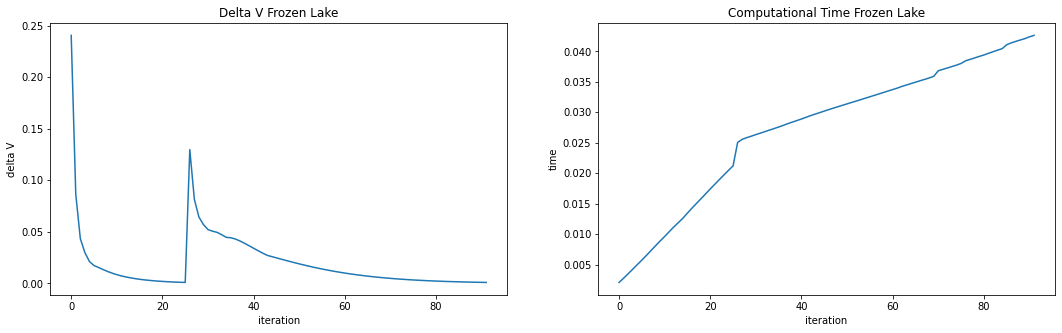

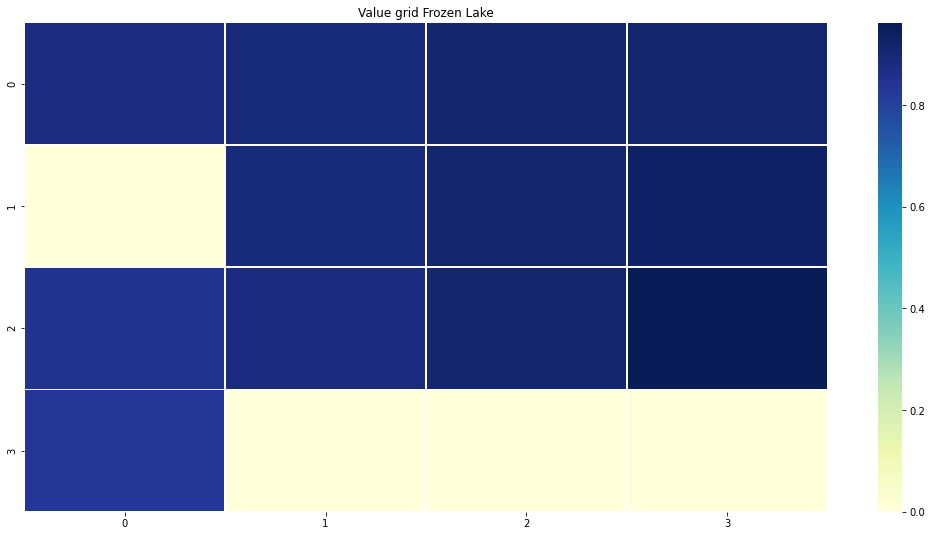

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


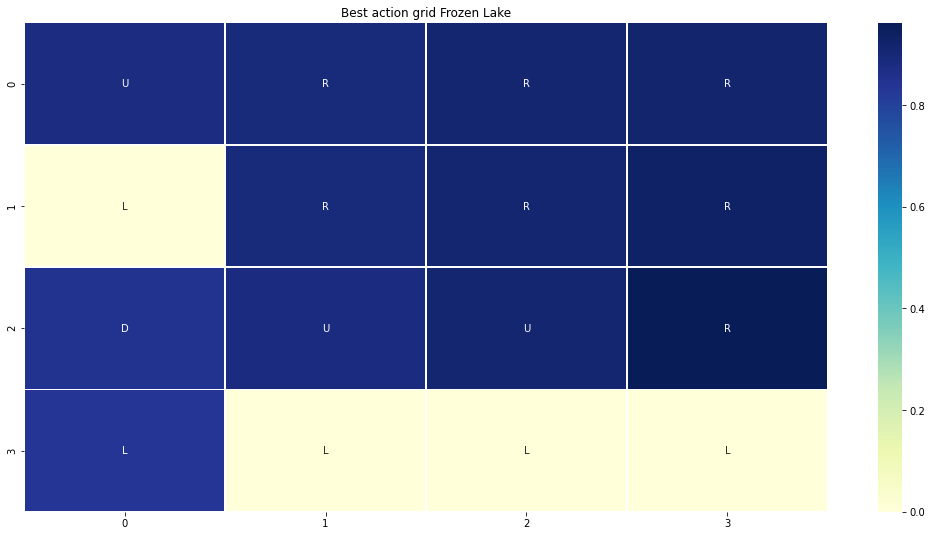

0.5090897083282471


In [35]:
start = time()
policy_iteration(env_small)
print(time() - start)

took 73 iteration to converge


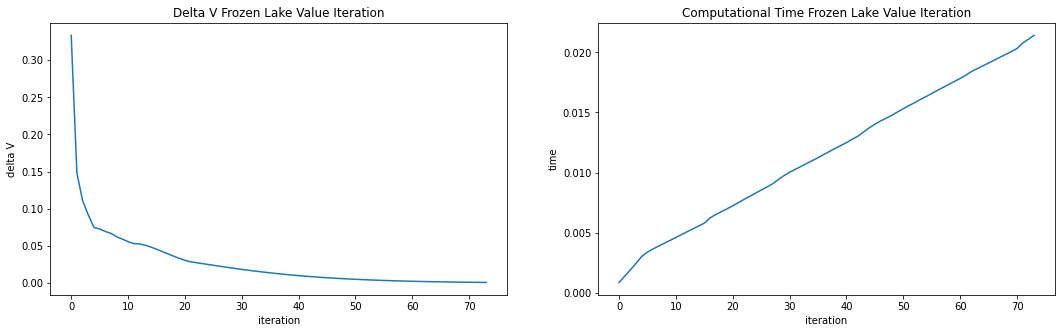

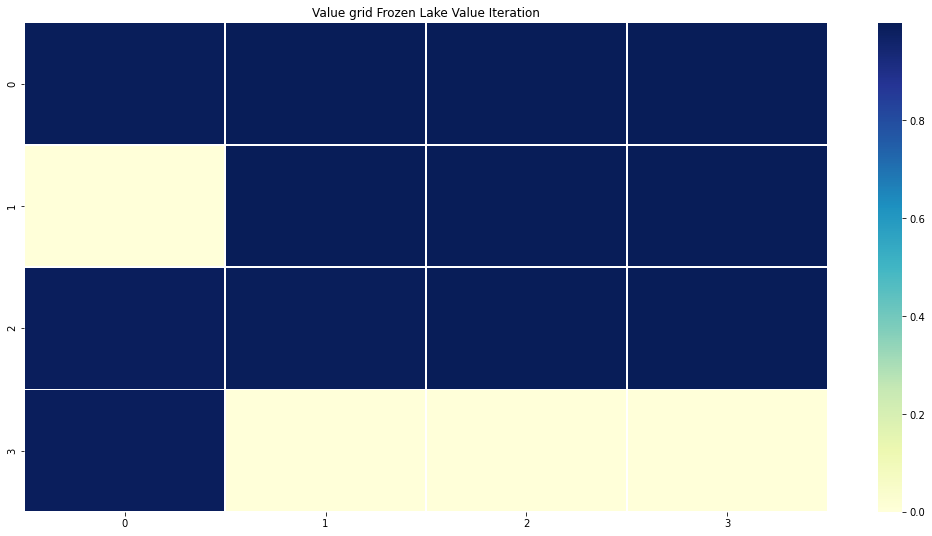

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


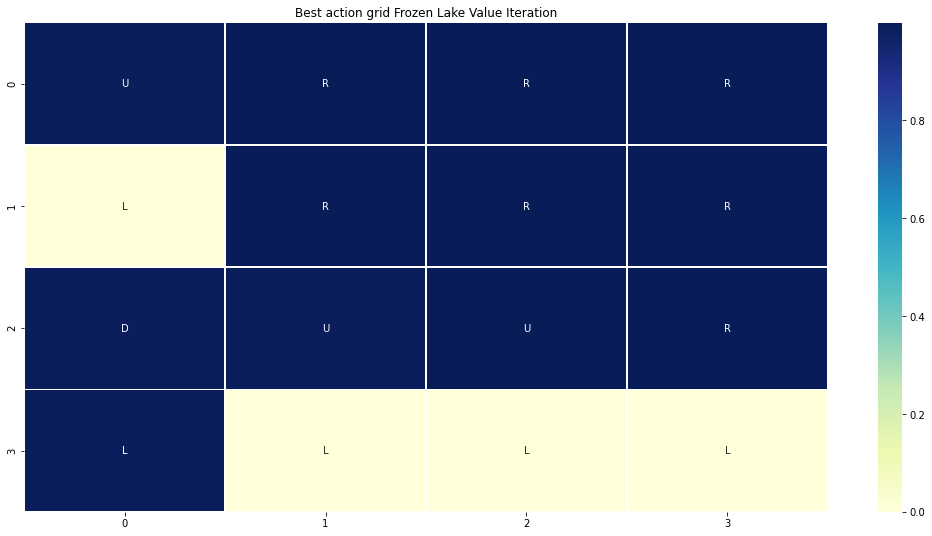

0.5671260356903076


In [10]:
start = time()
value_iteration(env_small)
print(time() - start)


Episode 100
score = 1.0000

Episode 200
score = 1.0000

Episode 300
score = 1.0000

Episode 400
score = 1.0000

Episode 500
score = 1.0000

Episode 600
score = 1.0000

Episode 700
score = 1.0000

Episode 800
score = 1.0000

Episode 900
score = 1.0000

Episode 1000
score = 1.0000


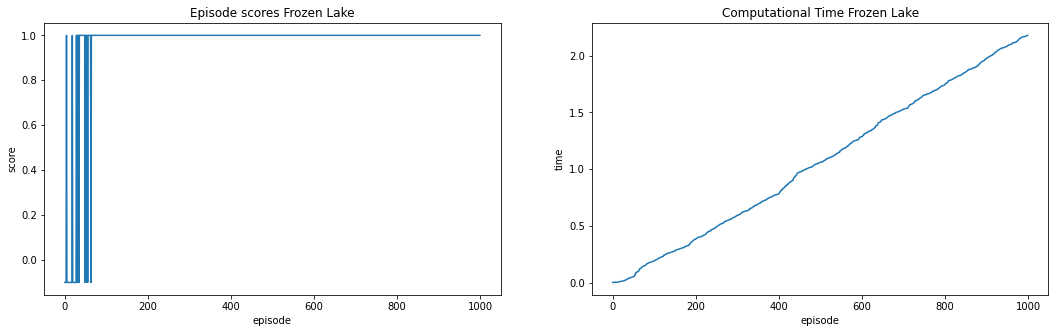

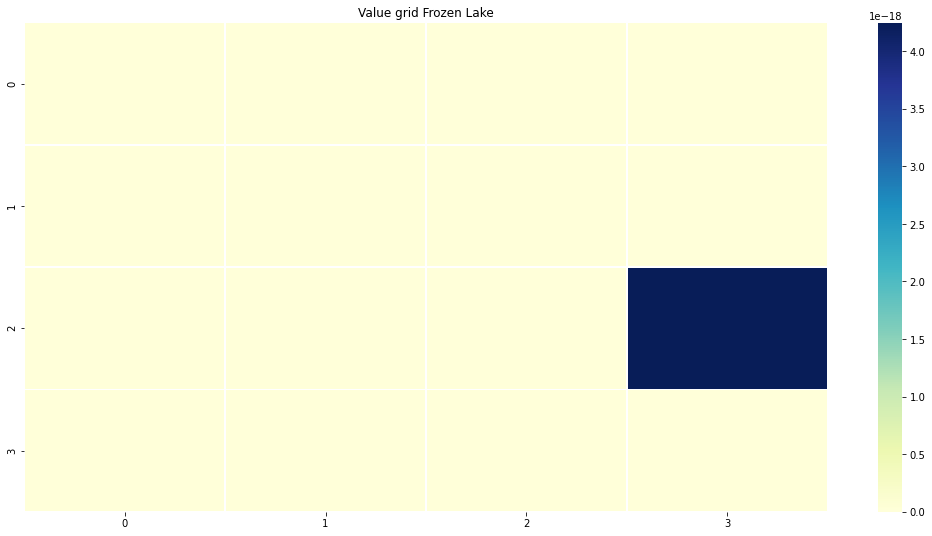

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


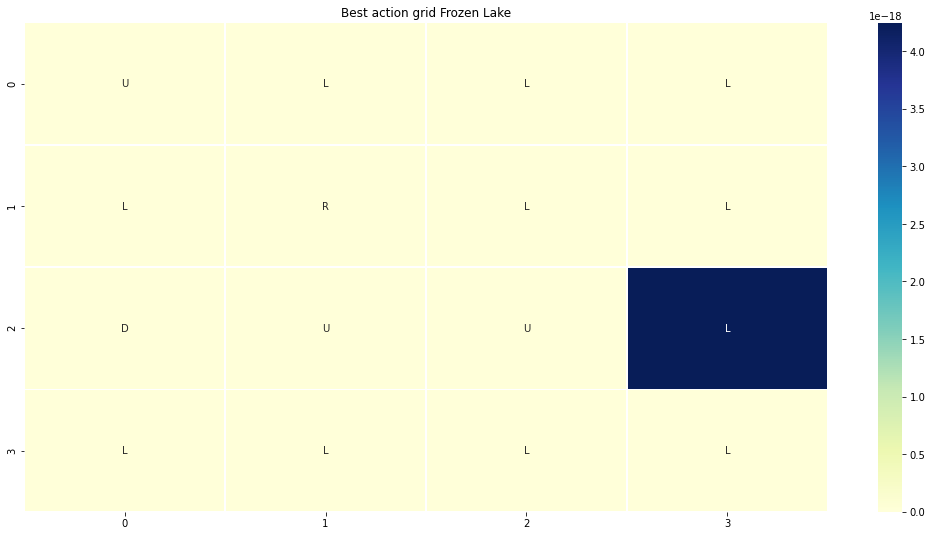

2.638259172439575


In [79]:
start = time()
V = best_Q = q_learning(env_small, num_episodes=1000, epsilon_decay=0.1, learning_rate_decay=10)
print(time() - start)

In [ ]:
env = gym.make('MountainCar-v0')
env.reset()

In [101]:
size = [4,8,10,12,14,16,18,20,22,25,30,40,50]

  0%|          | 0/13 [00:00<?, ?it/s]

took 38 iteration to converge


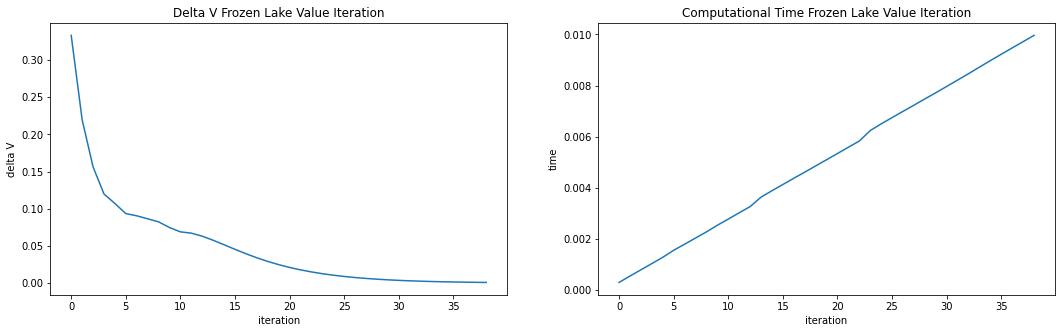

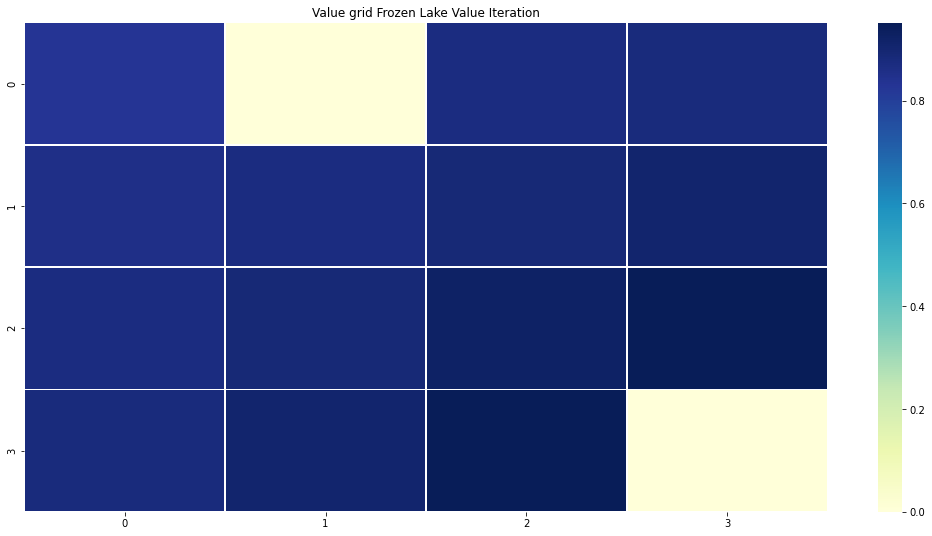

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


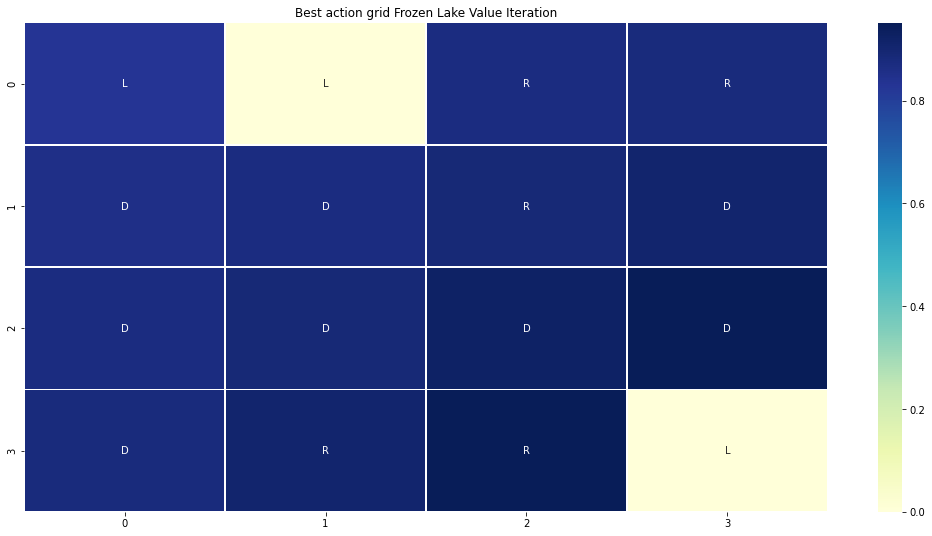

  8%|▊         | 1/13 [00:00<00:07,  1.67it/s]

took 86 iteration to converge


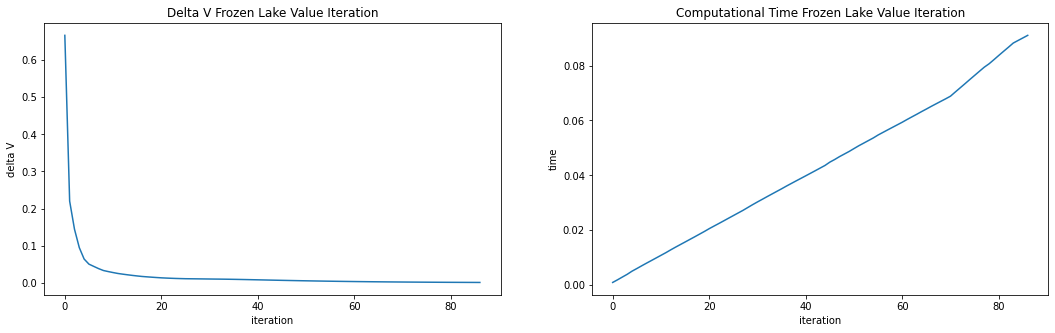

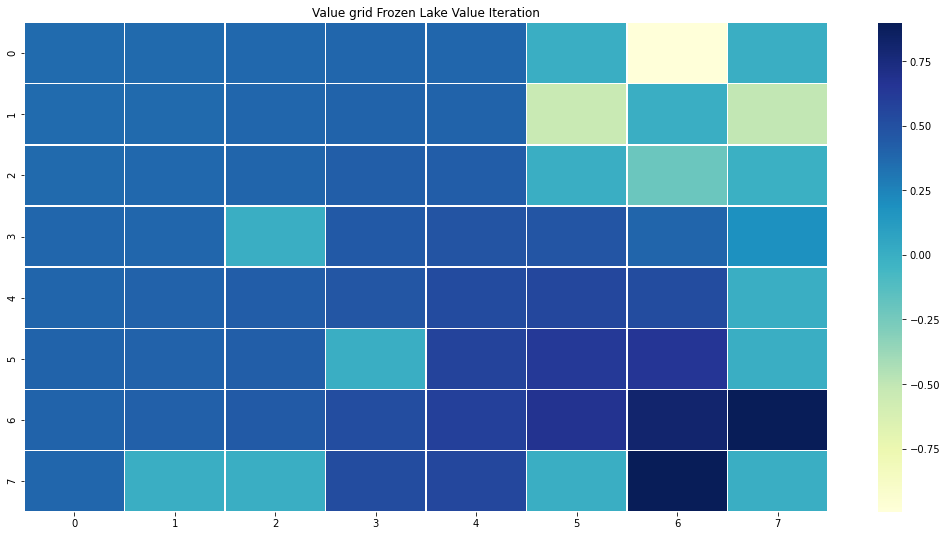

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


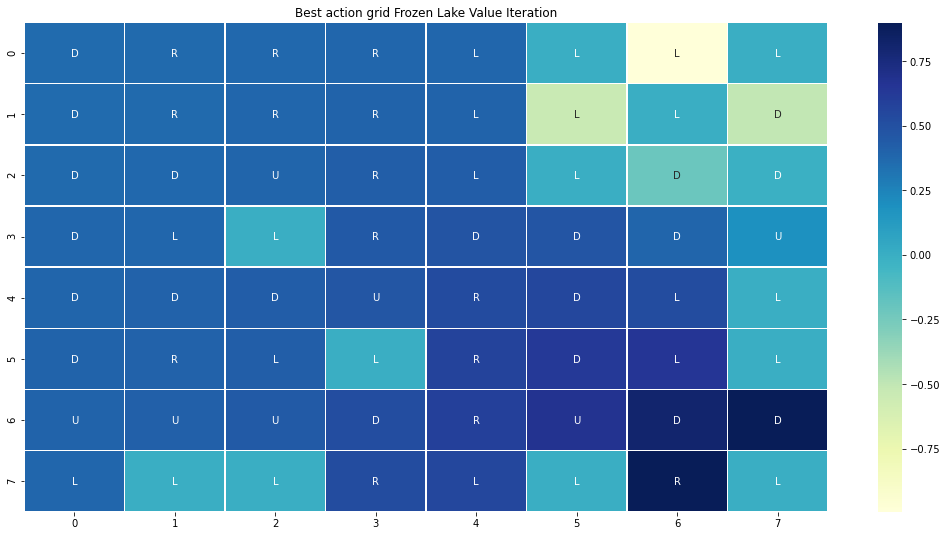

 15%|█▌        | 2/13 [00:01<00:07,  1.52it/s]

took 107 iteration to converge


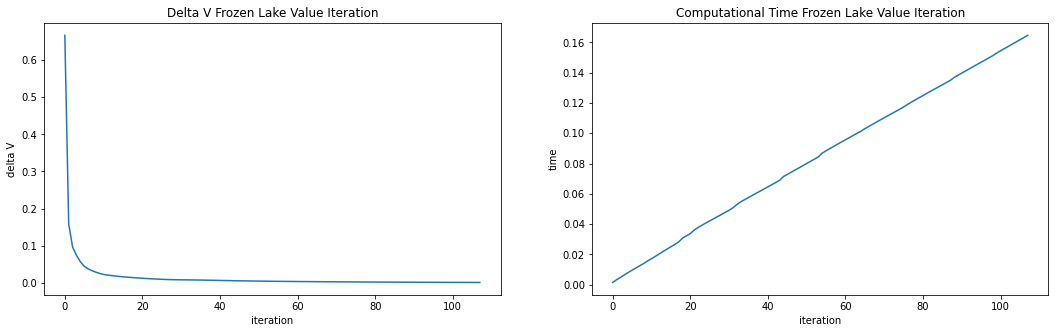

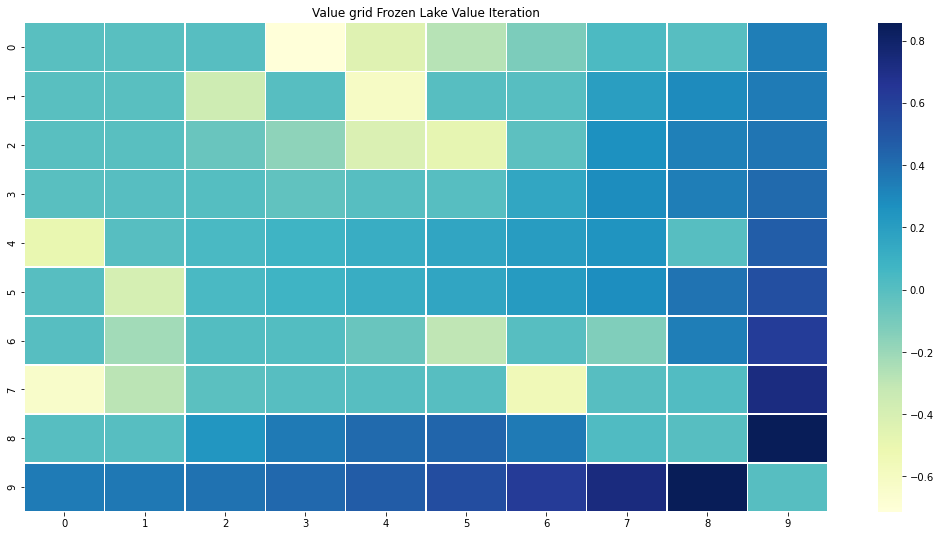

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


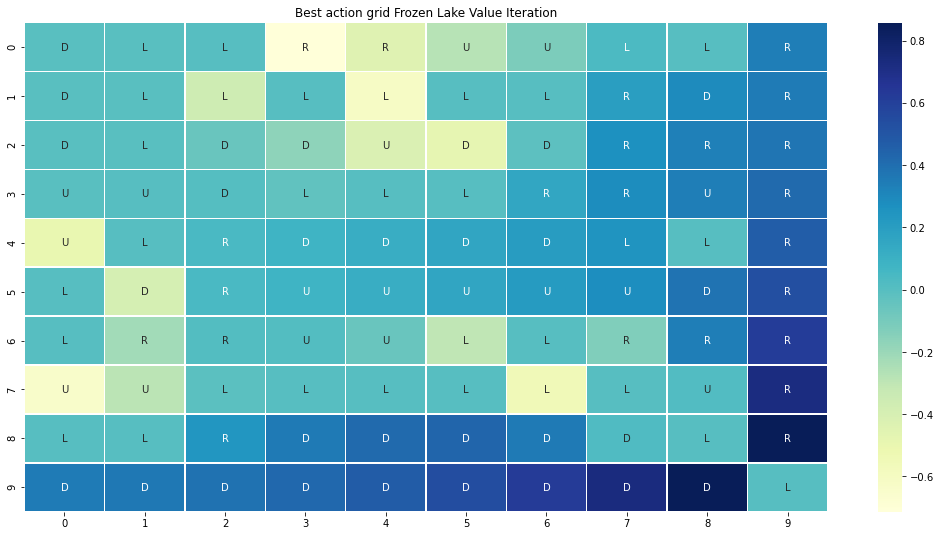

 23%|██▎       | 3/13 [00:02<00:07,  1.31it/s]

took 121 iteration to converge


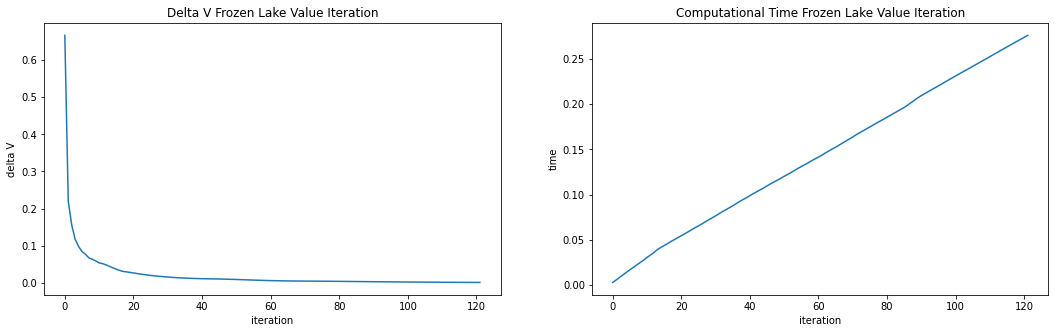

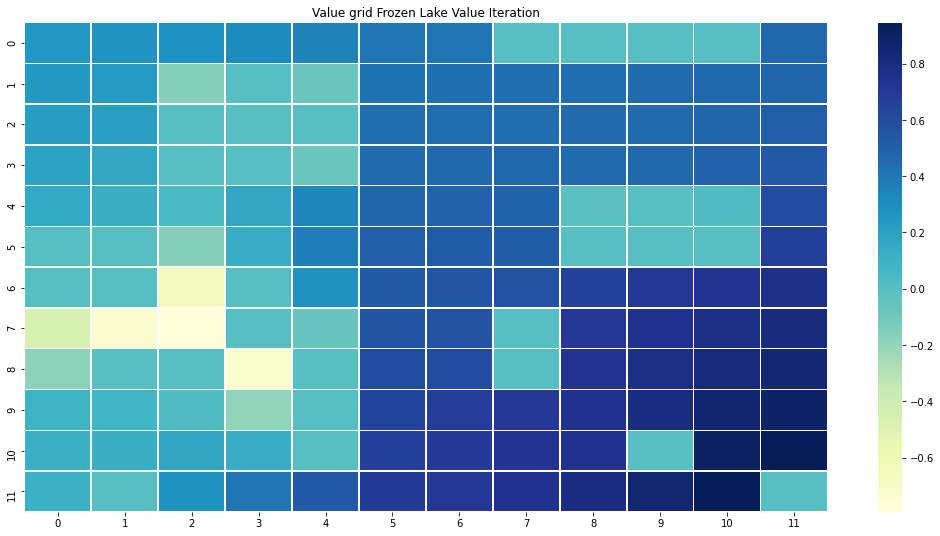

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


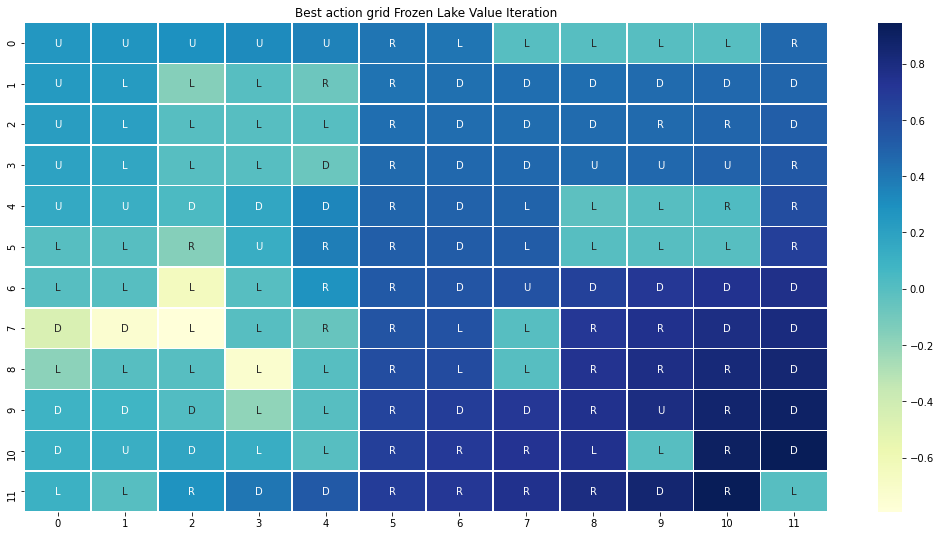

 31%|███       | 4/13 [00:03<00:08,  1.10it/s]

took 82 iteration to converge


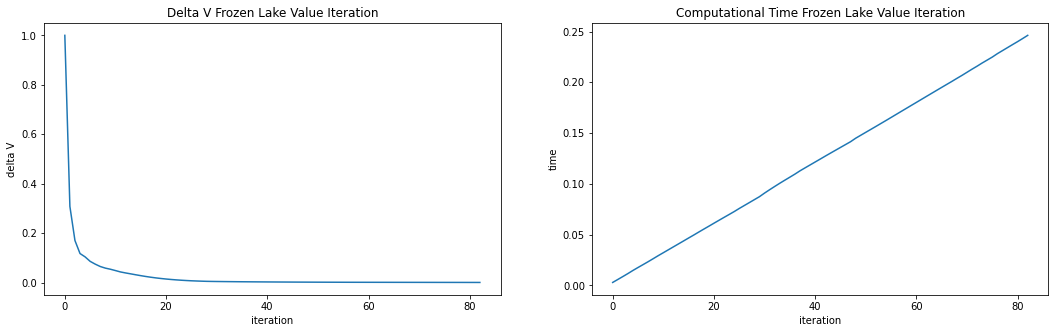

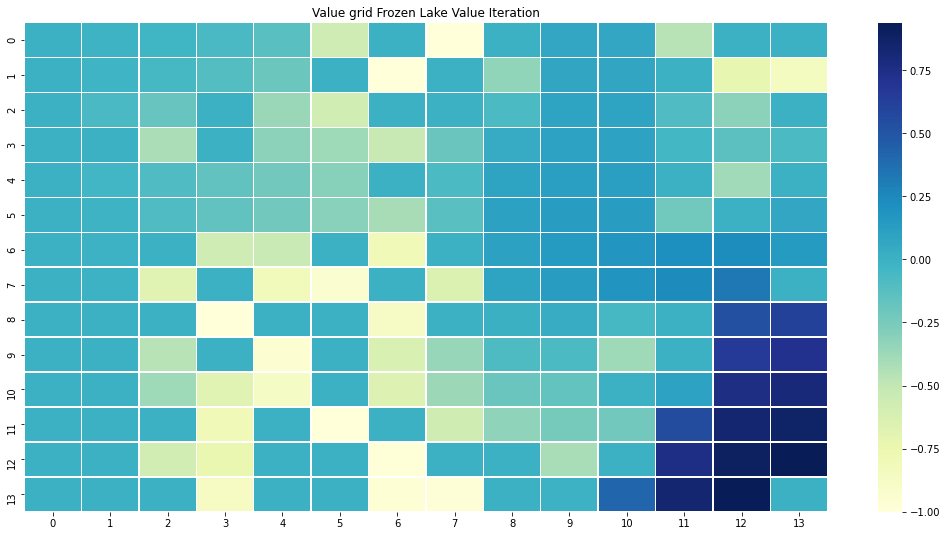

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


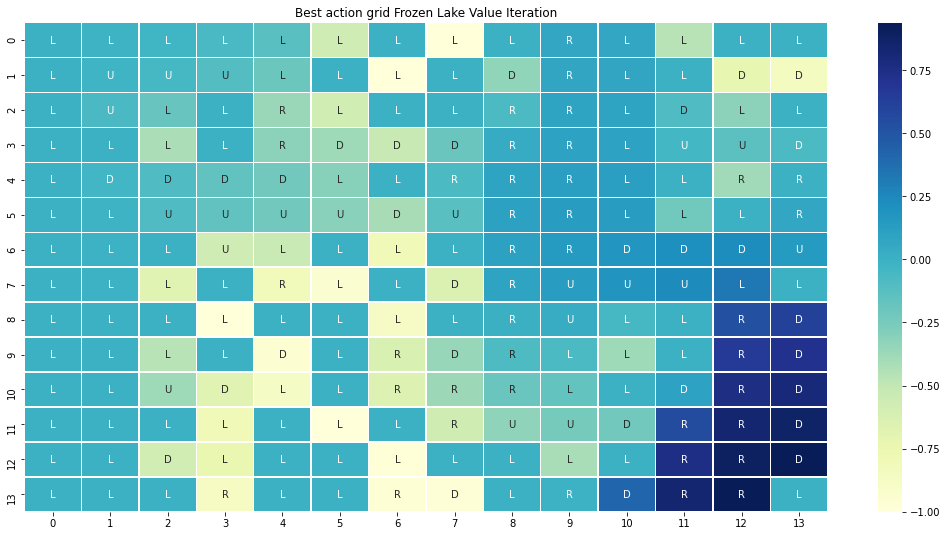

 38%|███▊      | 5/13 [00:05<00:08,  1.09s/it]

took 101 iteration to converge


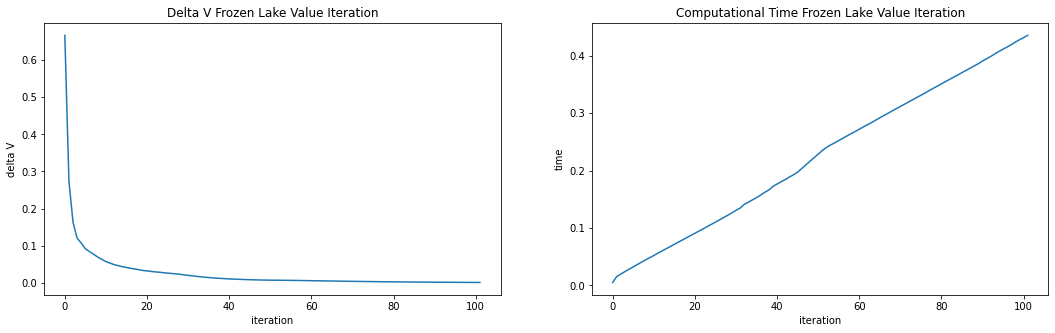

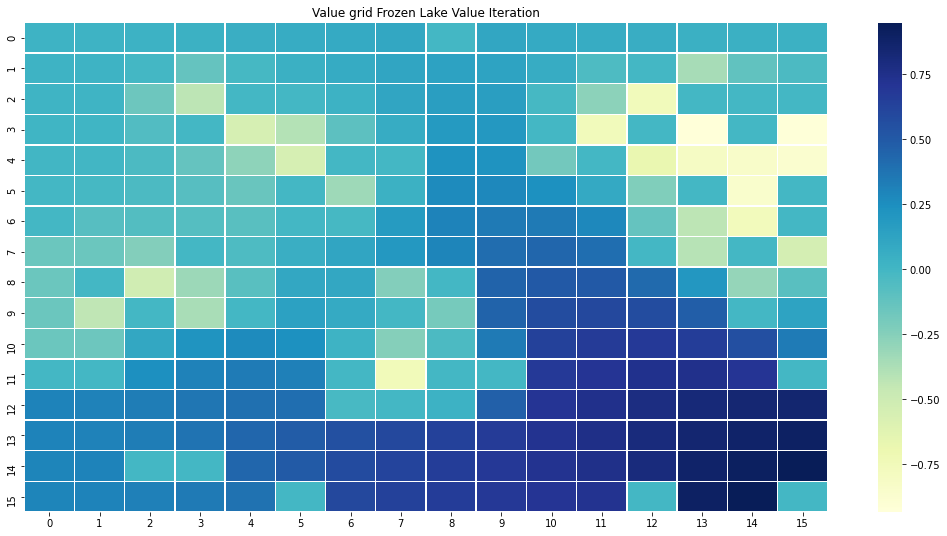

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


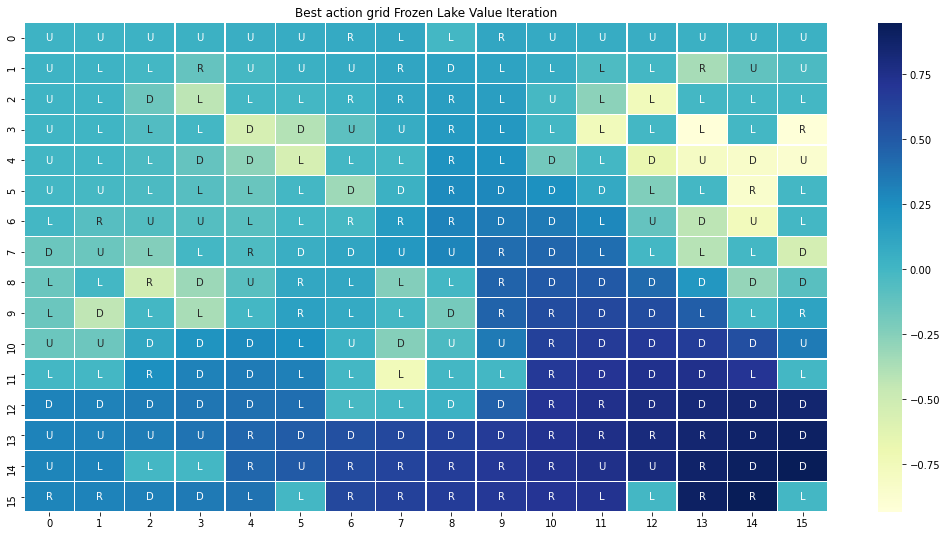

 46%|████▌     | 6/13 [00:06<00:09,  1.30s/it]

took 104 iteration to converge


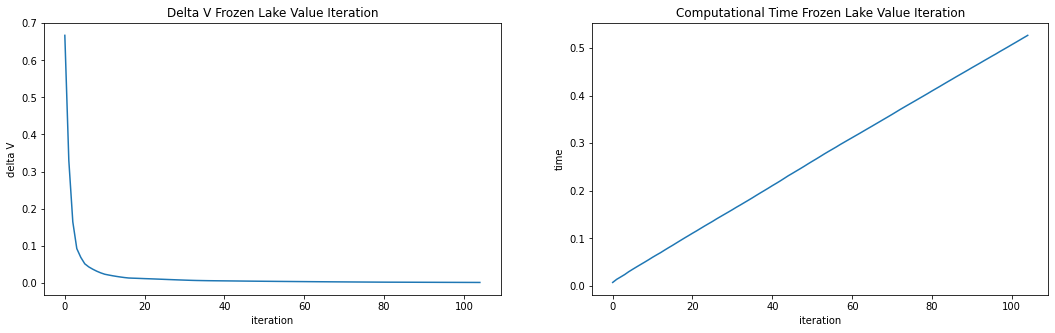

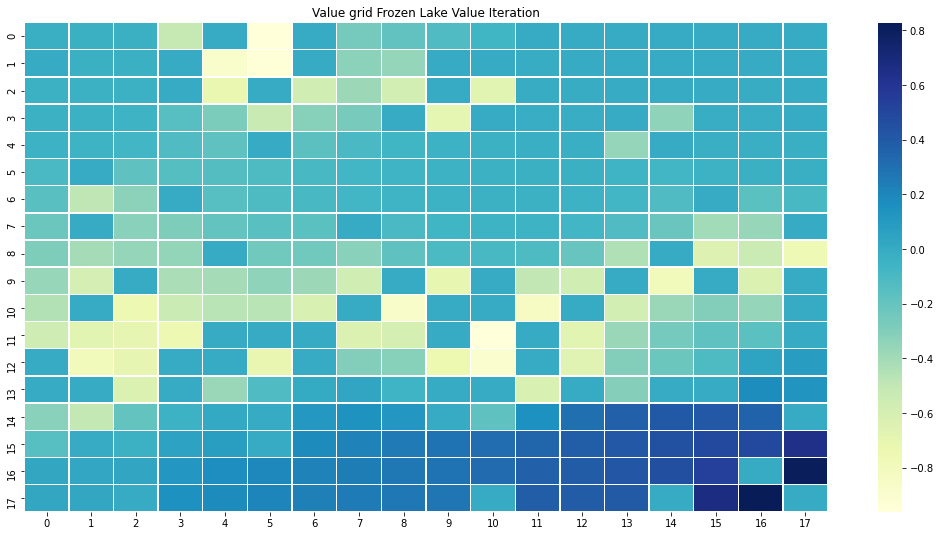

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


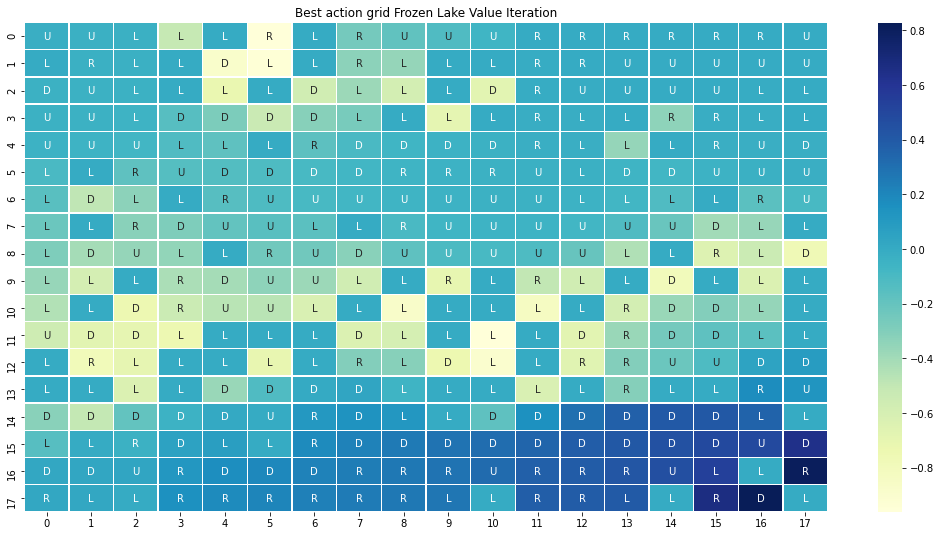

 54%|█████▍    | 7/13 [00:09<00:09,  1.57s/it]

took 53 iteration to converge


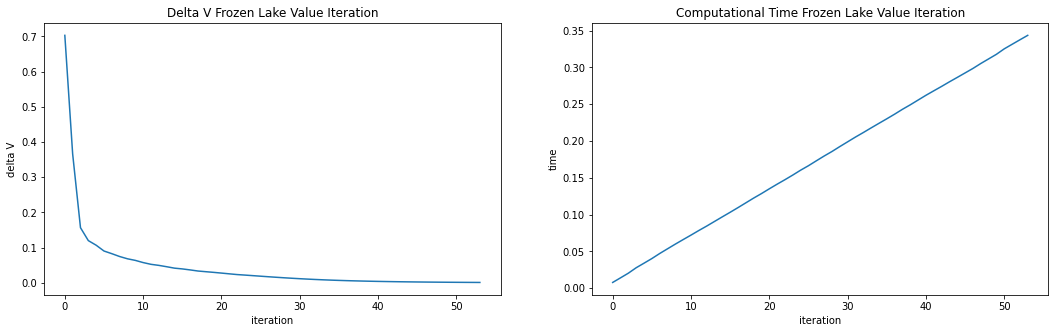

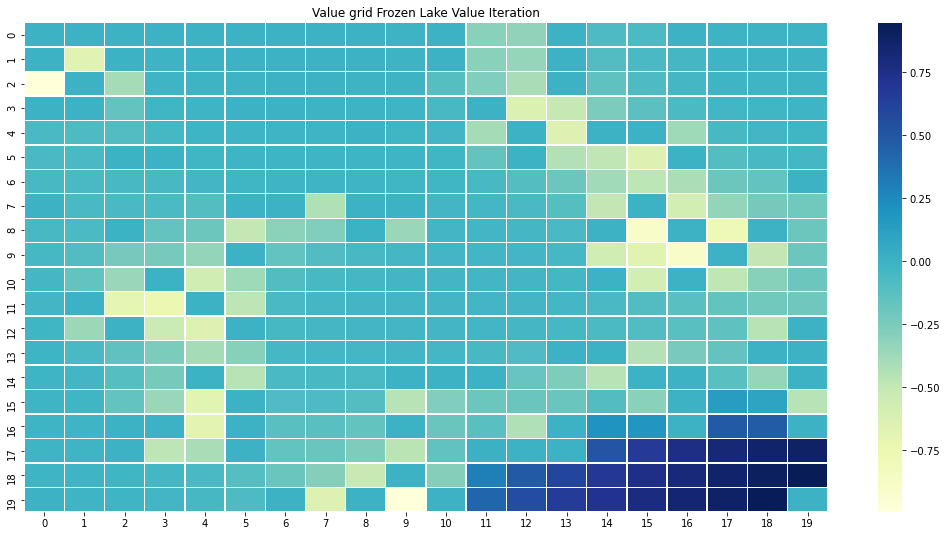

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


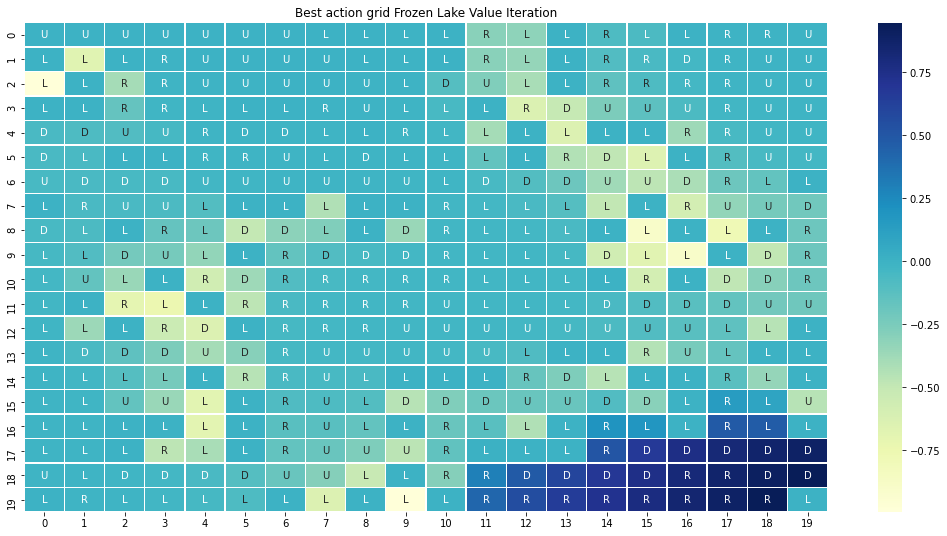

 62%|██████▏   | 8/13 [00:11<00:08,  1.76s/it]

took 85 iteration to converge


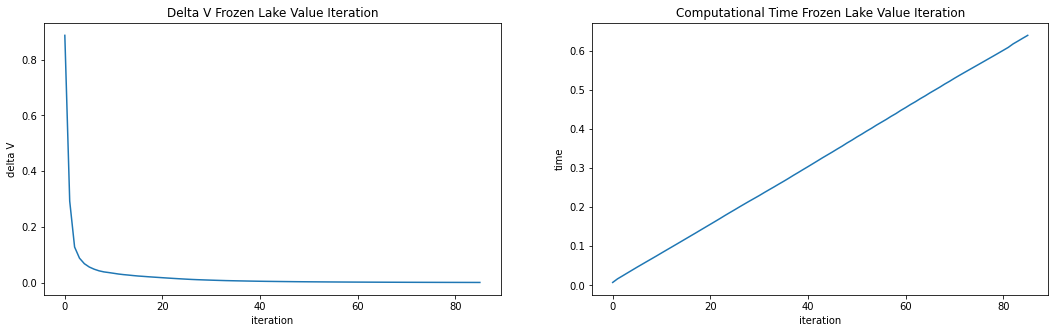

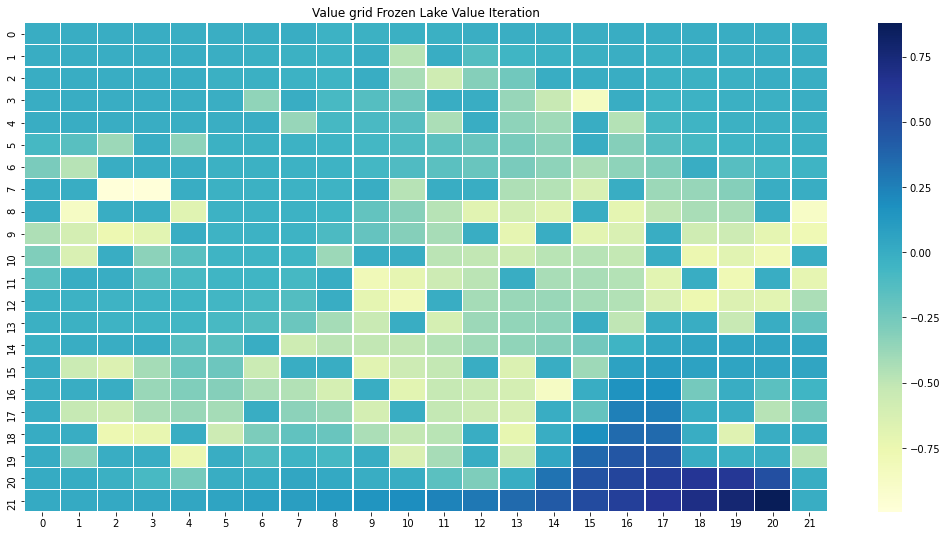

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


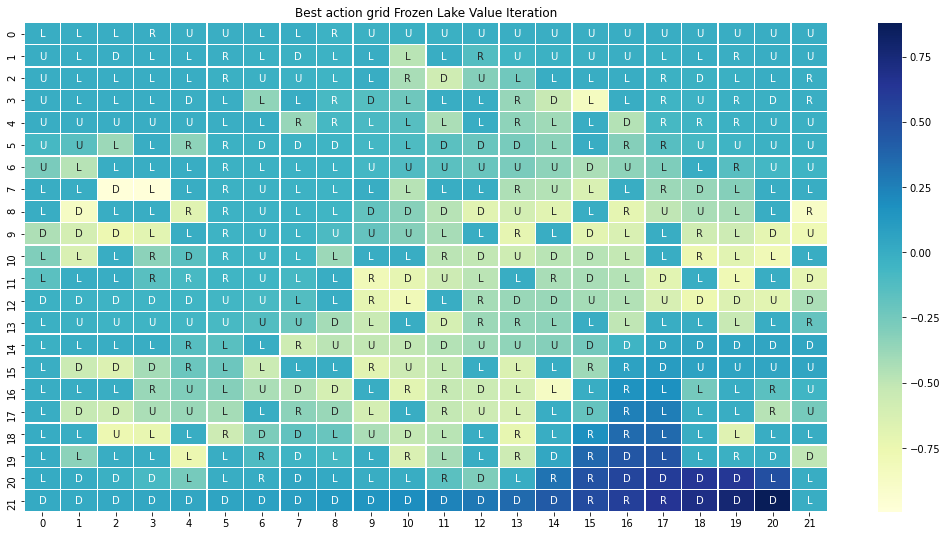

 69%|██████▉   | 9/13 [00:14<00:08,  2.09s/it]

took 101 iteration to converge


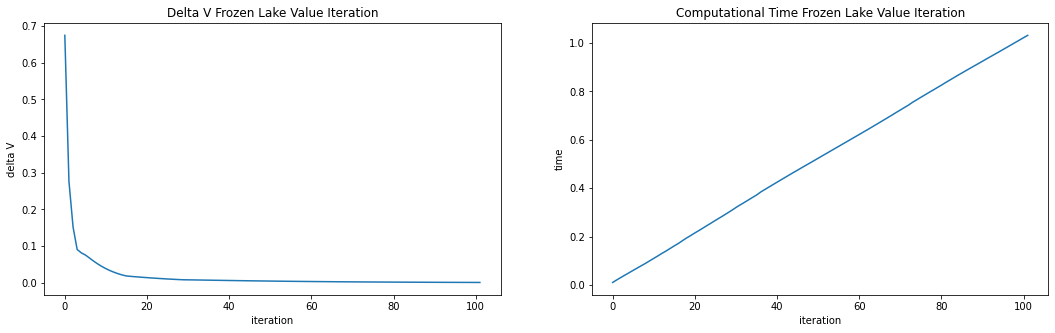

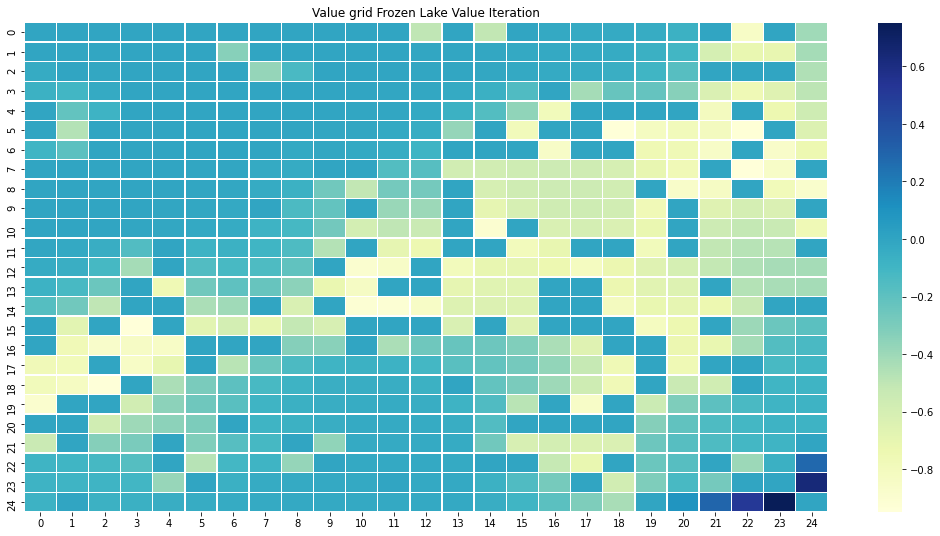

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


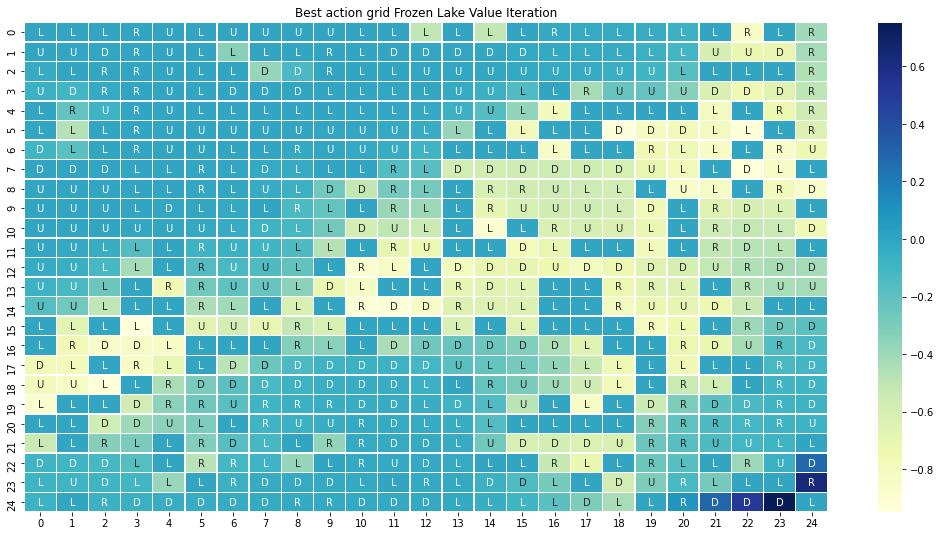

 77%|███████▋  | 10/13 [00:17<00:07,  2.57s/it]

took 86 iteration to converge


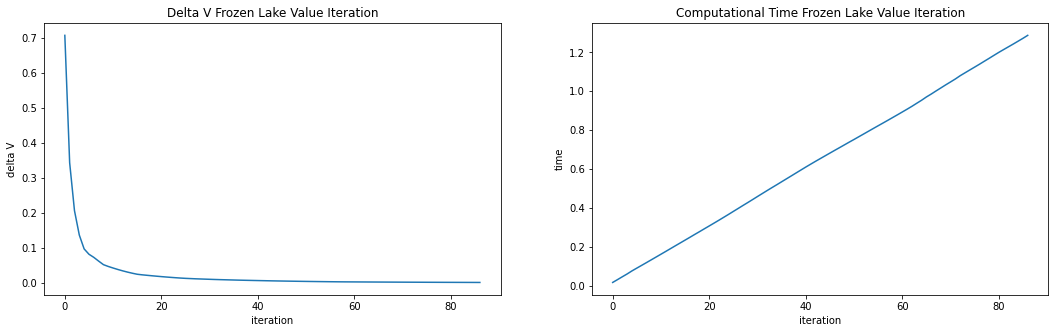

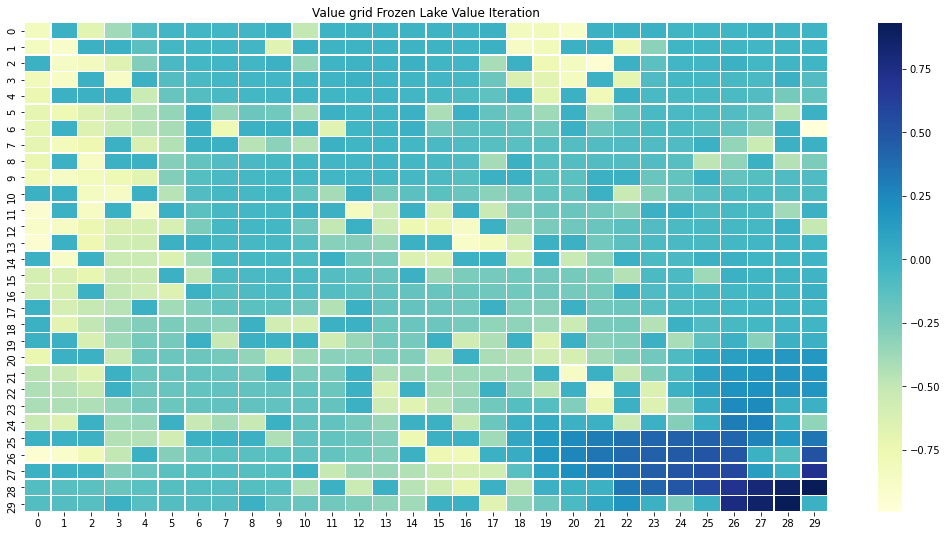

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


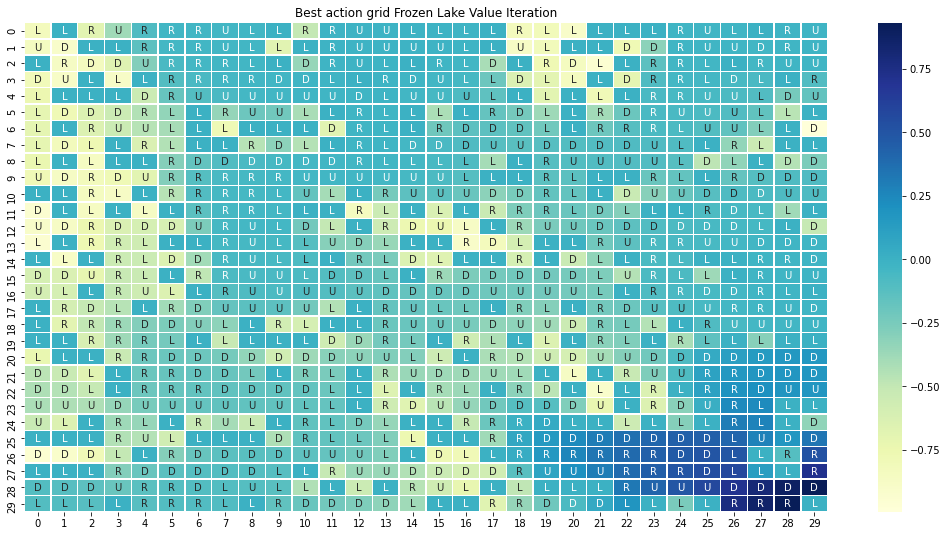

 85%|████████▍ | 11/13 [00:22<00:06,  3.22s/it]

took 85 iteration to converge


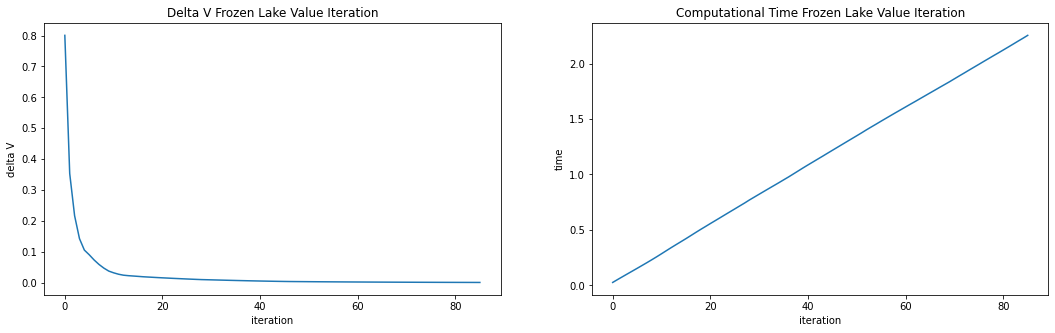

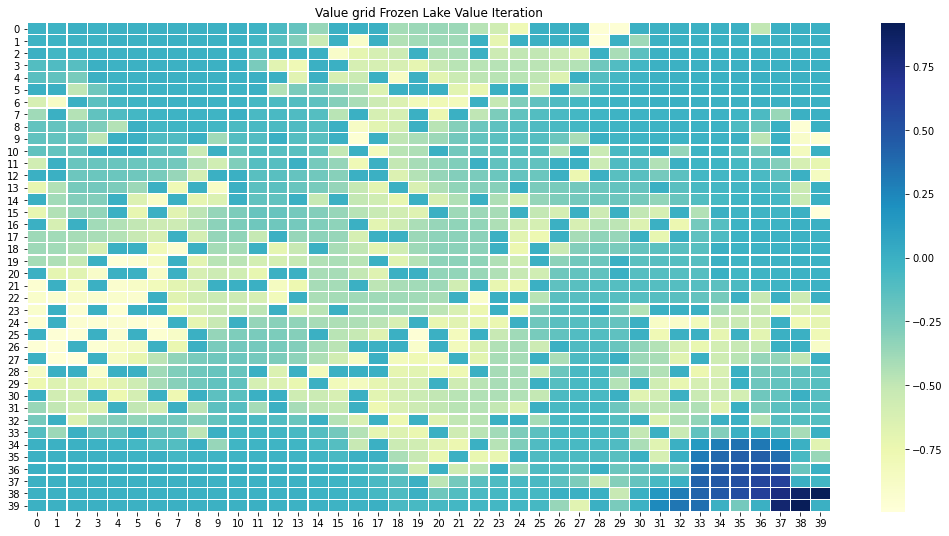

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


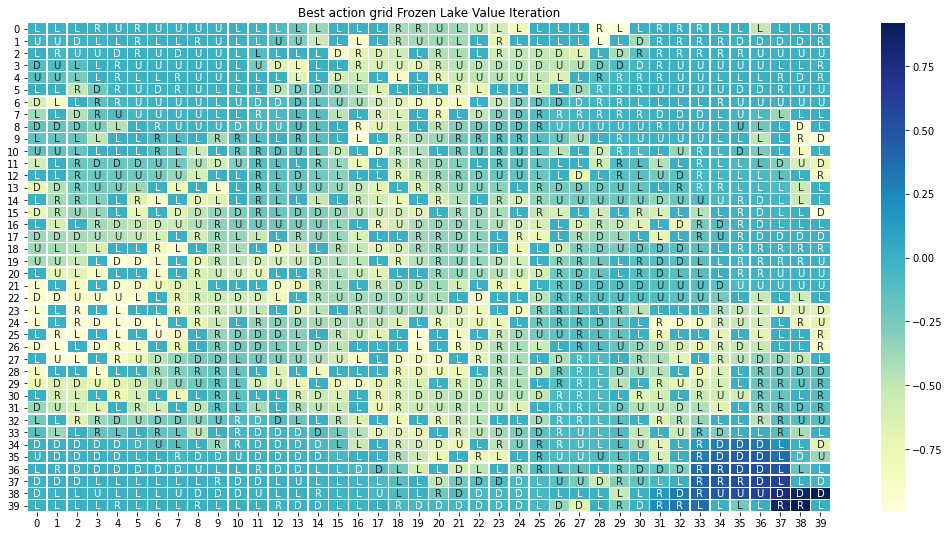

 92%|█████████▏| 12/13 [00:30<00:04,  4.67s/it]

took 81 iteration to converge


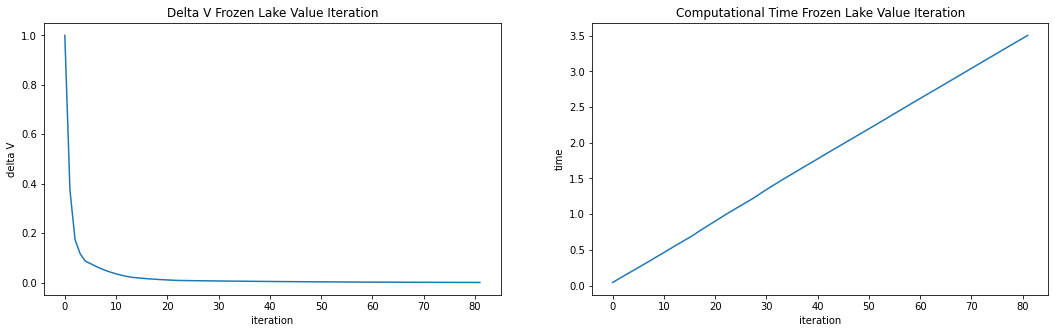

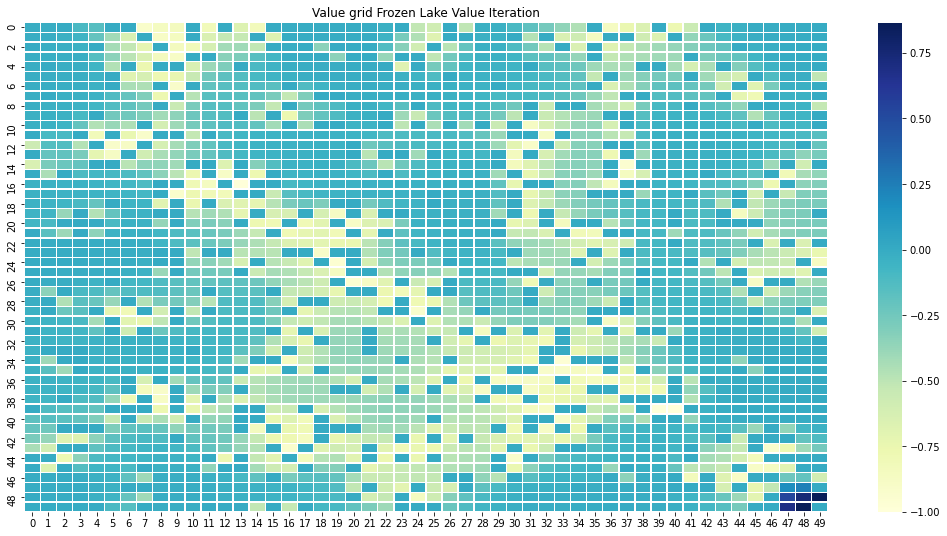

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


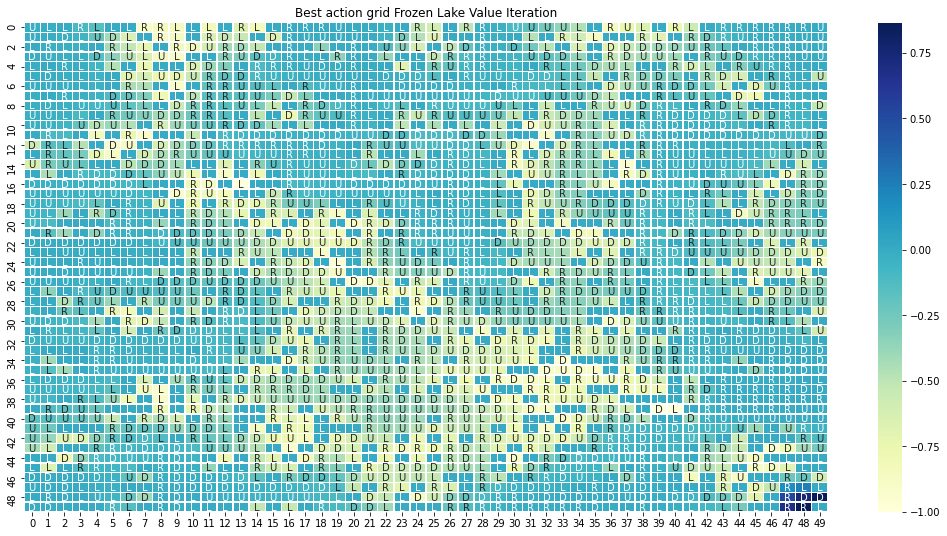

100%|██████████| 13/13 [00:42<00:00,  3.24s/it]


In [86]:
value_iteration_time_with_size = []
for s in tqdm(size):
    env = FrozenLakeEnv(desc=generate_random_map(size=s, p=0.8), neg_rew=-1)
    start = time()
    value_iteration(env)
    value_iteration_time_with_size.append(time() - start)
    

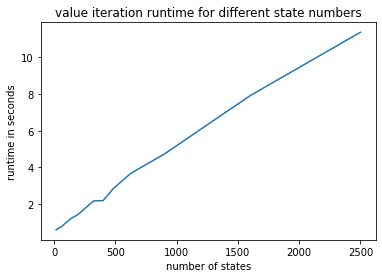

In [100]:
plt.plot(np.square(size),value_iteration_time_with_size)
plt.title('value iteration runtime for different state numbers')
plt.xlabel('number of states')
plt.ylabel('runtime in seconds')
plt.show()

 22%|██▏       | 22/100 [00:00<00:00, 3058.59it/s]

 71%|███████   | 71/100 [00:00<00:00, 3107.44it/s]

took 95 iteration to converge


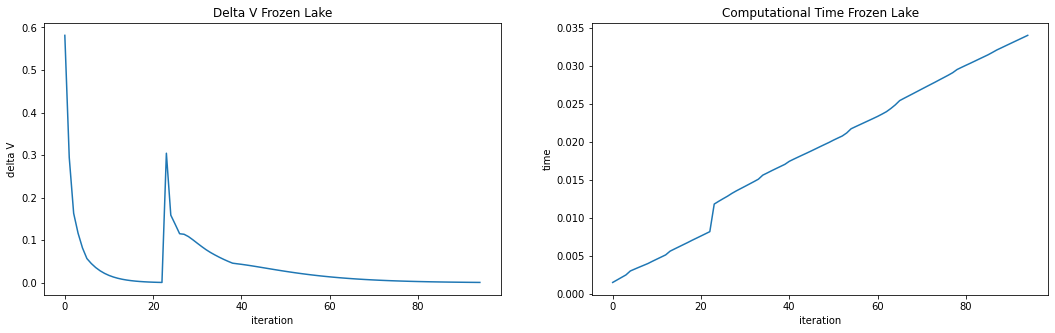

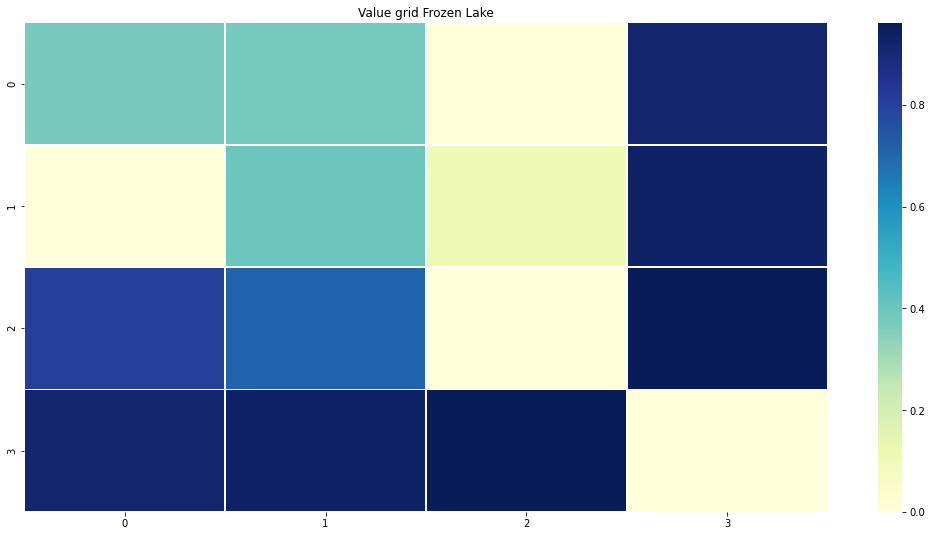

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


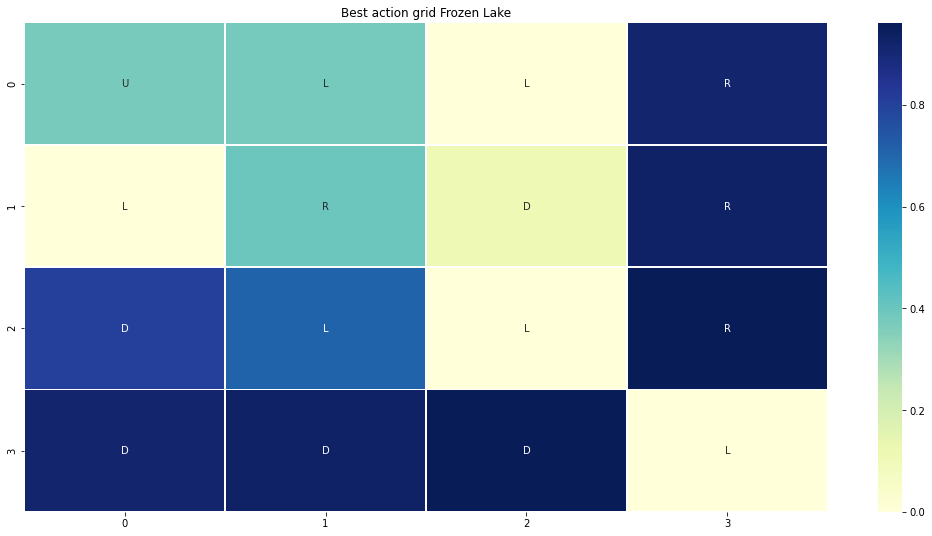

 58%|█████▊    | 58/100 [00:00<00:00, 739.16it/s]

100%|██████████| 100/100 [00:00<00:00, 787.61it/s][A

 99%|█████████▉| 99/100 [00:00<00:00, 821.89it/s]

 43%|████▎     | 43/100 [00:00<00:00, 843.85it/s]

  6%|▌         | 6/100 [00:00<00:00, 673.50it/s]


took 310 iteration to converge


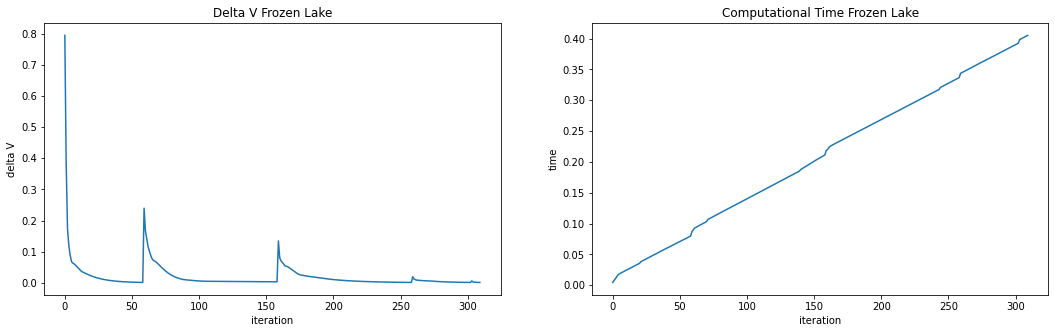

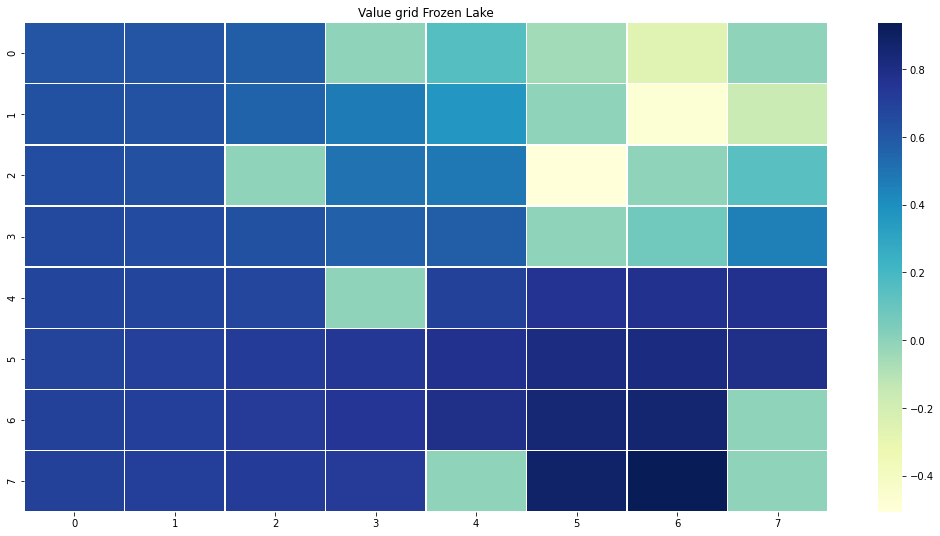

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


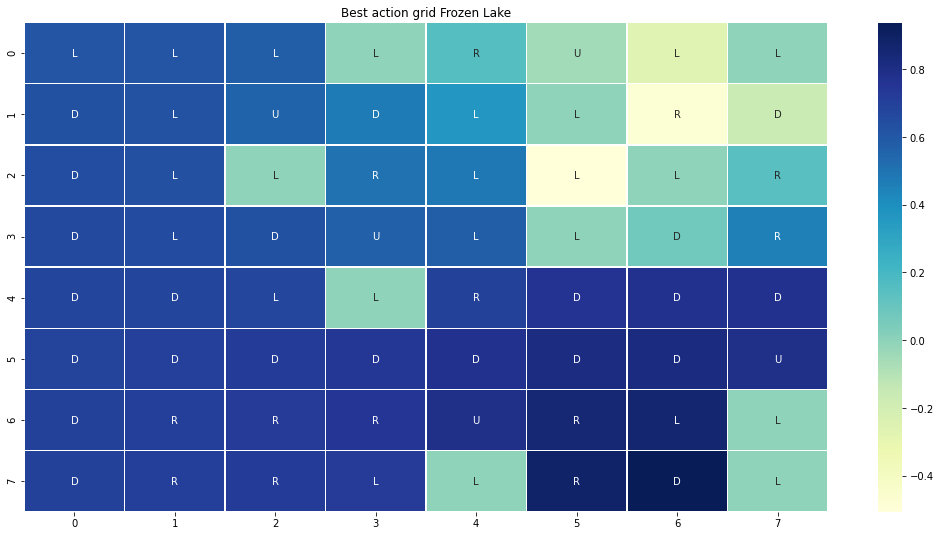

 38%|███▊      | 38/100 [00:00<00:00, 479.97it/s]

100%|██████████| 100/100 [00:00<00:00, 559.16it/s][A

 86%|████████▌ | 86/100 [00:00<00:00, 530.30it/s]

 76%|███████▌  | 76/100 [00:00<00:00, 511.43it/s]


took 303 iteration to converge


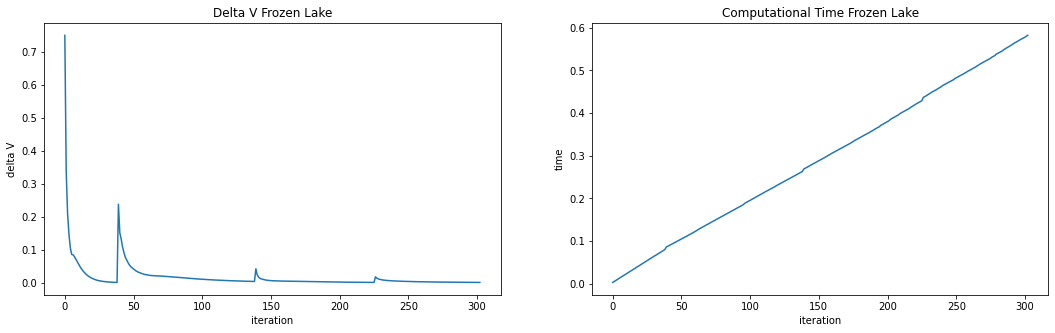

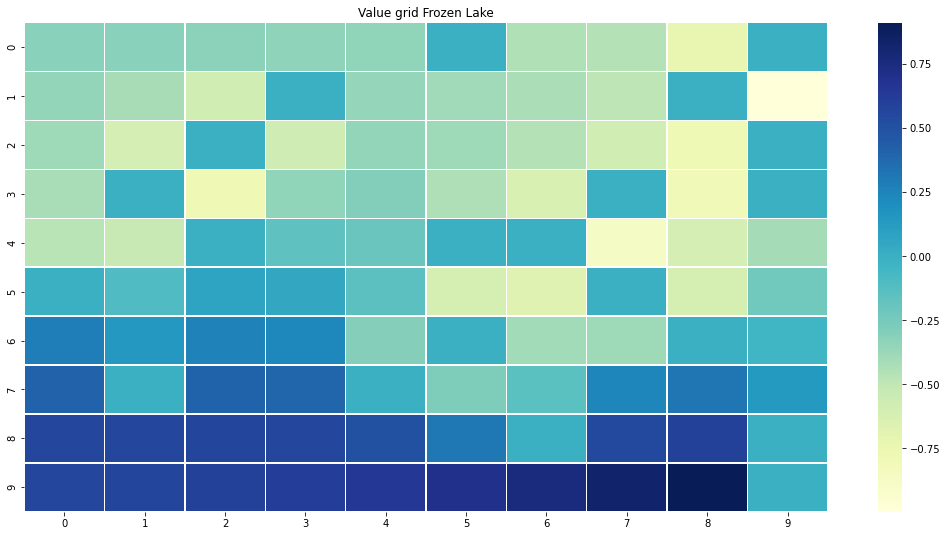

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


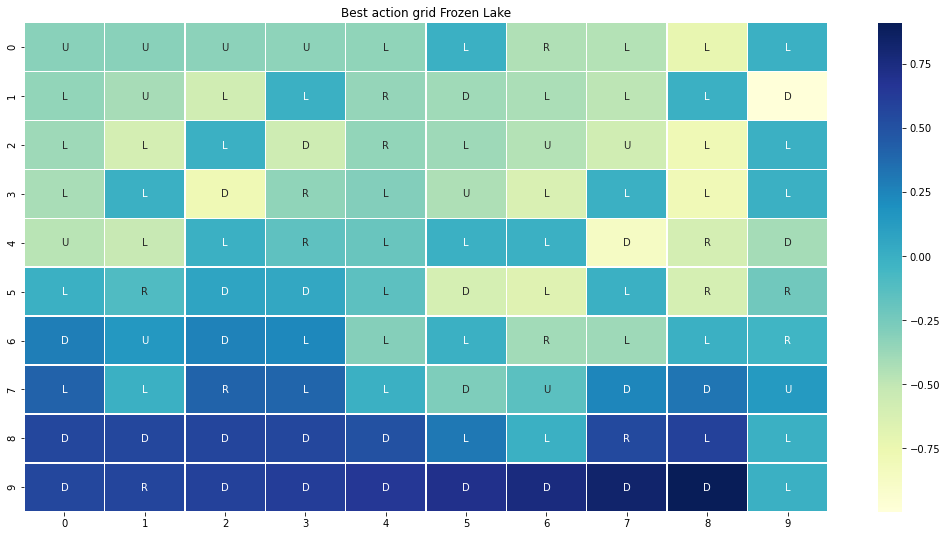

 33%|███▎      | 33/100 [00:00<00:00, 341.16it/s]

100%|██████████| 100/100 [00:00<00:00, 357.85it/s][A

100%|██████████| 100/100 [00:00<00:00, 382.50it/s][A

 38%|███▊      | 38/100 [00:00<00:00, 358.57it/s]


took 273 iteration to converge


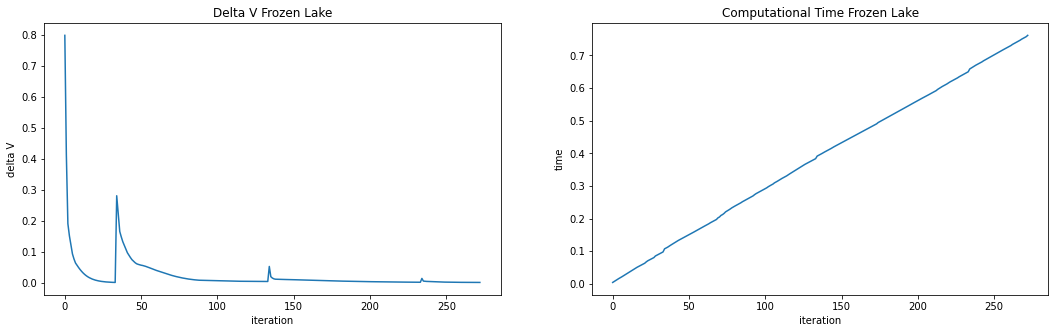

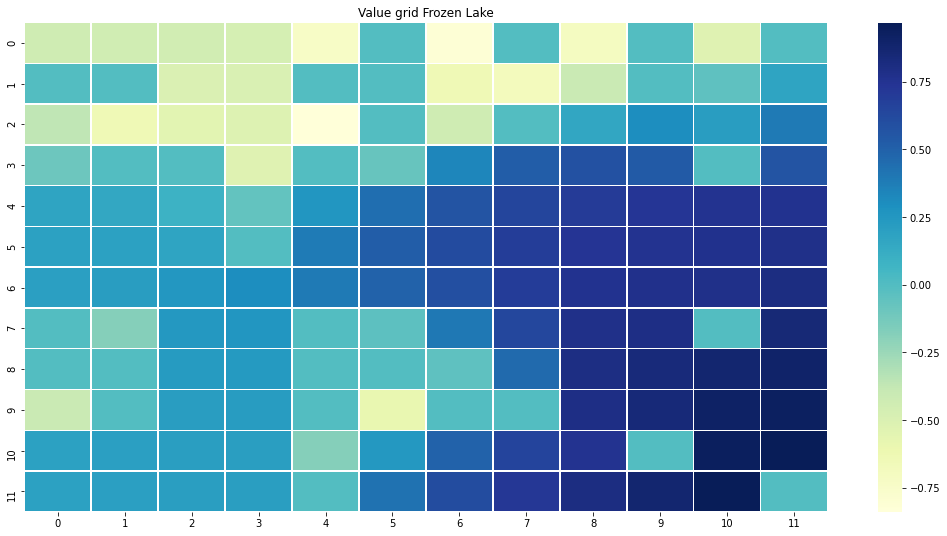

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


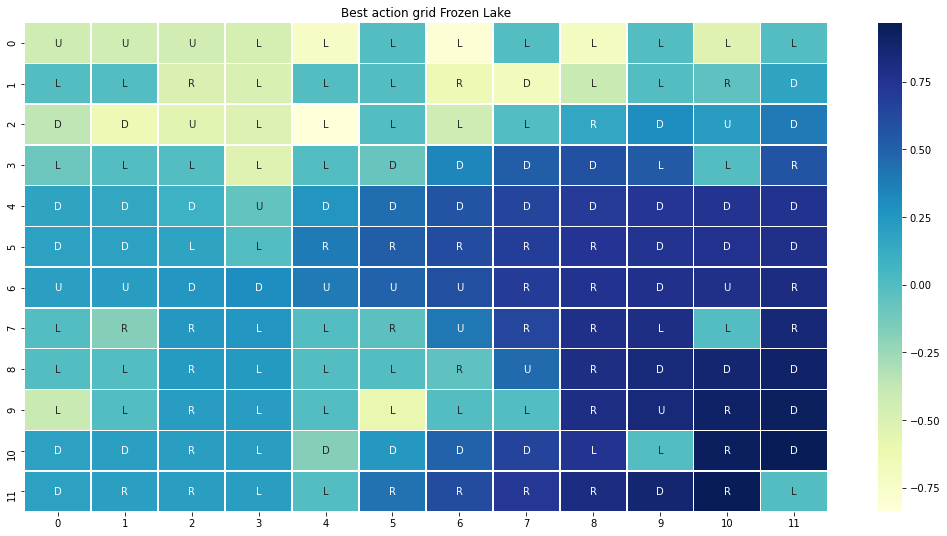

 35%|███▌      | 35/100 [00:00<00:00, 266.09it/s]

100%|██████████| 100/100 [00:00<00:00, 271.69it/s][A

 89%|████████▉ | 89/100 [00:00<00:00, 284.89it/s]

 11%|█         | 11/100 [00:00<00:00, 244.27it/s]


took 238 iteration to converge


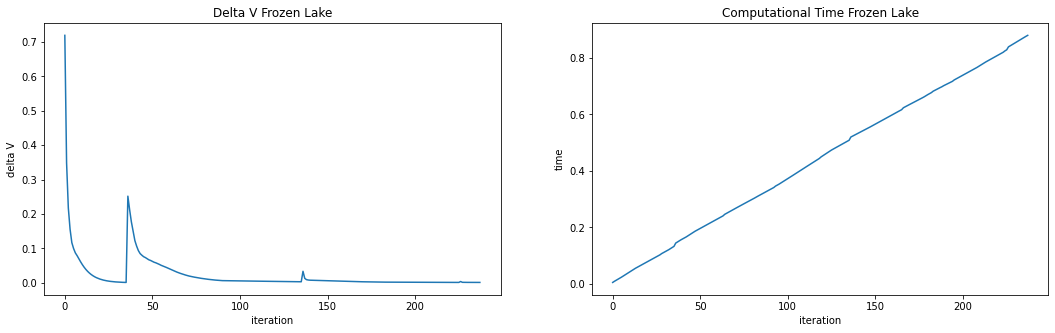

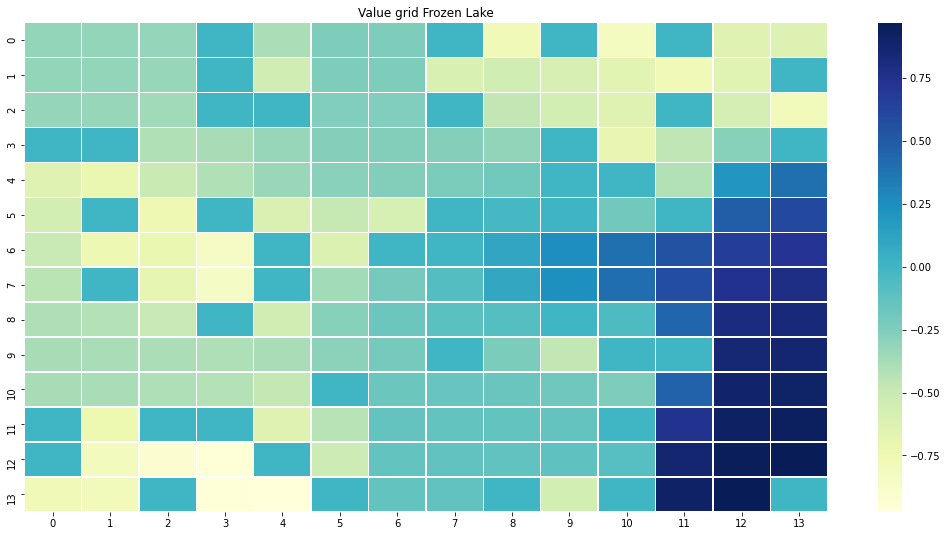

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


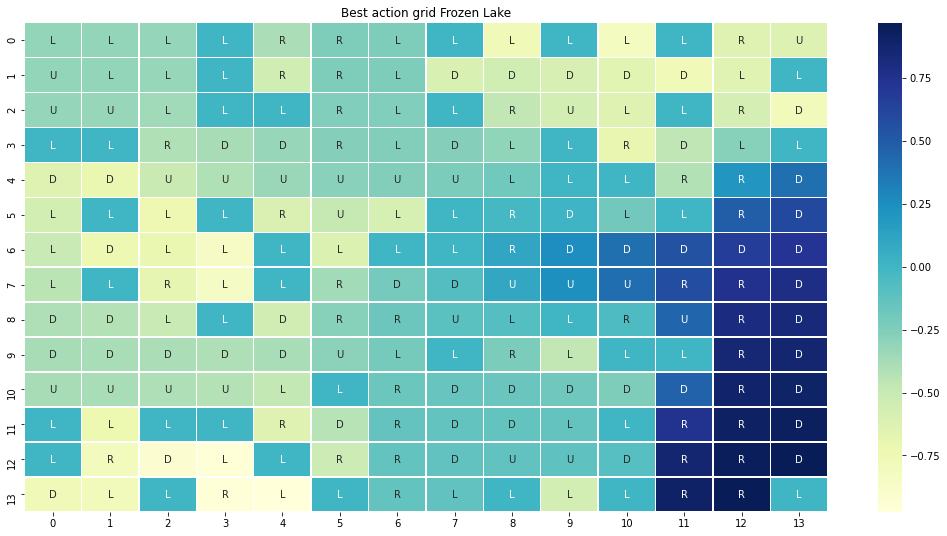

 37%|███▋      | 37/100 [00:00<00:00, 207.32it/s]

100%|██████████| 100/100 [00:00<00:00, 212.29it/s][A

100%|██████████| 100/100 [00:00<00:00, 216.75it/s][A

 44%|████▍     | 44/100 [00:00<00:00, 208.41it/s]

  9%|▉         | 9/100 [00:00<00:00, 193.78it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


took 297 iteration to converge


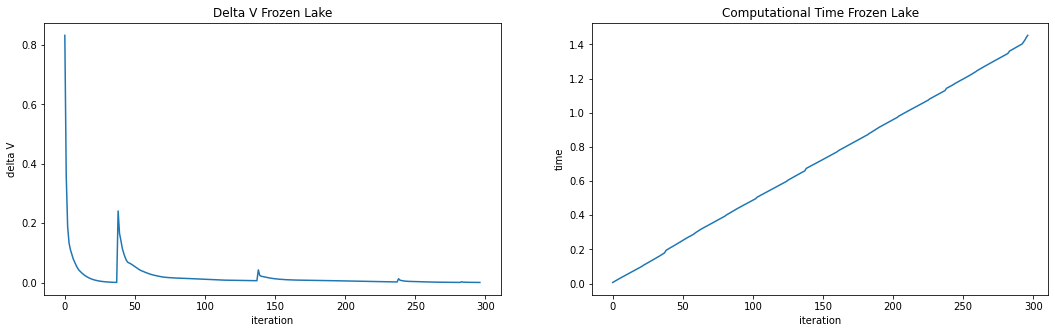

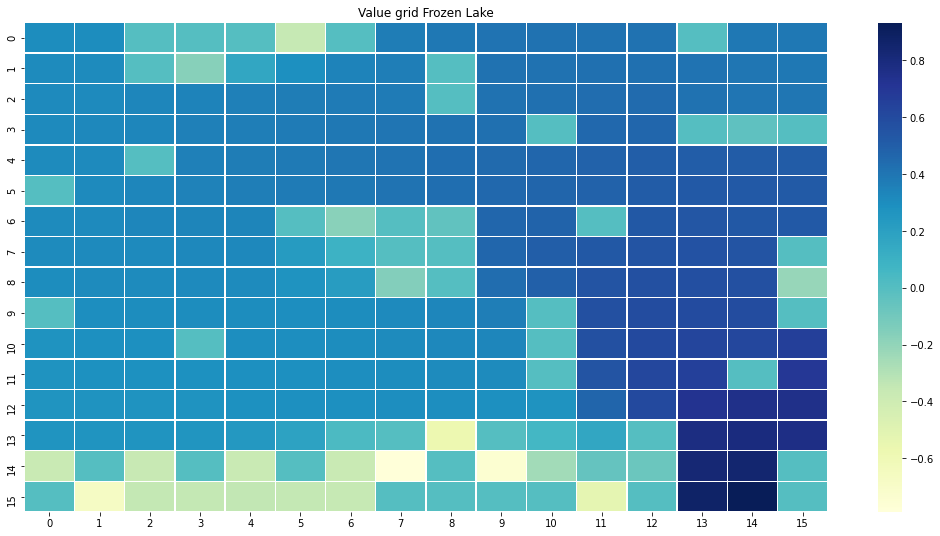

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


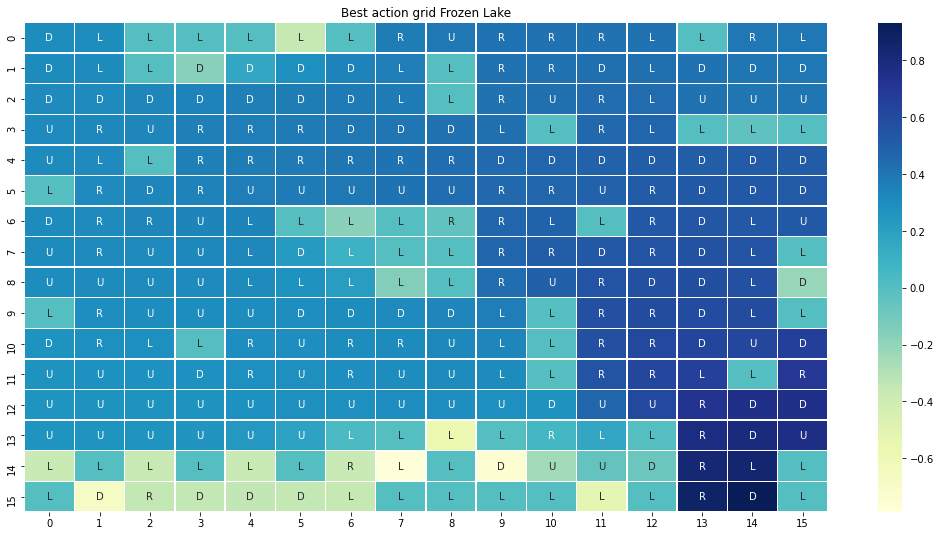

 34%|███▍      | 34/100 [00:00<00:00, 167.66it/s]

100%|██████████| 100/100 [00:00<00:00, 172.35it/s][A

100%|██████████| 100/100 [00:00<00:00, 174.25it/s][A

 89%|████████▉ | 89/100 [00:00<00:00, 172.50it/s]

 11%|█         | 11/100 [00:00<00:00, 167.08it/s]

  1%|          | 1/100 [00:00<00:01, 77.71it/s]


took 339 iteration to converge


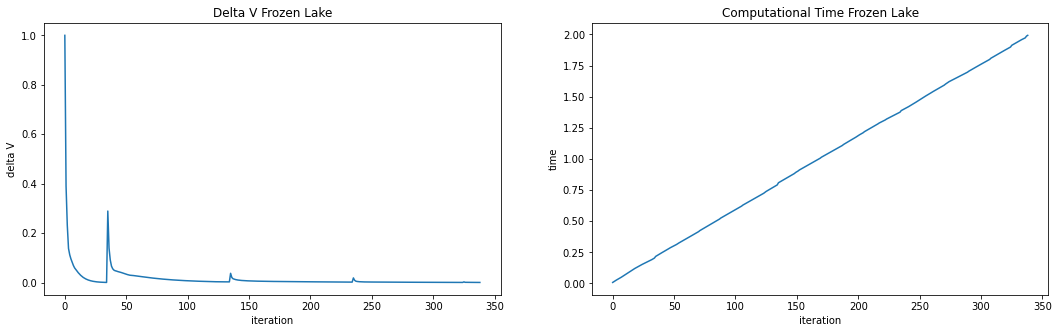

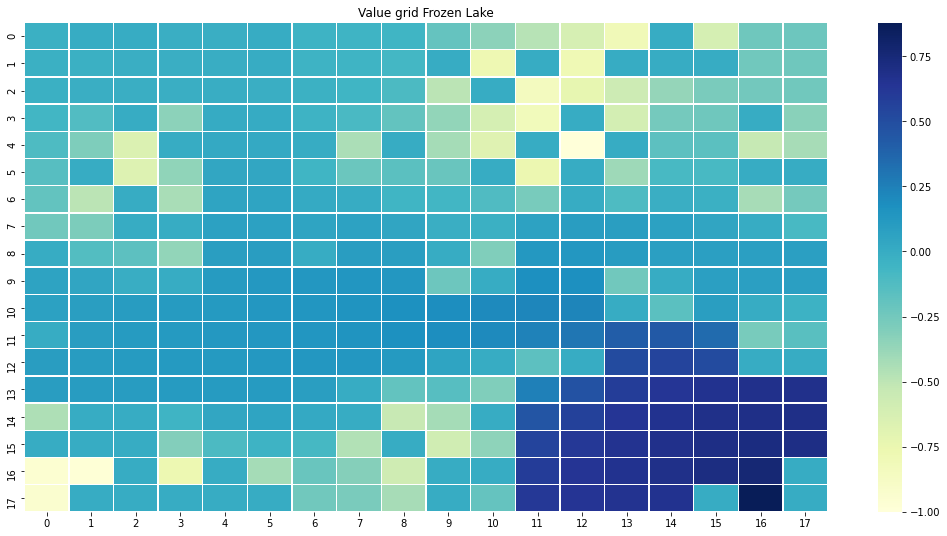

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


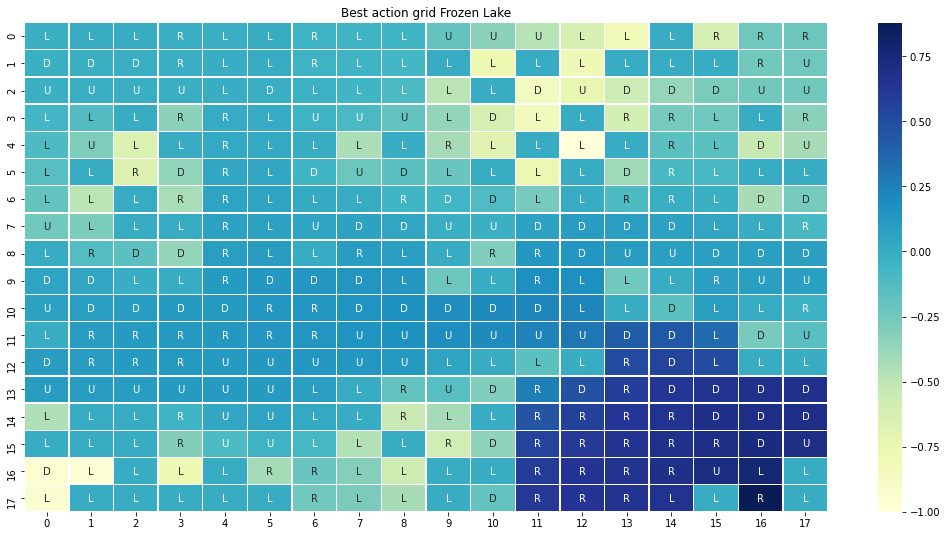

 45%|████▌     | 45/100 [00:00<00:00, 129.97it/s]

100%|██████████| 100/100 [00:00<00:00, 130.82it/s][A

100%|██████████| 100/100 [00:00<00:00, 131.37it/s][A

 66%|██████▌   | 66/100 [00:00<00:00, 126.29it/s]

 28%|██▊       | 28/100 [00:00<00:00, 119.81it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


took 348 iteration to converge


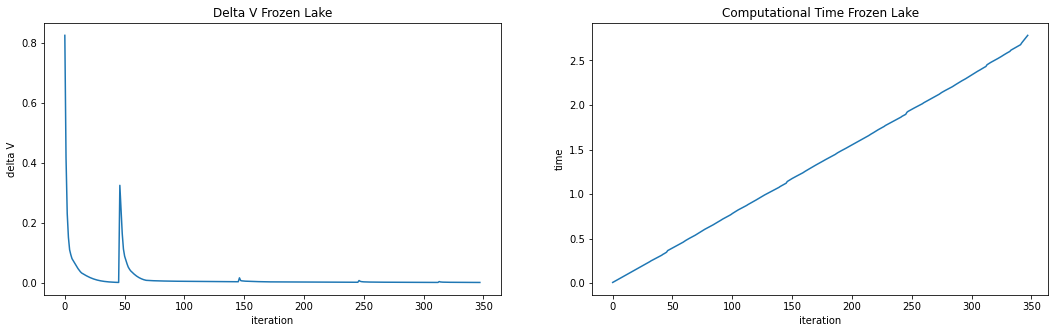

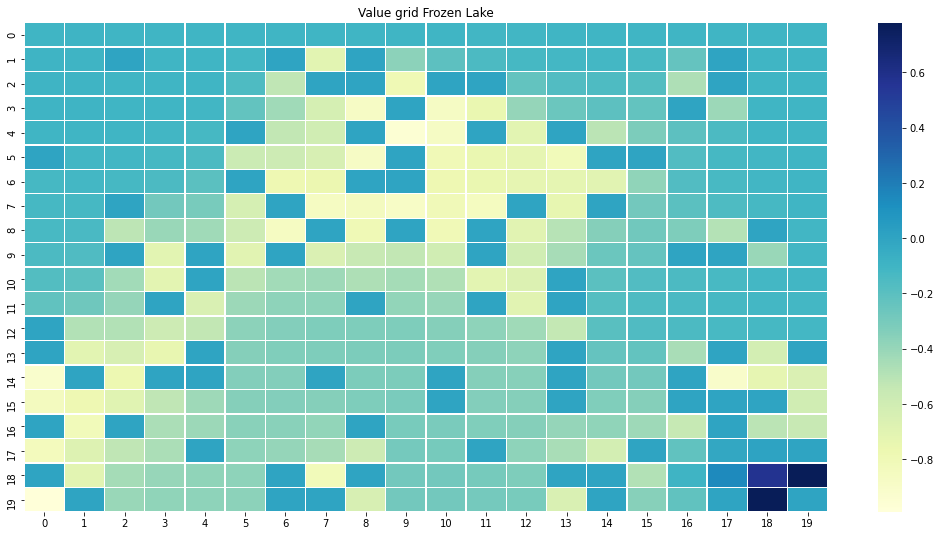

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


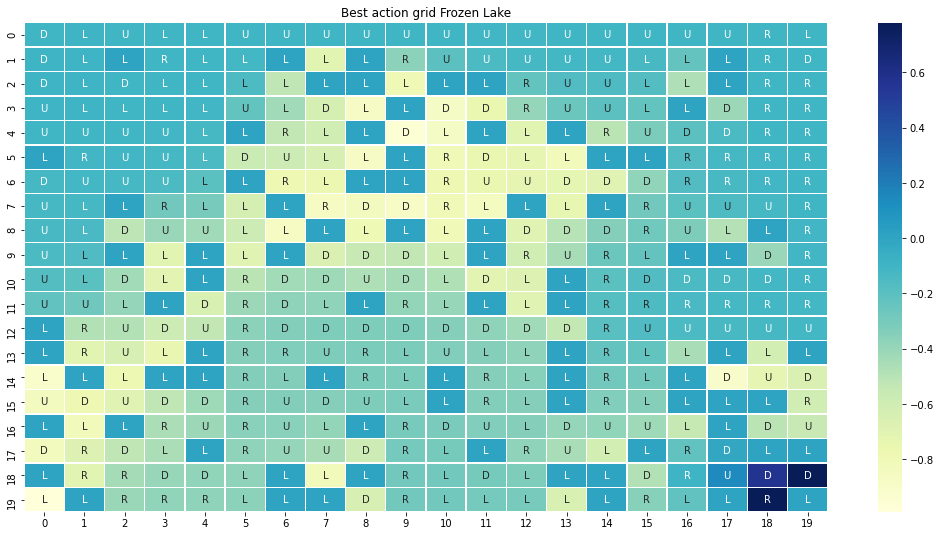

 40%|████      | 40/100 [00:00<00:00, 108.27it/s]

100%|██████████| 100/100 [00:00<00:00, 110.93it/s][A

100%|██████████| 100/100 [00:00<00:00, 110.88it/s][A

 46%|████▌     | 46/100 [00:00<00:00, 103.69it/s]

  3%|▎         | 3/100 [00:00<00:01, 73.62it/s]

  2%|▏         | 2/100 [00:00<00:01, 75.64it/s]

  2%|▏         | 2/100 [00:00<00:01, 72.60it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:01, 56.31it/s]

  1%|          | 1/100 [00:00<00:02, 46.58it/s]

  1%|          | 1/100 [00:00<00:01, 51.27it/s]


took 305 iteration to converge


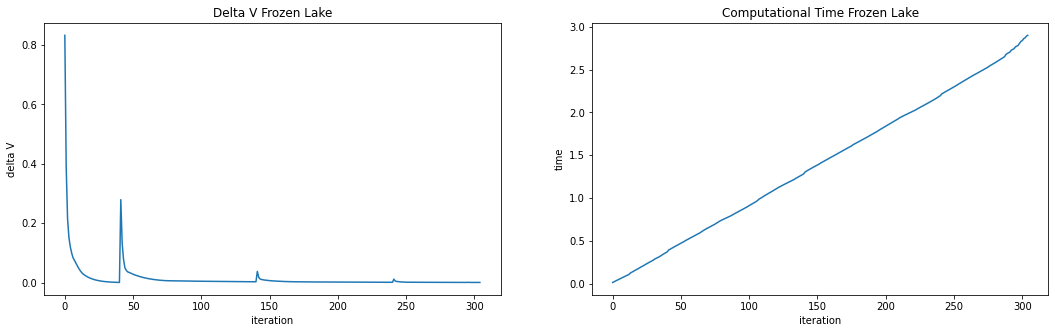

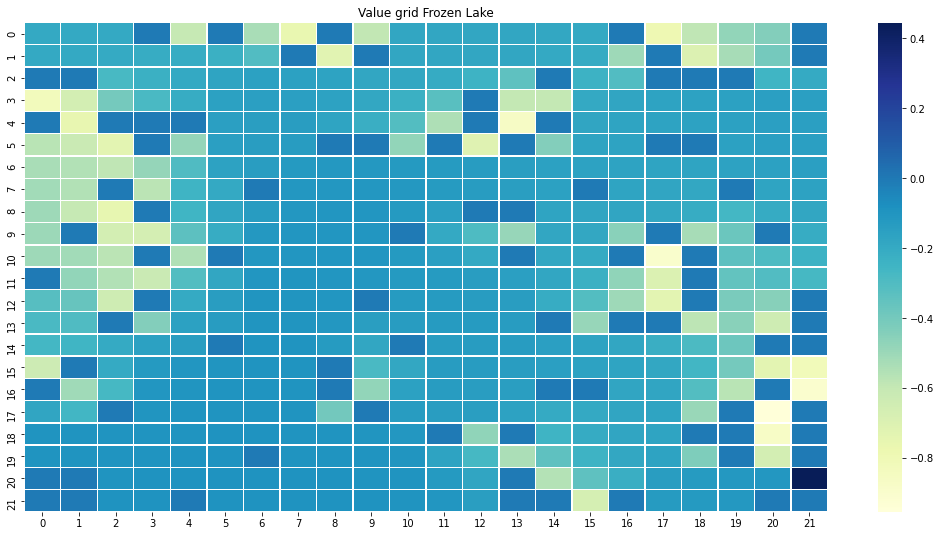

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


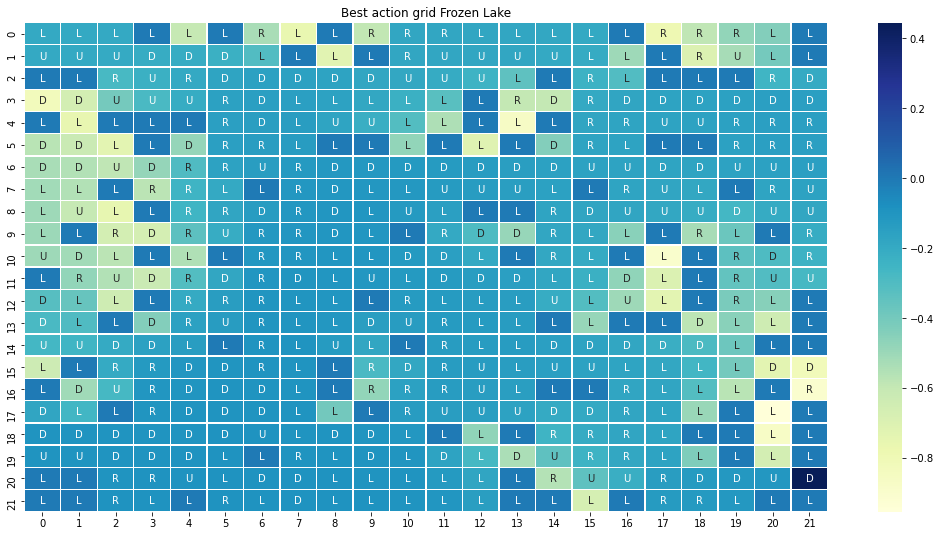

 46%|████▌     | 46/100 [00:00<00:00, 84.09it/s]

100%|██████████| 100/100 [00:01<00:00, 87.13it/s][A

100%|██████████| 100/100 [00:01<00:00, 84.24it/s][A

 76%|███████▌  | 76/100 [00:00<00:00, 86.05it/s]

 12%|█▏        | 12/100 [00:00<00:01, 73.89it/s][A

  3%|▎         | 3/100 [00:00<00:01, 60.30it/s]

  1%|          | 1/100 [00:00<00:02, 42.87it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:02, 44.68it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


took 348 iteration to converge


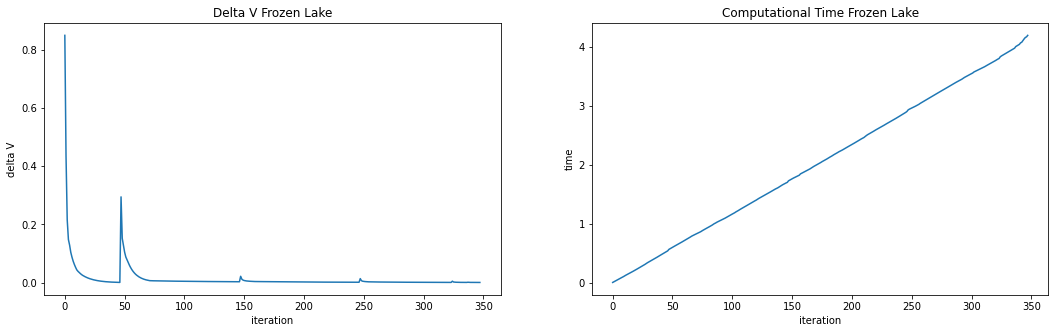

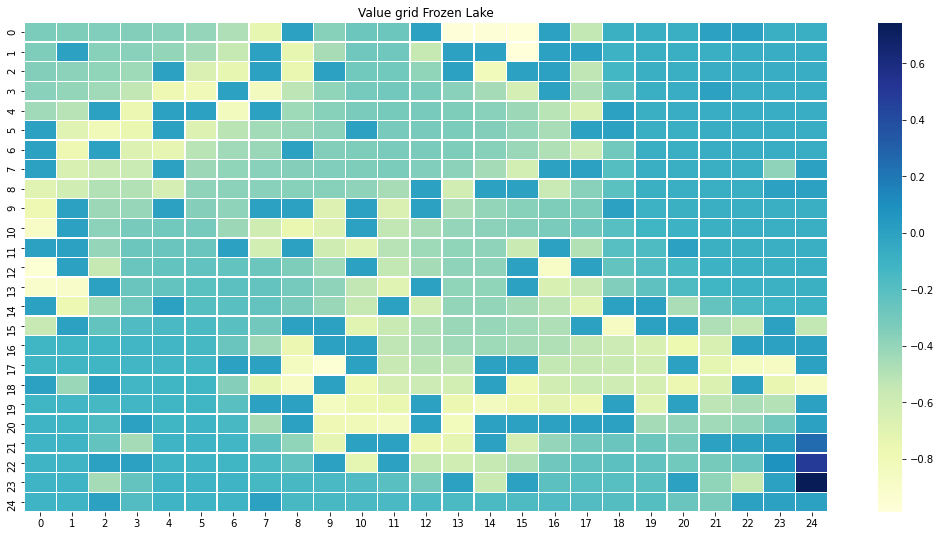

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


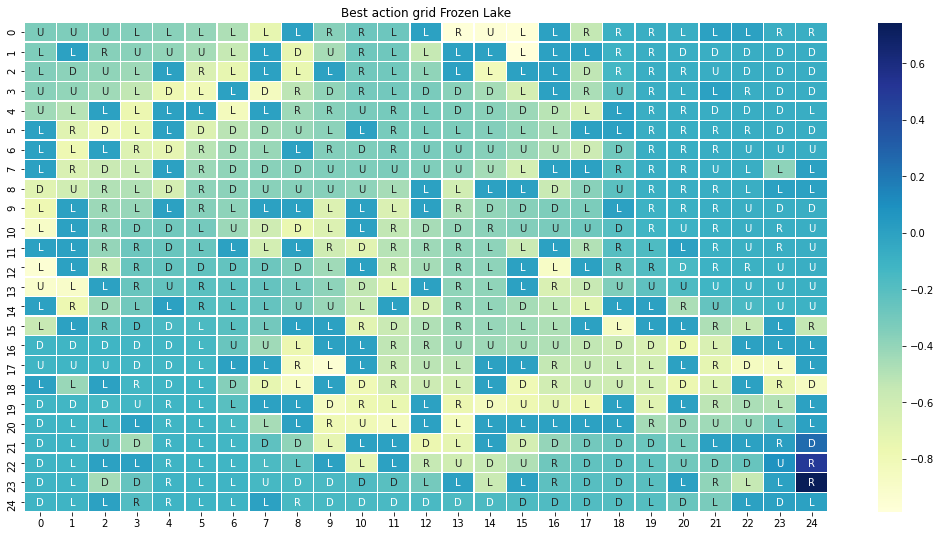

 39%|███▉      | 39/100 [00:00<00:01, 55.96it/s]

100%|██████████| 100/100 [00:01<00:00, 57.42it/s][A

100%|██████████| 100/100 [00:01<00:00, 57.27it/s][A

 74%|███████▍  | 74/100 [00:01<00:00, 57.87it/s]

 57%|█████▋    | 57/100 [00:00<00:00, 57.30it/s]

  2%|▏         | 2/100 [00:00<00:02, 38.85it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


took 381 iteration to converge


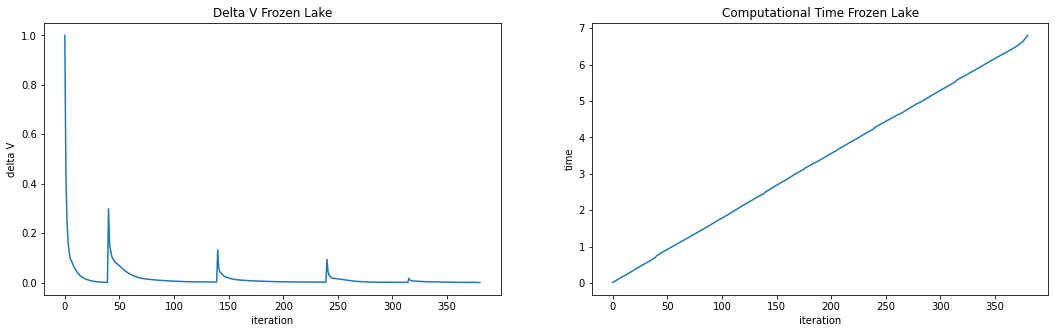

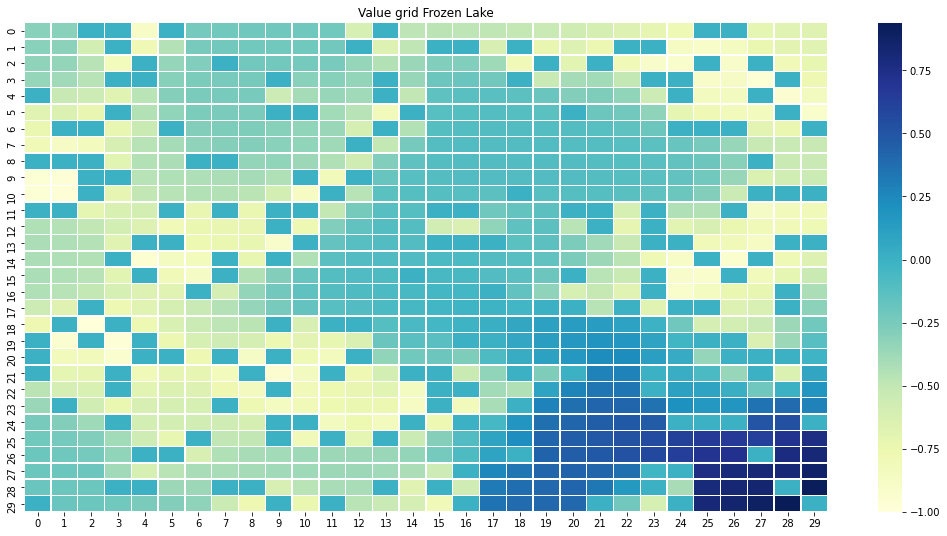

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


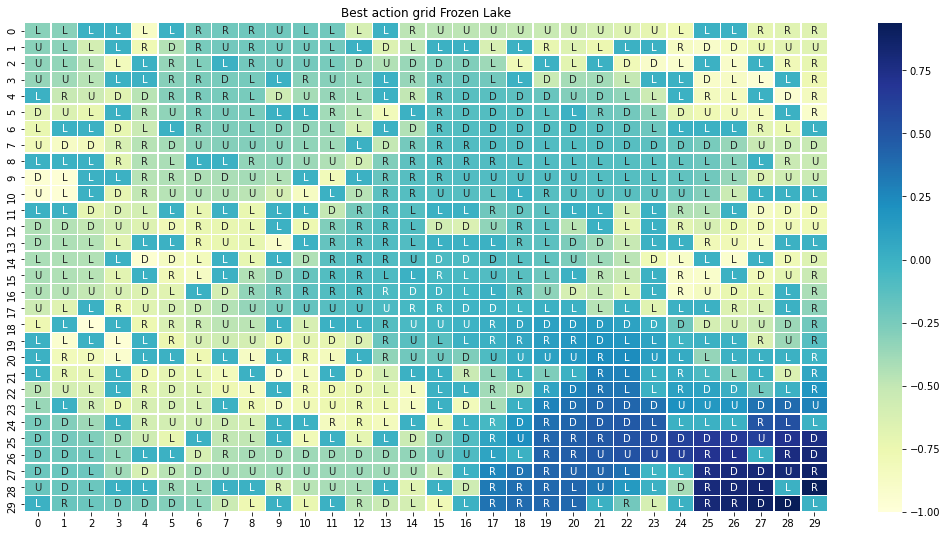

 40%|████      | 40/100 [00:01<00:01, 33.41it/s]

100%|██████████| 100/100 [00:02<00:00, 33.48it/s]

100%|██████████| 100/100 [00:02<00:00, 33.59it/s]

 66%|██████▌   | 66/100 [00:02<00:01, 31.74it/s]

  7%|▋         | 7/100 [00:00<00:03, 29.98it/s]

  1%|          | 1/100 [00:00<00:05, 19.52it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


took 323 iteration to converge


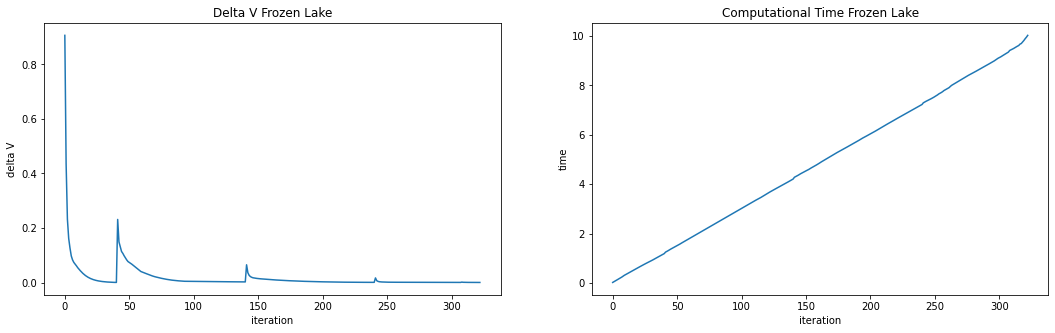

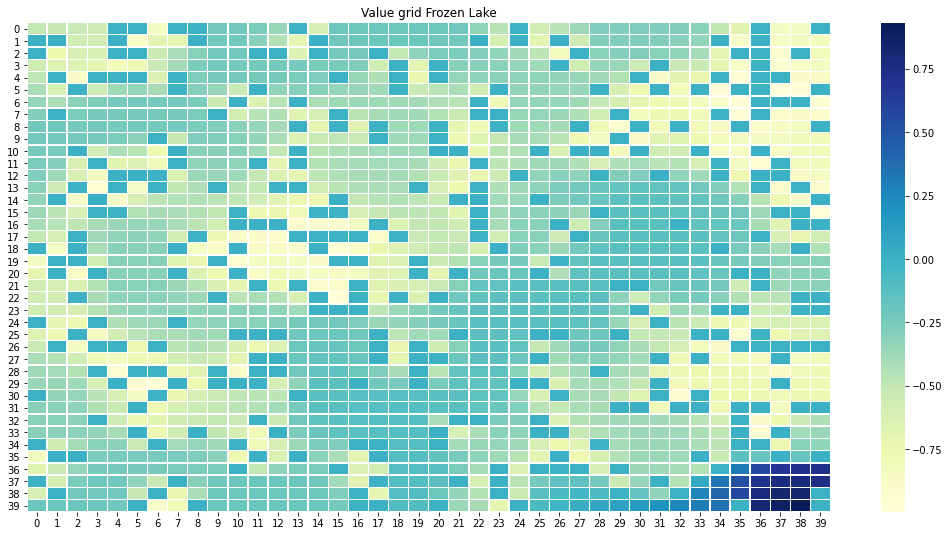

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


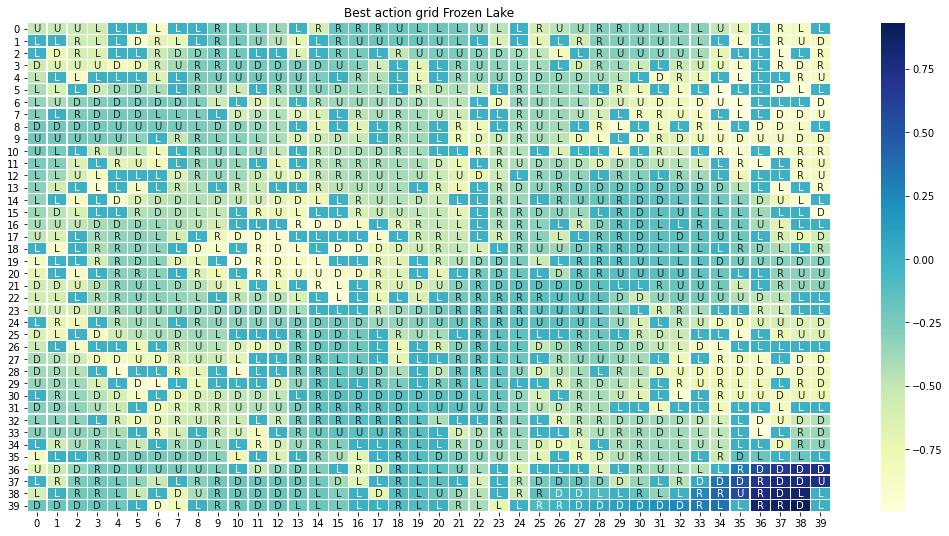

 56%|█████▌    | 56/100 [00:02<00:02, 21.32it/s]

100%|██████████| 100/100 [00:04<00:00, 21.38it/s]

100%|██████████| 100/100 [00:04<00:00, 21.54it/s]

 64%|██████▍   | 64/100 [00:02<00:01, 21.72it/s]

 10%|█         | 10/100 [00:00<00:04, 19.88it/s][A

  5%|▌         | 5/100 [00:00<00:05, 17.25it/s]

  1%|          | 1/100 [00:00<00:09, 10.45it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


took 345 iteration to converge


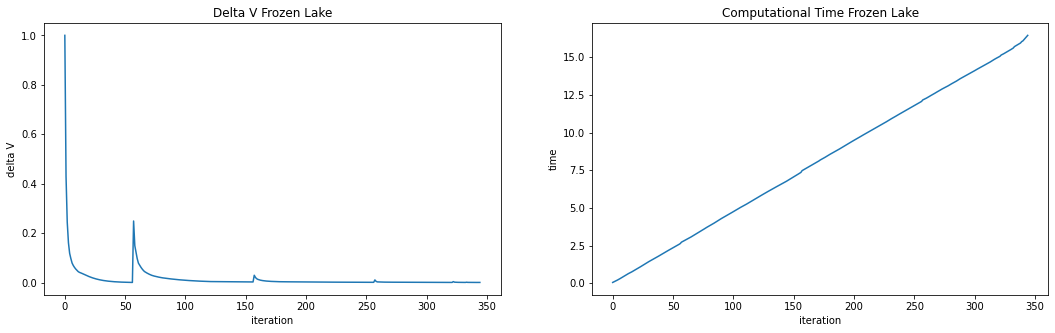

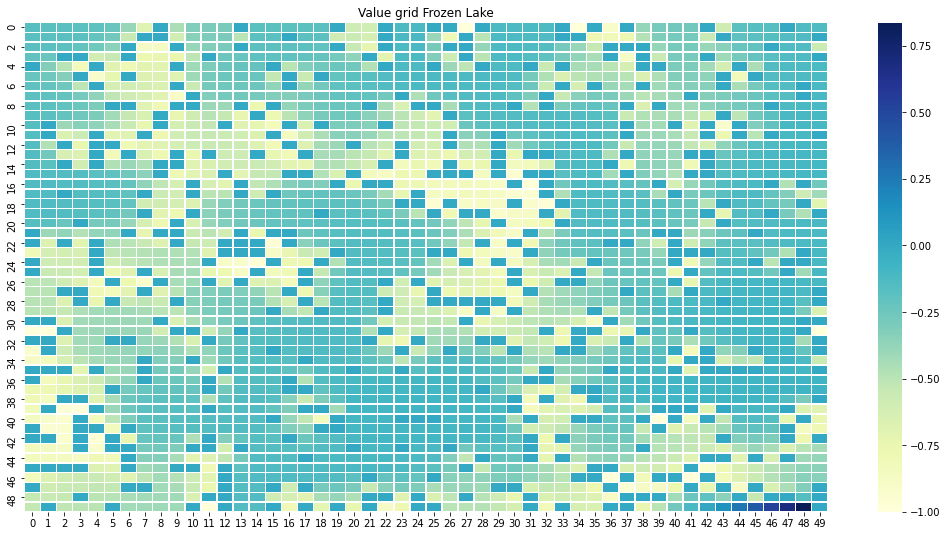

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


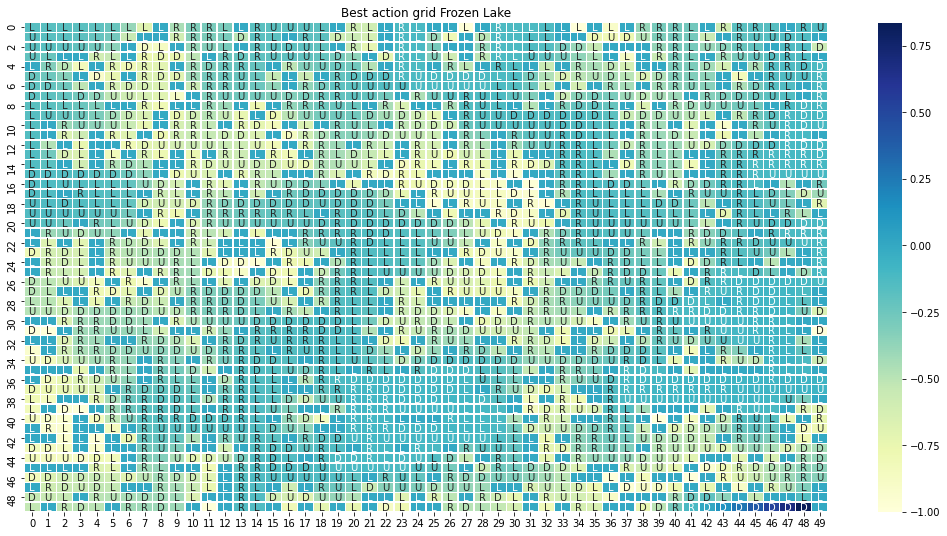

100%|██████████| 13/13 [01:20<00:00,  6.23s/it]


In [102]:
policy_iteration_time_with_size = []
for s in tqdm(size):
    env = FrozenLakeEnv(desc=generate_random_map(size=s, p=0.8), neg_rew=-1)
    start = time()
    policy_iteration(env)
    policy_iteration_time_with_size.append(time() - start)
    

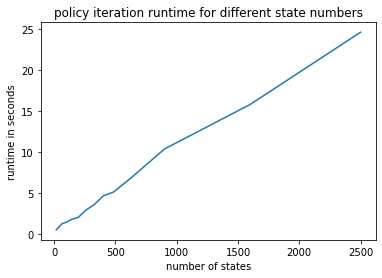

In [103]:
plt.plot(np.square(size),policy_iteration_time_with_size)
plt.title('policy iteration runtime for different state numbers')
plt.xlabel('number of states')
plt.ylabel('runtime in seconds')
plt.show()

 23%|██▎       | 227/999 [00:00<00:00, 772.41it/s]


Episode 100
score = -1.0000

Episode 200
score = 1.0000



 39%|███▊      | 386/999 [00:00<00:00, 764.88it/s]


Episode 300
score = 1.0000

Episode 400
score = 1.0000



 61%|██████    | 610/999 [00:00<00:00, 732.33it/s]


Episode 500
score = 1.0000

Episode 600
score = 1.0000



 87%|████████▋ | 867/999 [00:01<00:00, 799.75it/s]


Episode 700
score = 1.0000

Episode 800
score = 1.0000



100%|██████████| 999/999 [00:01<00:00, 770.67it/s]



Episode 900
score = 1.0000


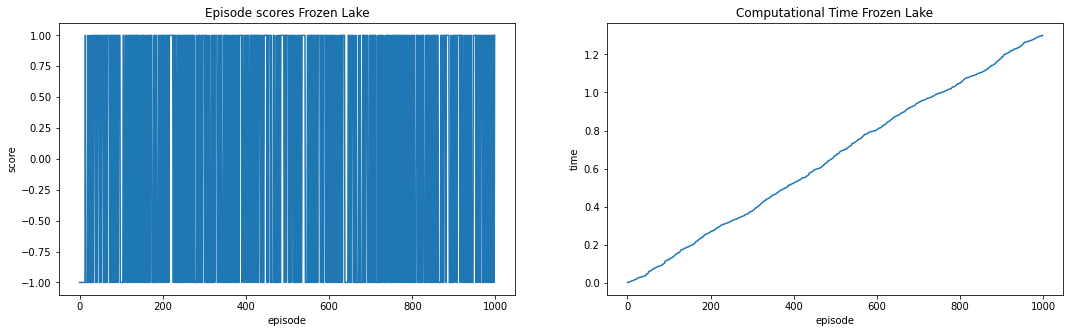

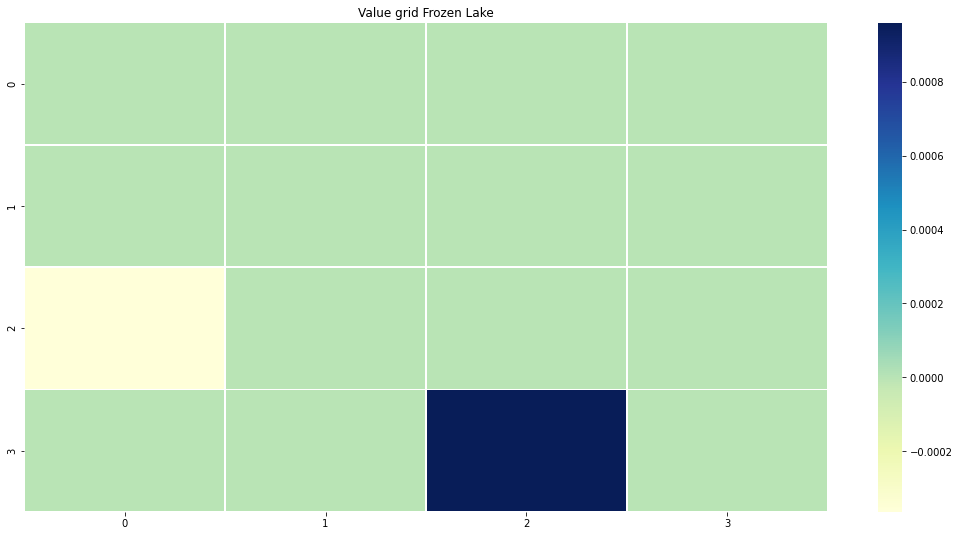

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


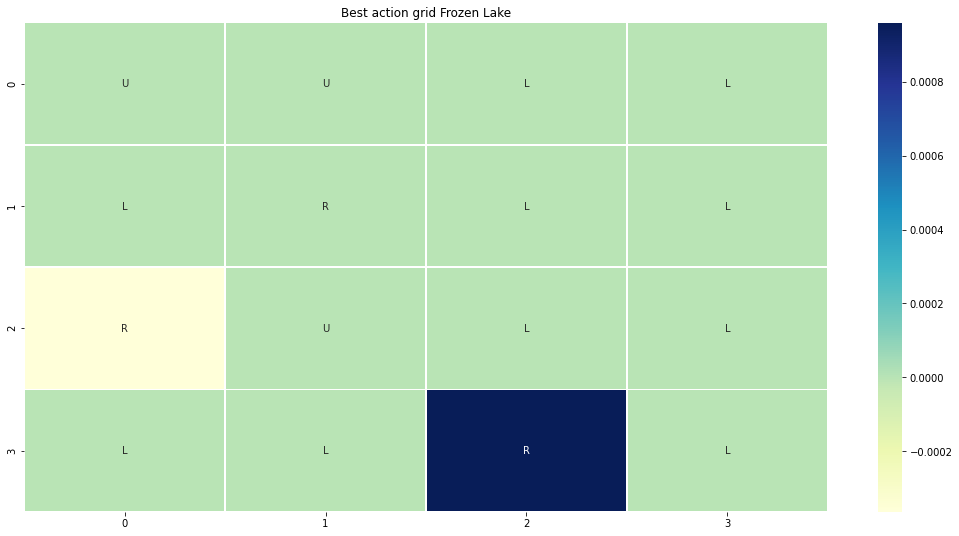

 10%|█         | 100/999 [00:00<00:08, 102.09it/s]


Episode 100
score = -1.0000



 23%|██▎       | 226/999 [00:02<00:07, 99.59it/s]


Episode 200
score = -1.0000



 32%|███▏      | 320/999 [00:03<00:07, 94.54it/s]


Episode 300
score = -1.0000



 42%|████▏     | 418/999 [00:04<00:06, 89.55it/s]


Episode 400
score = -1.0000



 51%|█████     | 507/999 [00:05<00:05, 82.37it/s]


Episode 500
score = -1.0000



 61%|██████    | 609/999 [00:06<00:05, 70.21it/s]


Episode 600
score = -1.0000



 72%|███████▏  | 717/999 [00:08<00:03, 85.87it/s]


Episode 700
score = 1.0000



 81%|████████  | 809/999 [00:09<00:02, 80.31it/s]


Episode 800
score = -1.0000



 91%|█████████ | 910/999 [00:10<00:01, 83.35it/s]



Episode 900
score = -1.0000


100%|██████████| 999/999 [00:11<00:00, 86.05it/s]


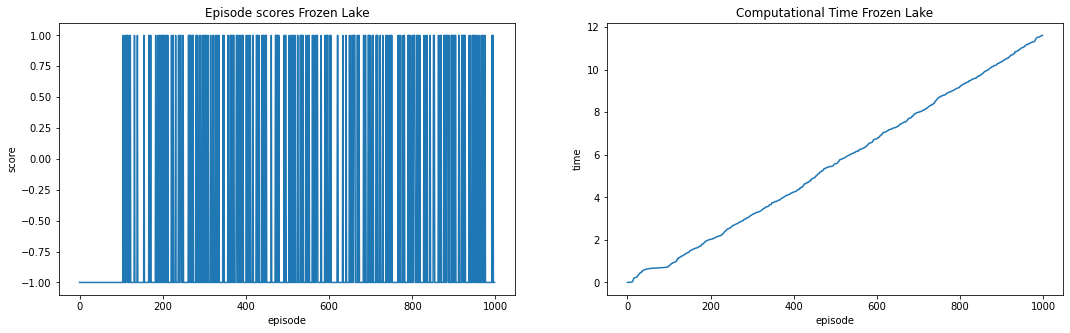

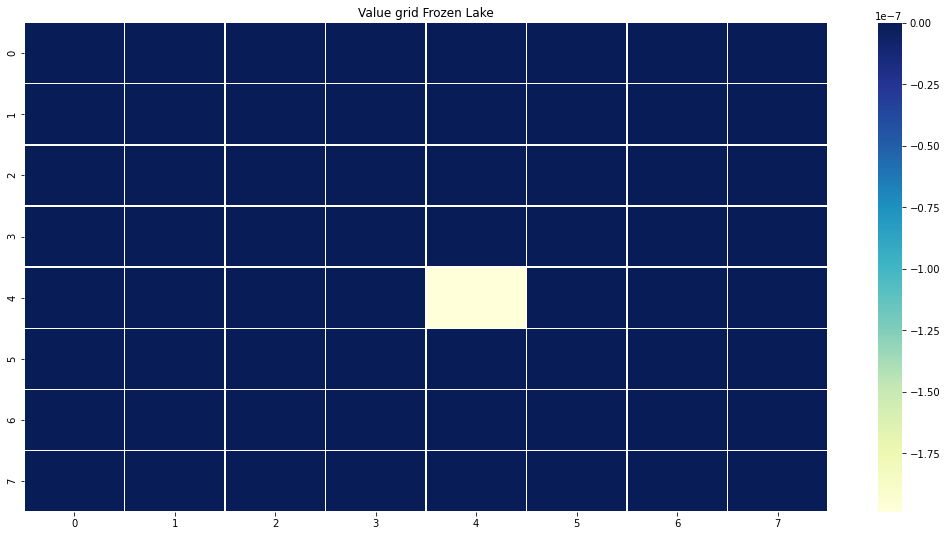

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


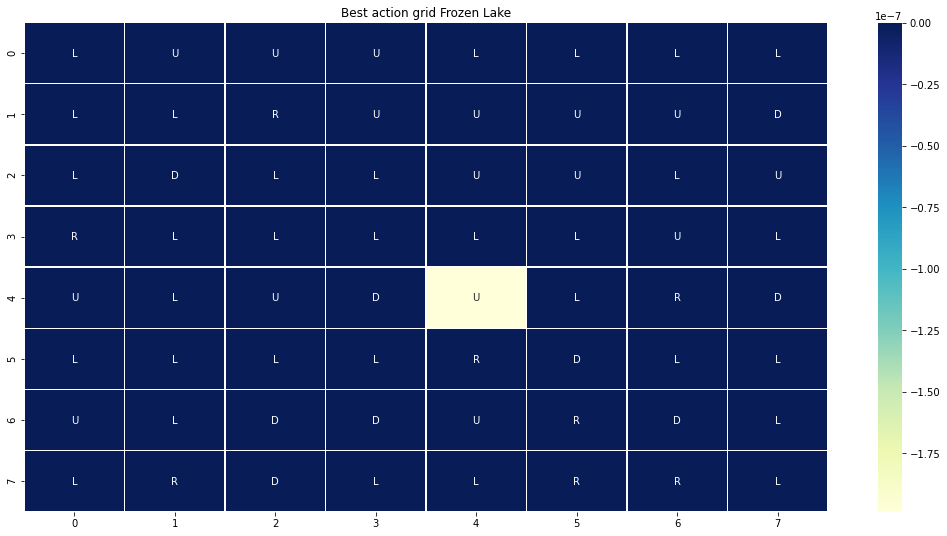

 12%|█▏        | 118/999 [00:01<00:09, 94.26it/s]


Episode 100
score = -1.0000



 21%|██        | 210/999 [00:02<00:12, 61.28it/s]


Episode 200
score = 1.0000



 31%|███       | 310/999 [00:04<00:11, 60.93it/s]


Episode 300
score = 1.0000



 41%|████      | 412/999 [00:05<00:11, 53.10it/s]



Episode 400
score = 1.0000


 51%|█████▏    | 513/999 [00:07<00:07, 63.57it/s]


Episode 500
score = -1.0000



 61%|██████    | 608/999 [00:08<00:06, 56.67it/s]



Episode 600
score = 1.0000


 71%|███████▏  | 712/999 [00:10<00:05, 53.47it/s]



Episode 700
score = 1.0000


 81%|████████▏ | 813/999 [00:12<00:03, 61.97it/s]


Episode 800
score = 1.0000



 91%|█████████ | 907/999 [00:14<00:02, 45.15it/s]


Episode 900
score = 1.0000



100%|██████████| 999/999 [00:16<00:00, 62.15it/s]


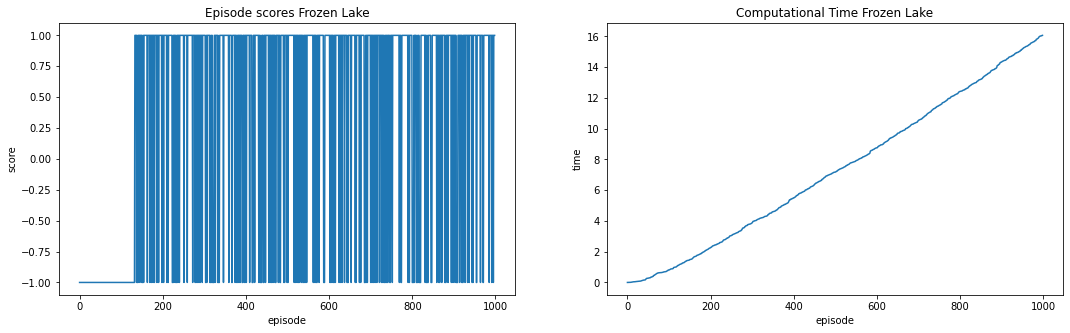

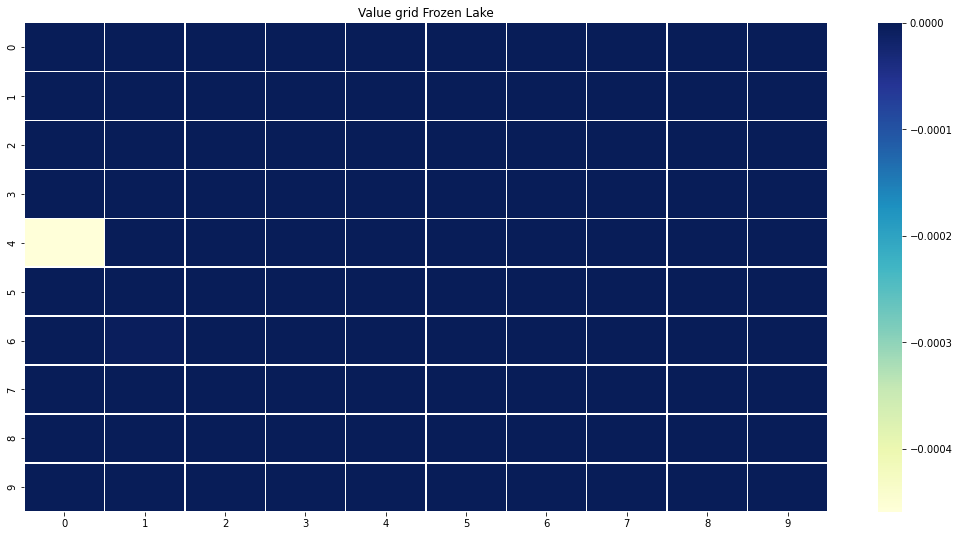

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


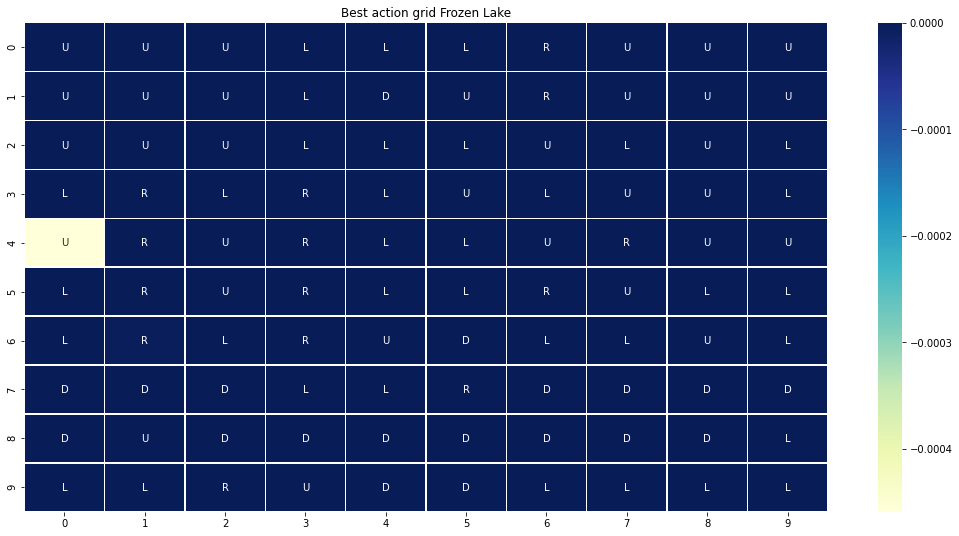

 13%|█▎        | 130/999 [00:00<00:03, 233.67it/s]



Episode 100
score = -1.0000


 23%|██▎       | 226/999 [00:01<00:04, 171.25it/s]



Episode 200
score = -1.0000


 32%|███▏      | 319/999 [00:01<00:04, 160.39it/s]



Episode 300
score = 1.0000


 41%|████▏     | 414/999 [00:02<00:04, 135.08it/s]


Episode 400
score = -1.0000



 52%|█████▏    | 516/999 [00:03<00:03, 136.12it/s]



Episode 500
score = -1.0000


 62%|██████▏   | 620/999 [00:04<00:03, 120.93it/s]



Episode 600
score = 1.0000


 71%|███████▏  | 713/999 [00:04<00:02, 113.51it/s]



Episode 700
score = -1.0000


 83%|████████▎ | 832/999 [00:05<00:01, 124.91it/s]


Episode 800
score = -1.0000



 92%|█████████▏| 918/999 [00:06<00:00, 110.90it/s]



Episode 900
score = -1.0000


100%|██████████| 999/999 [00:07<00:00, 141.43it/s]


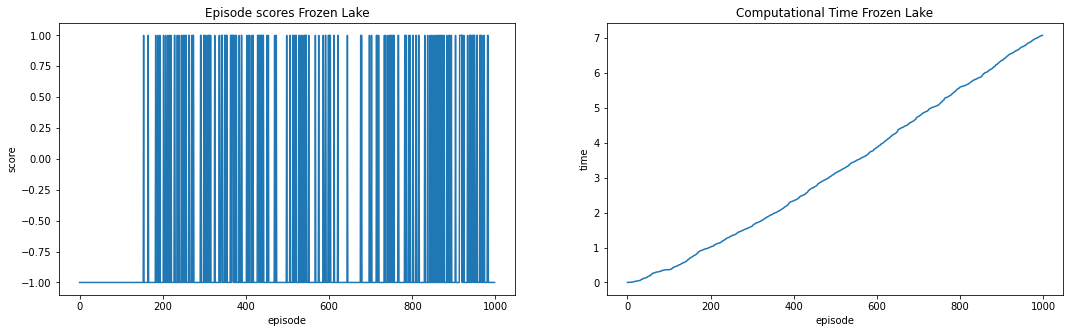

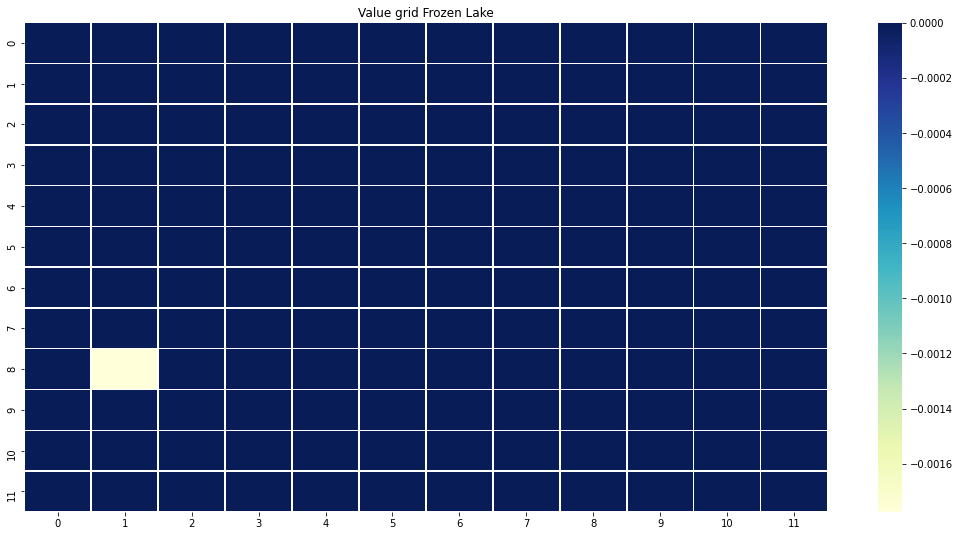

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


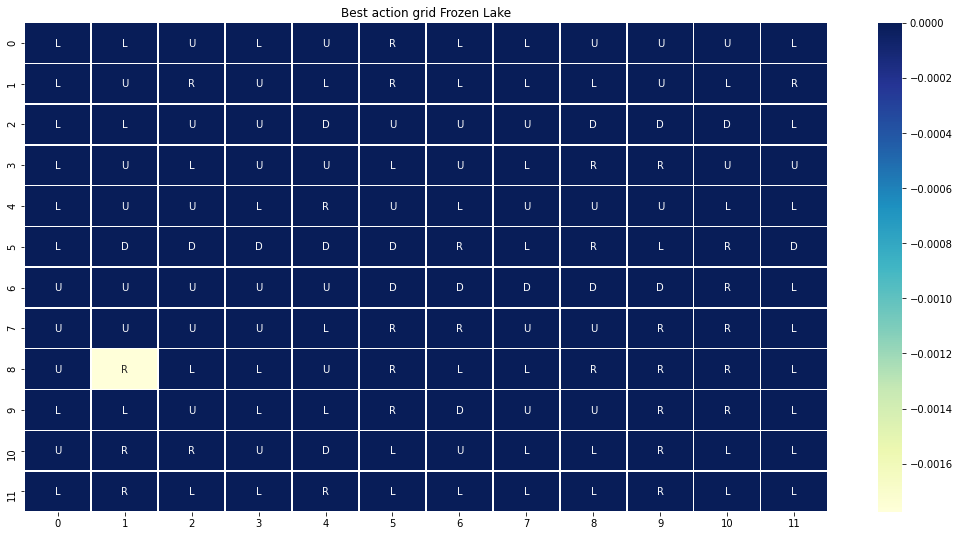

 14%|█▍        | 142/999 [00:00<00:01, 471.77it/s]



Episode 100
score = -1.0000


 23%|██▎       | 231/999 [00:00<00:02, 307.74it/s]


Episode 200
score = -1.0000



 33%|███▎      | 331/999 [00:01<00:03, 215.20it/s]


Episode 300
score = -1.0000



 43%|████▎     | 430/999 [00:01<00:04, 135.77it/s]



Episode 400
score = -1.0000


 52%|█████▏    | 518/999 [00:02<00:03, 121.74it/s]



Episode 500
score = -1.0000


 63%|██████▎   | 631/999 [00:03<00:02, 145.79it/s]


Episode 600
score = -1.0000



 74%|███████▎  | 736/999 [00:04<00:01, 151.15it/s]



Episode 700
score = 1.0000


 83%|████████▎ | 830/999 [00:04<00:01, 141.60it/s]


Episode 800
score = -1.0000



 93%|█████████▎| 932/999 [00:05<00:00, 144.09it/s]



Episode 900
score = -1.0000


100%|██████████| 999/999 [00:05<00:00, 168.80it/s]


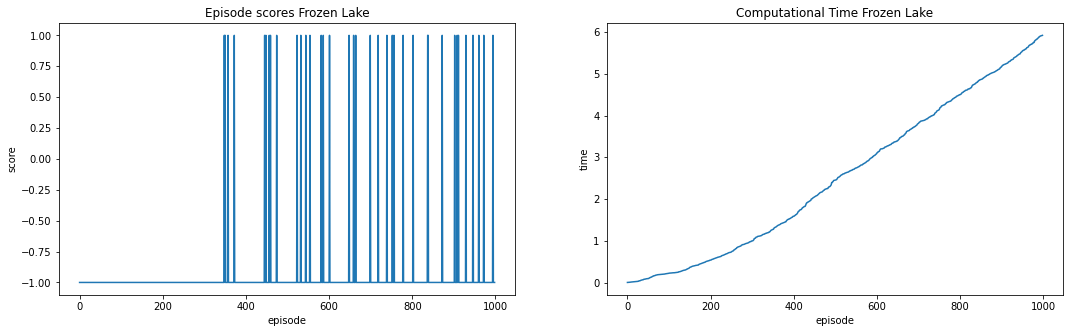

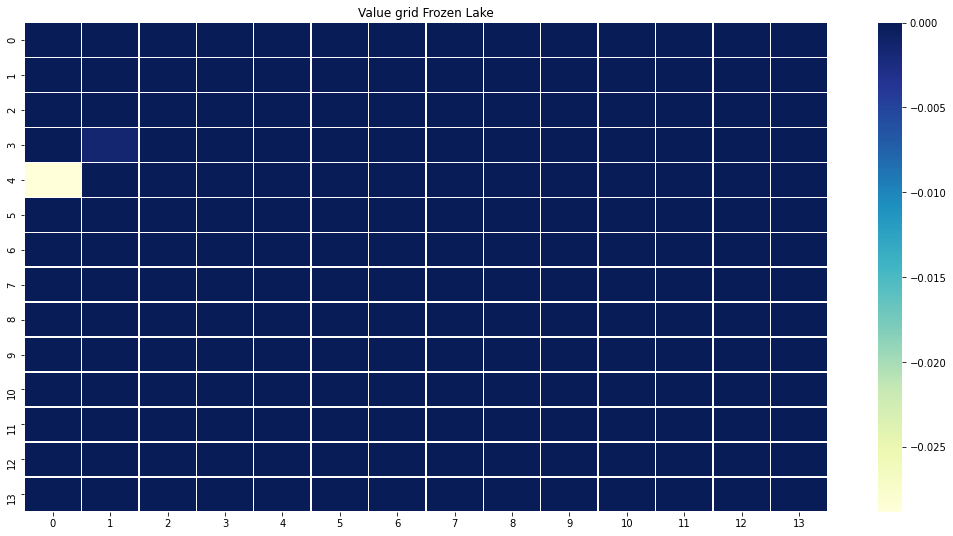

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


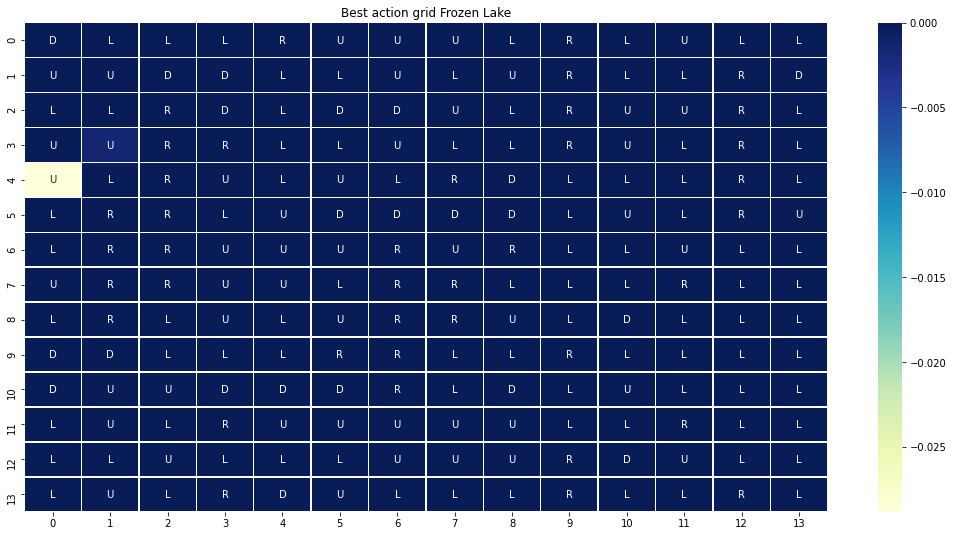

 11%|█         | 105/999 [00:02<00:39, 22.73it/s]



Episode 100
score = -1.0000


 21%|██        | 205/999 [00:04<00:09, 83.28it/s]



Episode 200
score = -1.0000


 31%|███       | 308/999 [00:06<00:12, 55.22it/s]



Episode 300
score = -1.0000


 41%|████      | 408/999 [00:07<00:11, 53.27it/s]



Episode 400
score = -1.0000


 51%|█████▏    | 513/999 [00:09<00:09, 49.89it/s]



Episode 500
score = -1.0000


 61%|██████    | 611/999 [00:11<00:07, 54.51it/s]


Episode 600
score = -1.0000



 72%|███████▏  | 716/999 [00:13<00:04, 62.41it/s]



Episode 700
score = -1.0000


 81%|████████▏ | 813/999 [00:15<00:03, 56.61it/s]



Episode 800
score = -1.0000


 91%|█████████▏| 914/999 [00:17<00:01, 59.07it/s]


Episode 900
score = -1.0000



100%|██████████| 999/999 [00:18<00:00, 54.02it/s]


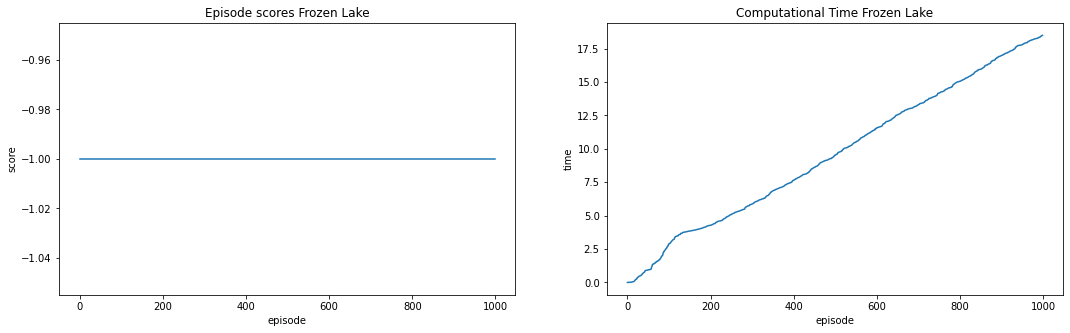

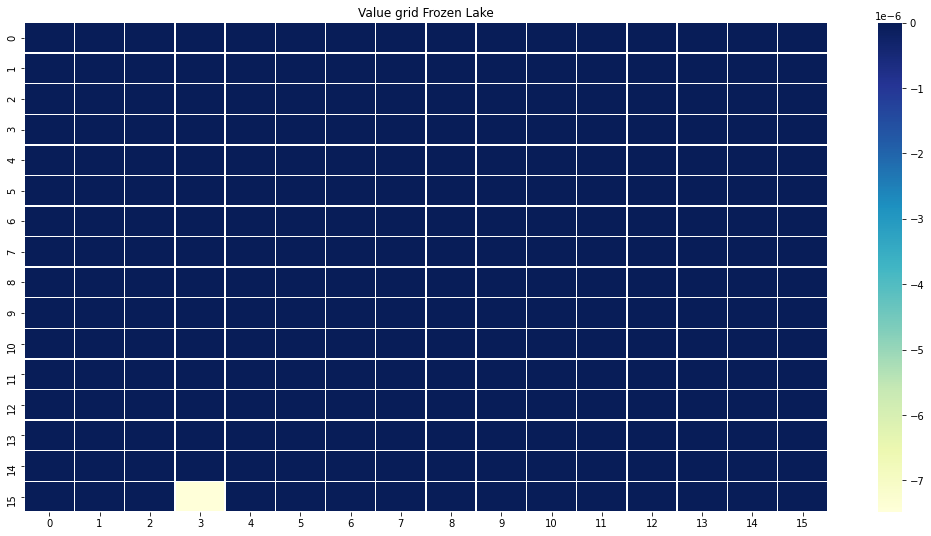

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


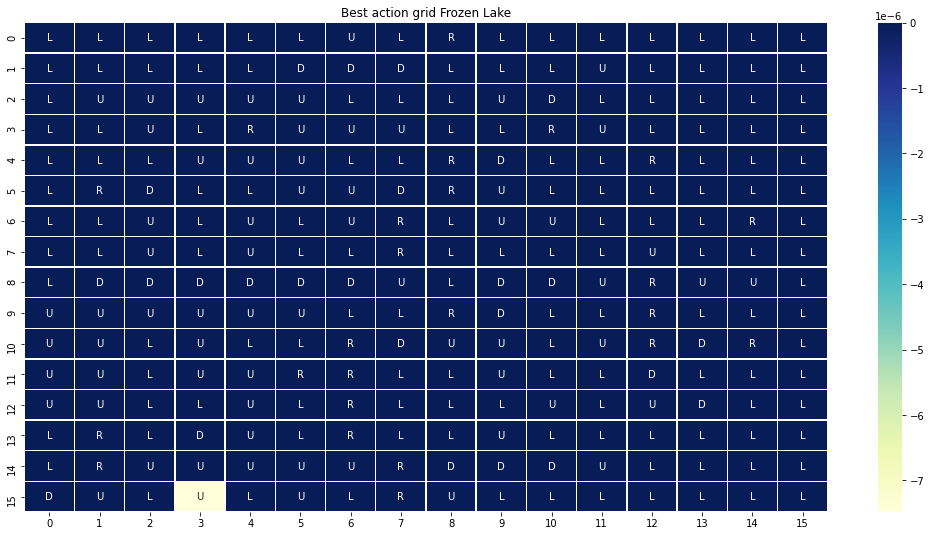

 10%|█         | 102/999 [00:05<02:11,  6.84it/s]


Episode 100
score = -1.0000



 20%|█▉        | 199/999 [00:25<07:54,  1.69it/s]


Episode 200
score = -1.0000



 30%|███       | 300/999 [01:00<03:12,  3.63it/s]


Episode 300
score = -1.0000



 40%|███▉      | 398/999 [01:38<03:02,  3.29it/s]


Episode 400
score = -1.0000



 50%|█████     | 500/999 [02:13<01:57,  4.24it/s]


Episode 500
score = -1.0000



 60%|██████    | 600/999 [02:42<01:35,  4.17it/s]


Episode 600
score = -1.0000



 70%|███████   | 702/999 [03:18<01:15,  3.92it/s]


Episode 700
score = -1.0000



 80%|████████  | 802/999 [03:49<00:38,  5.10it/s]


Episode 800
score = -1.0000



 90%|█████████ | 903/999 [04:26<00:32,  2.95it/s]


Episode 900
score = -1.0000



100%|██████████| 999/999 [04:52<00:00,  3.42it/s]


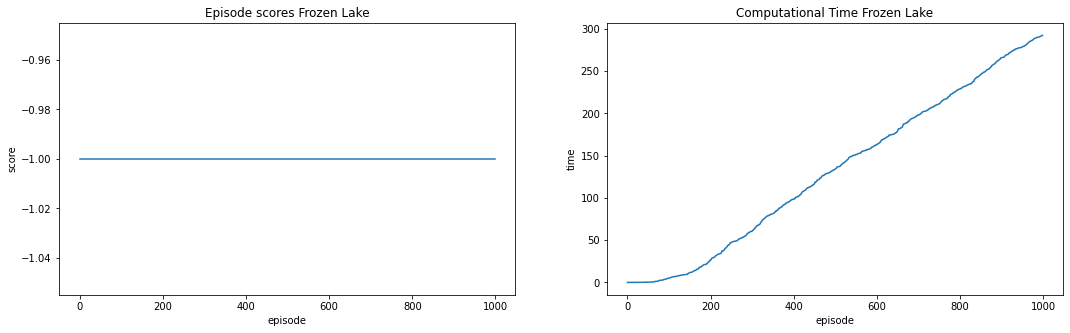

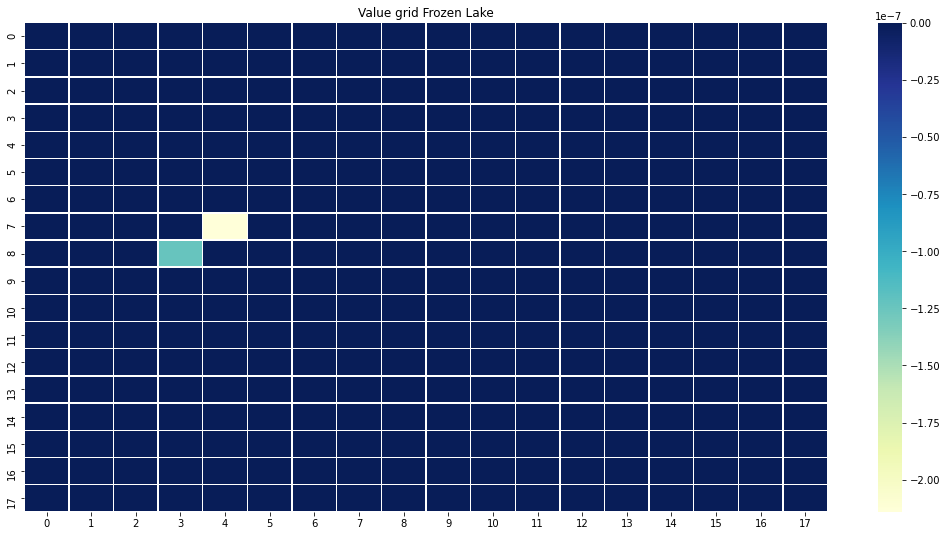

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


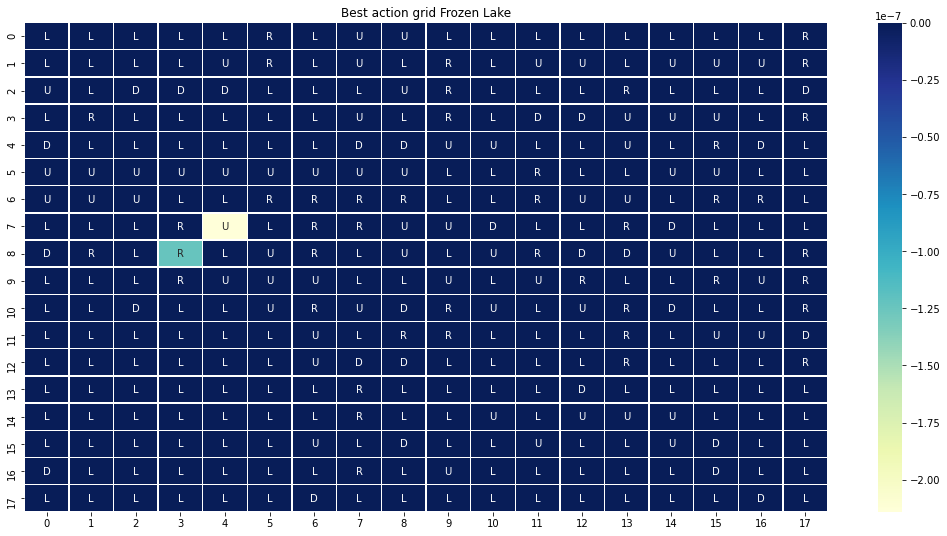

 21%|██        | 205/999 [00:00<00:01, 661.39it/s]


Episode 100
score = -1.0000

Episode 200
score = -1.0000



 34%|███▍      | 343/999 [00:00<00:01, 454.83it/s]



Episode 300
score = -1.0000


 45%|████▌     | 453/999 [00:01<00:01, 329.05it/s]


Episode 400
score = -1.0000



 56%|█████▌    | 560/999 [00:01<00:01, 331.04it/s]


Episode 500
score = -1.0000



 67%|██████▋   | 665/999 [00:01<00:01, 304.99it/s]



Episode 600
score = -1.0000

Episode 700
score = -1.0000


 86%|████████▌ | 859/999 [00:02<00:00, 317.99it/s]



Episode 800
score = -1.0000


 96%|█████████▌| 959/999 [00:02<00:00, 313.10it/s]



Episode 900
score = -1.0000


100%|██████████| 999/999 [00:02<00:00, 364.55it/s]


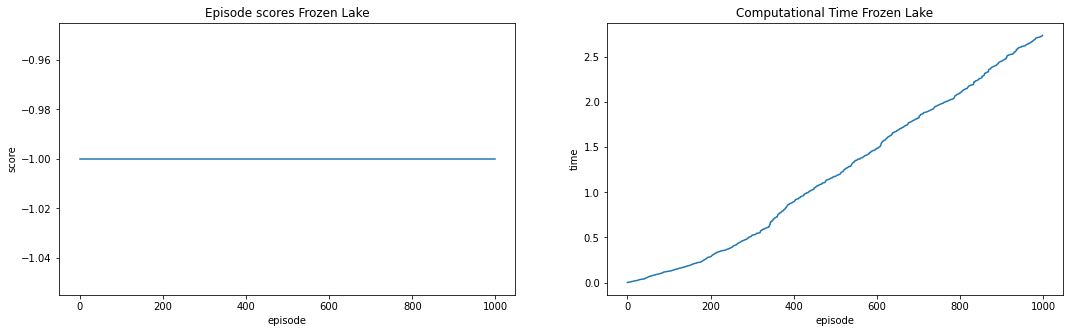

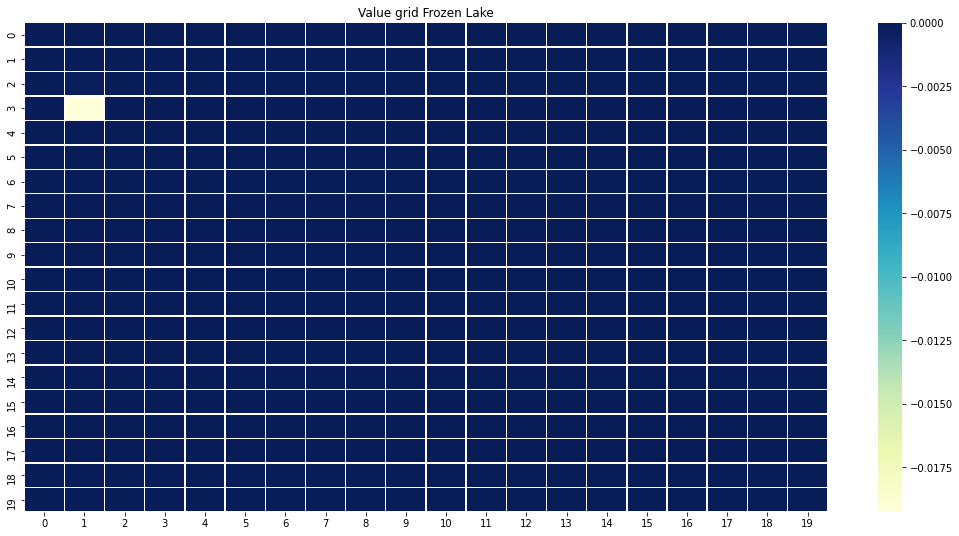

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


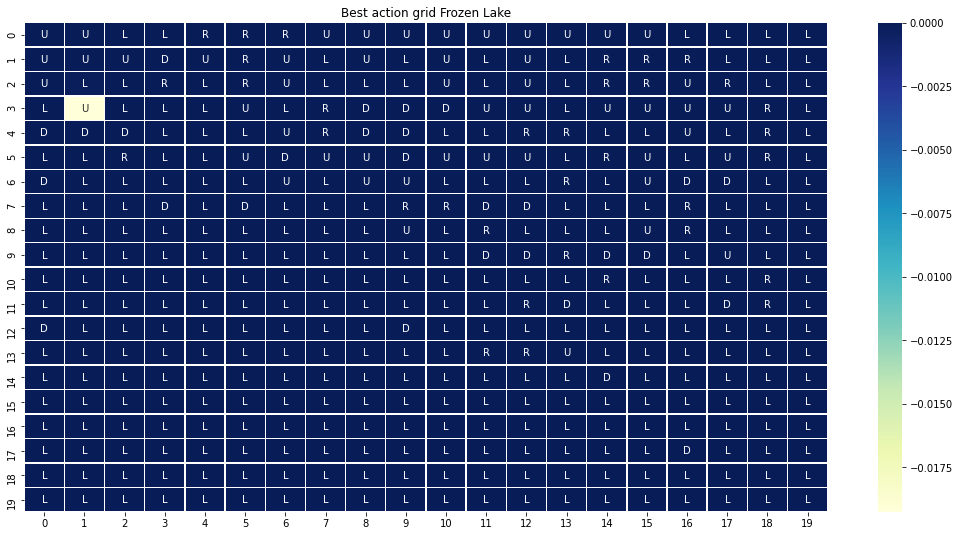

 14%|█▍        | 138/999 [00:00<00:03, 228.90it/s]


Episode 100
score = -1.0000



 23%|██▎       | 226/999 [00:01<00:05, 149.92it/s]


Episode 200
score = -1.0000



 32%|███▏      | 317/999 [00:01<00:05, 128.90it/s]


Episode 300
score = -1.0000



 42%|████▏     | 420/999 [00:02<00:04, 134.54it/s]



Episode 400
score = -1.0000


 52%|█████▏    | 524/999 [00:03<00:03, 157.08it/s]



Episode 500
score = -1.0000


 62%|██████▏   | 621/999 [00:04<00:02, 138.53it/s]



Episode 600
score = -1.0000


 72%|███████▏  | 723/999 [00:04<00:01, 141.90it/s]



Episode 700
score = -1.0000


 83%|████████▎ | 826/999 [00:05<00:01, 121.02it/s]


Episode 800
score = -1.0000



 93%|█████████▎| 926/999 [00:06<00:00, 125.90it/s]



Episode 900
score = -1.0000


100%|██████████| 999/999 [00:06<00:00, 144.27it/s]


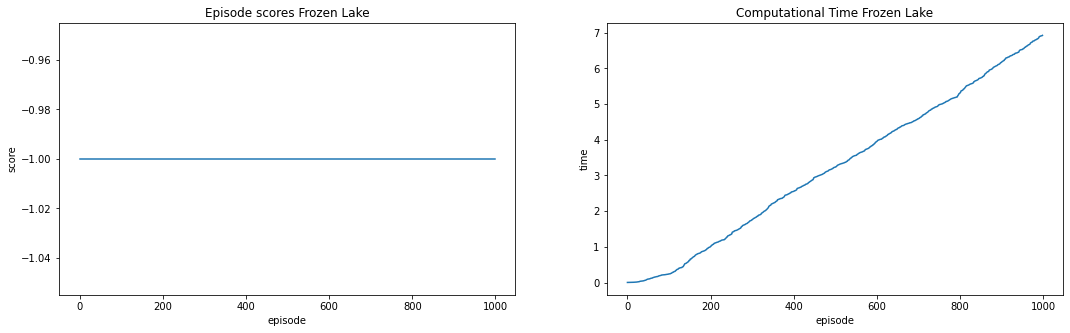

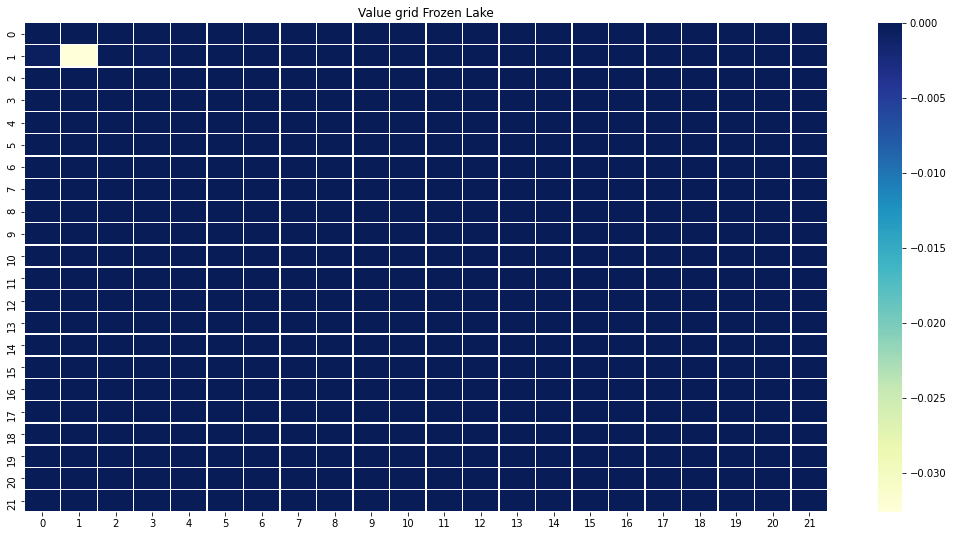

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


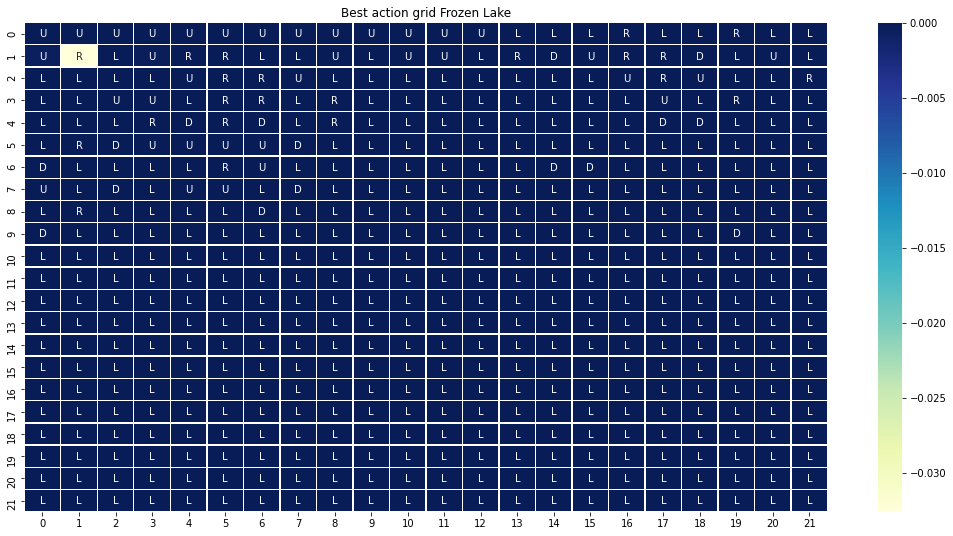

 11%|█▏        | 114/999 [00:00<00:05, 151.95it/s]


Episode 100
score = -1.0000



 22%|██▏       | 220/999 [00:01<00:06, 126.17it/s]


Episode 200
score = -1.0000



 31%|███       | 306/999 [00:03<00:15, 44.58it/s]


Episode 300
score = -1.0000



 41%|████      | 405/999 [00:05<00:17, 34.56it/s]


Episode 400
score = -1.0000



 50%|█████     | 502/999 [00:08<00:19, 25.29it/s]


Episode 500
score = -1.0000



 61%|██████    | 606/999 [00:12<00:12, 31.58it/s]


Episode 600
score = -1.0000



 70%|███████   | 702/999 [00:14<00:09, 31.66it/s]


Episode 700
score = -1.0000



 80%|████████  | 803/999 [00:18<00:08, 24.11it/s]


Episode 800
score = -1.0000



 90%|████████▉ | 899/999 [00:21<00:03, 32.45it/s]


Episode 900
score = -1.0000



100%|██████████| 999/999 [00:26<00:00, 38.38it/s]


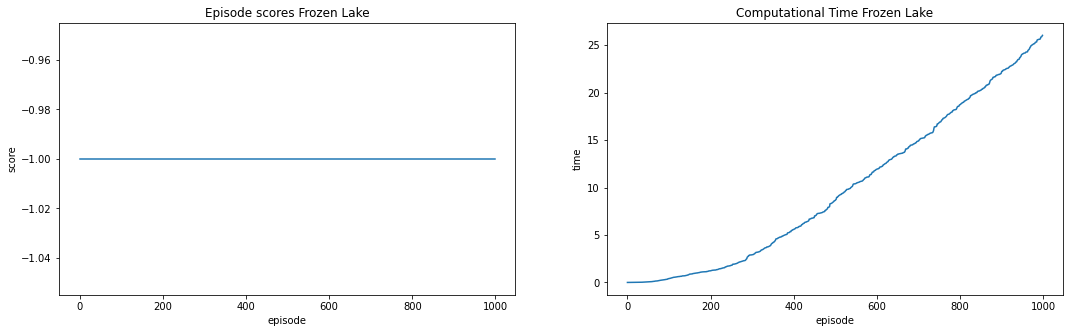

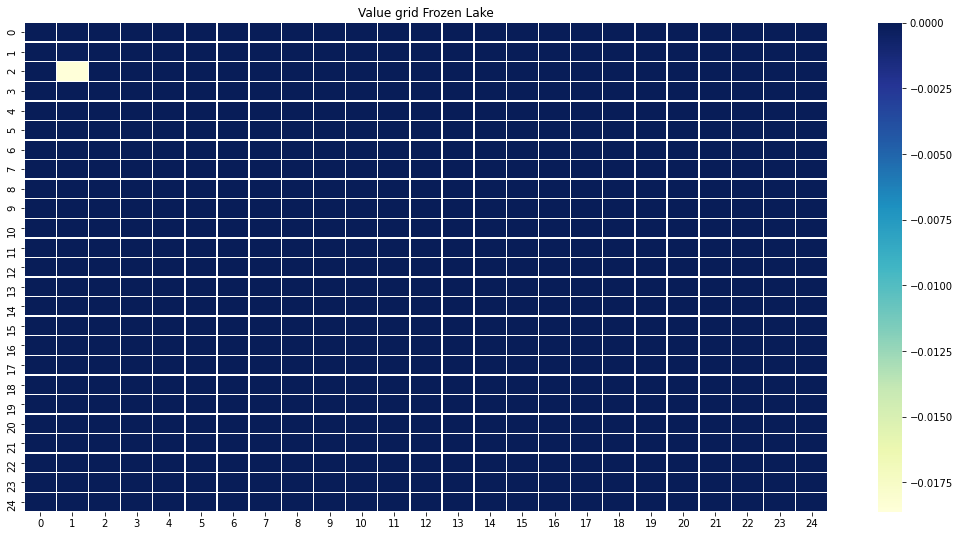

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


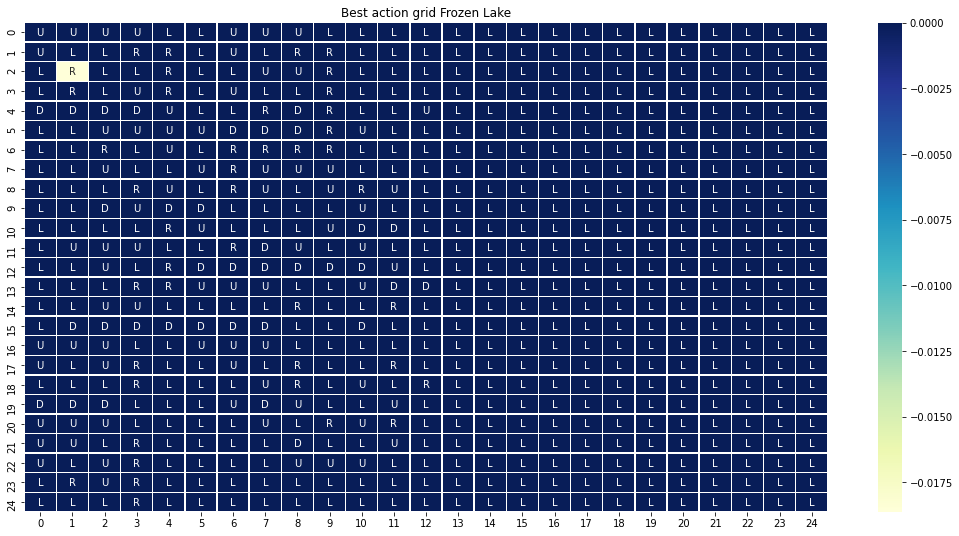

 13%|█▎        | 129/999 [00:00<00:05, 154.34it/s]


Episode 100
score = -1.0000



 22%|██▏       | 224/999 [00:01<00:05, 144.06it/s]


Episode 200
score = -1.0000



 32%|███▏      | 321/999 [00:02<00:05, 123.30it/s]


Episode 300
score = -1.0000



 42%|████▏     | 423/999 [00:03<00:04, 129.00it/s]


Episode 400
score = -1.0000



 52%|█████▏    | 519/999 [00:03<00:04, 114.79it/s]


Episode 500
score = -1.0000



 61%|██████    | 611/999 [00:04<00:02, 130.51it/s]


Episode 600
score = -1.0000



 71%|███████▏  | 713/999 [00:05<00:02, 133.15it/s]


Episode 700
score = -1.0000



 82%|████████▏ | 822/999 [00:06<00:01, 136.70it/s]


Episode 800
score = -1.0000



 92%|█████████▏| 923/999 [00:07<00:00, 128.48it/s]


Episode 900
score = -1.0000



100%|██████████| 999/999 [00:07<00:00, 129.75it/s]


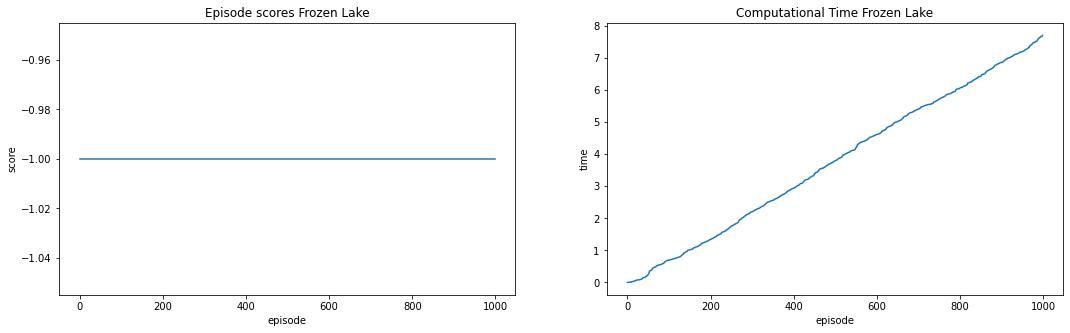

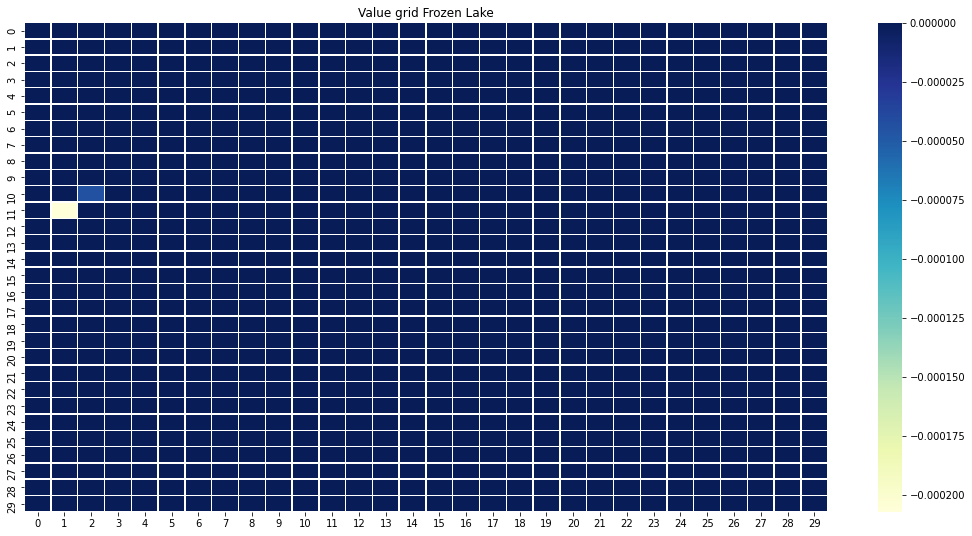

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


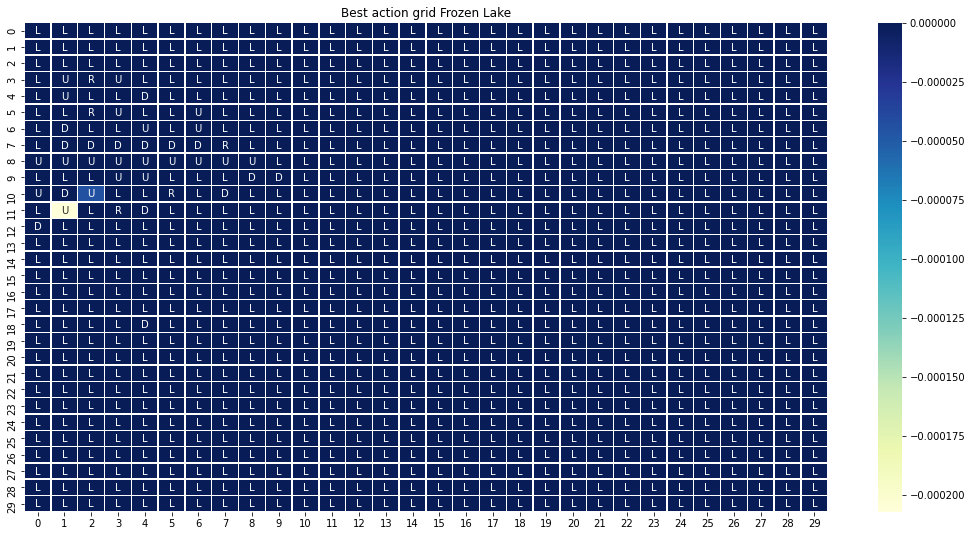

 13%|█▎        | 134/999 [00:00<00:03, 218.26it/s]


Episode 100
score = -1.0000



 21%|██        | 209/999 [00:01<00:08, 91.96it/s]


Episode 200
score = -1.0000



 31%|███       | 310/999 [00:02<00:10, 65.25it/s]


Episode 300
score = -1.0000



 41%|████      | 407/999 [00:04<00:12, 48.49it/s]


Episode 400
score = -1.0000



 51%|█████     | 509/999 [00:06<00:07, 63.46it/s]


Episode 500
score = -1.0000



 61%|██████    | 610/999 [00:08<00:06, 55.67it/s]


Episode 600
score = -1.0000



 71%|███████   | 709/999 [00:10<00:05, 55.37it/s]


Episode 700
score = -1.0000



 80%|████████  | 802/999 [00:12<00:03, 61.72it/s]


Episode 800
score = -1.0000



 91%|█████████ | 911/999 [00:14<00:01, 46.76it/s]


Episode 900
score = -1.0000



100%|██████████| 999/999 [00:16<00:00, 60.88it/s]


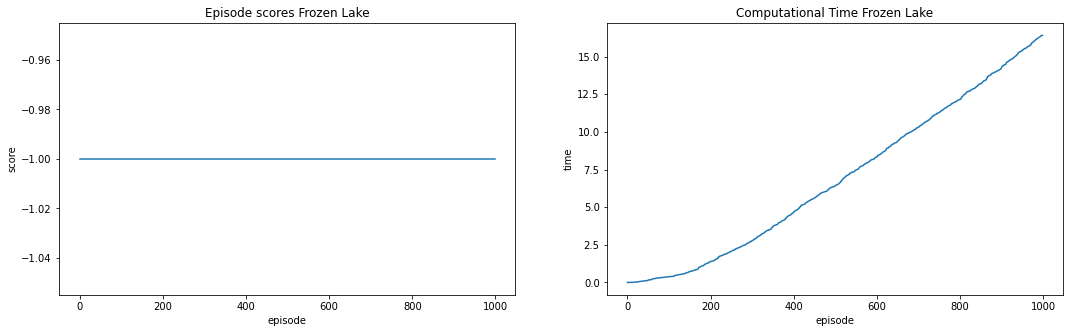

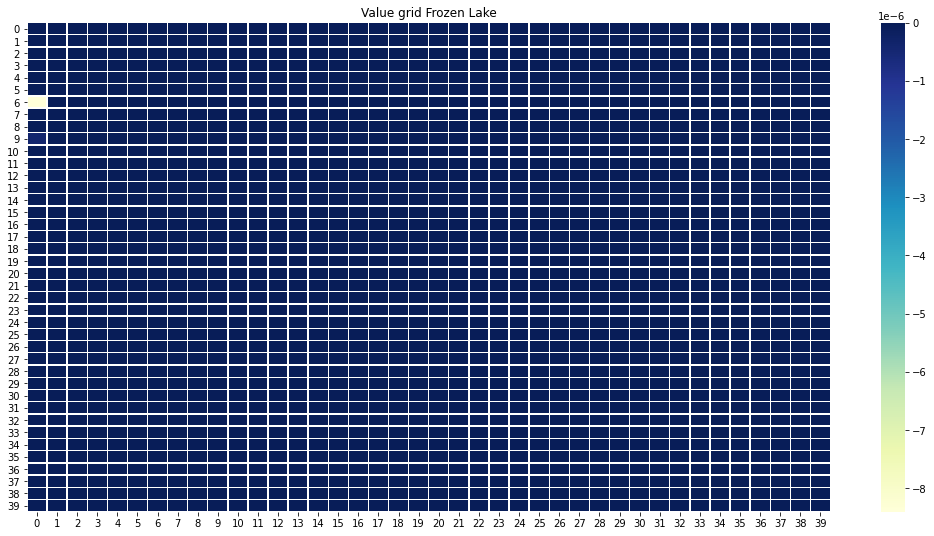

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


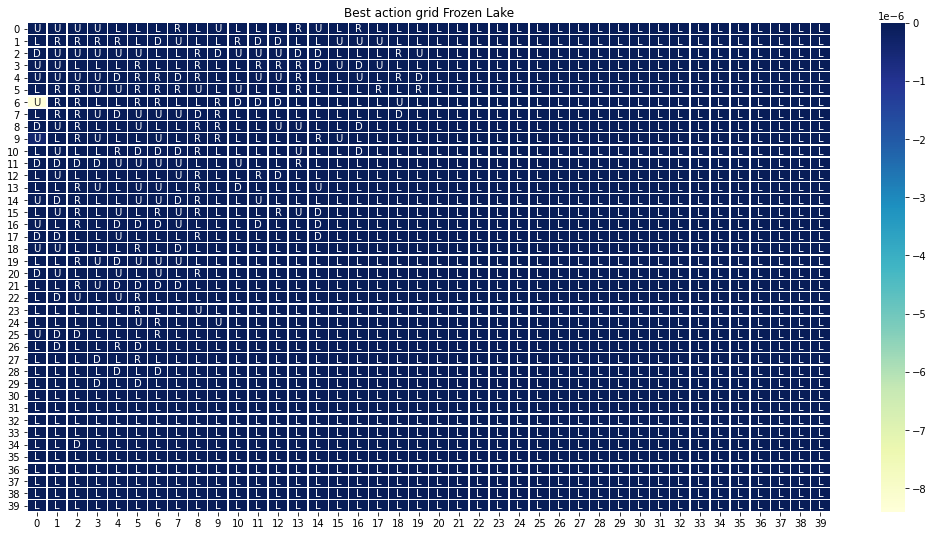

 18%|█▊        | 183/999 [00:00<00:01, 438.21it/s]


Episode 100
score = -1.0000



 27%|██▋       | 271/999 [00:00<00:01, 432.25it/s]


Episode 200
score = -1.0000



 37%|███▋      | 367/999 [00:00<00:01, 444.56it/s]


Episode 300
score = -1.0000



 45%|████▌     | 453/999 [00:01<00:01, 416.48it/s]


Episode 400
score = -1.0000



 55%|█████▌    | 552/999 [00:01<00:00, 449.77it/s]


Episode 500
score = -1.0000



 65%|██████▌   | 651/999 [00:01<00:00, 457.22it/s]


Episode 600
score = -1.0000



 74%|███████▍  | 743/999 [00:01<00:00, 427.41it/s]


Episode 700
score = -1.0000



 84%|████████▍ | 840/999 [00:01<00:00, 432.65it/s]


Episode 800
score = -1.0000



 98%|█████████▊| 981/999 [00:02<00:00, 429.98it/s]


Episode 900
score = -1.0000


100%|██████████| 999/999 [00:02<00:00, 435.07it/s]


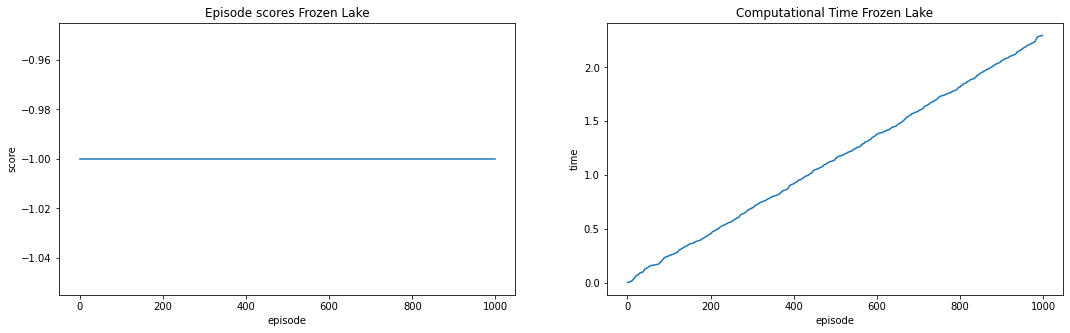

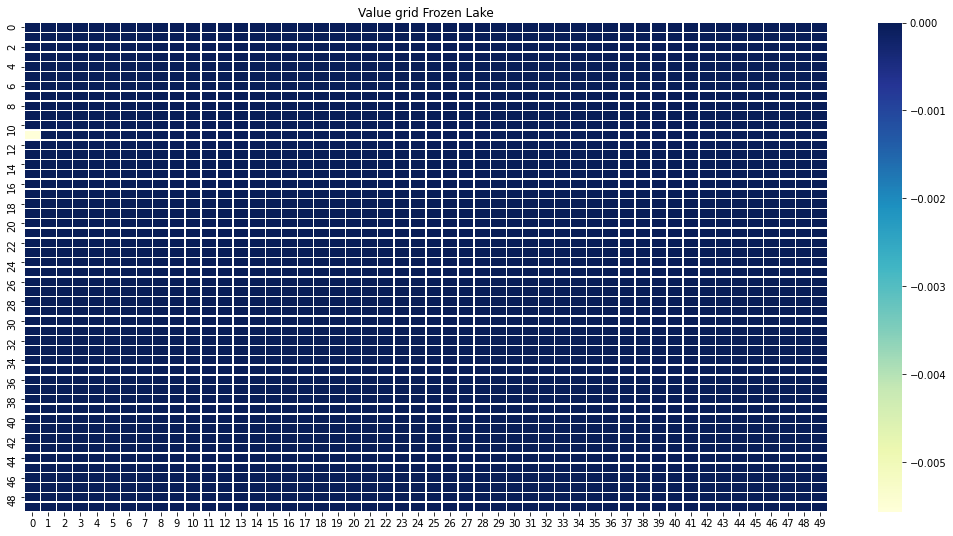

/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/home/aymane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


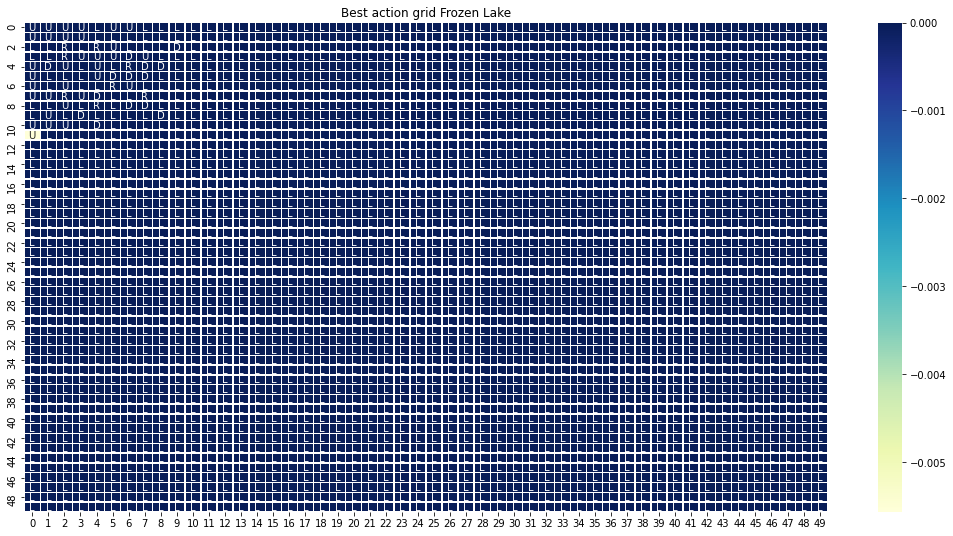

100%|██████████| 13/13 [07:25<00:00, 34.23s/it]


In [132]:
Q_iteration_time_with_size = []
for s in tqdm(size):
    env = FrozenLakeEnv(desc=generate_random_map(size=s, p=0.8), neg_rew=-1)
    start = time()
    q_learning(env, num_episodes=1000, print_every=100, learning_rate_decay= 0.5, epsilon_decay= 0.5)
    Q_iteration_time_with_size.append(time() - start)


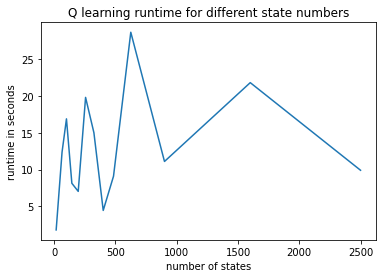

In [139]:
plt.plot(np.square(size),Q_iteration_time_with_size)
plt.title('Q learning runtime for different state numbers')
plt.xlabel('number of states')
plt.ylabel('runtime in seconds')
plt.show()